# Machine Learning Project 2020-2021

# Setup Environment
Before running this notebook, the user needs to configure a separate conda environment in order to reproduce the results obtained. An environment.yml file is provided in the project repository with this objective. By creating a conda environment through the yml file, the user will be able to run the whole project without issues. Besides, the user also need to install an additional package from a personal github repository since it is not available in pypi nor in conda repositories.

## 1 - Importing Packages

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
#EDA Libraries
import dtale
import sweetviz as sv
import pandas_profiling
from pandas_profiling import ProfileReport
#ML Libraries
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (Normalizer,MinMaxScaler,RobustScaler,StandardScaler,OneHotEncoder,OrdinalEncoder)
from sklearn.linear_model import RidgeClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error
#Column Transformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
#Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 as chis2
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score
#Modelling
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

import sklearn.preprocessing as prep
import sklearn.covariance as cov #Elliptic Envelop
from scipy.stats import chi2

%matplotlib inline
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

/opt/anaconda3/envs/pds_ml/lib/python3.8/site-packages/dtale/datasets.py:5: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import makeTimeDataFrame


# 2 - Data Import and integration

In [2]:
train=pd.read_excel(os.path.join(os.getcwd(),'Train.xlsx'))

In [3]:
test=pd.read_excel(os.path.join(os.getcwd(),'Test.xlsx'))

# 3 - Exploring Data

In [4]:
#Dimension of the training dataset
train.shape

(22400, 15)

In [5]:
#Dimension of the testing data
test.shape

(10100, 14)

In [6]:
#Data types for the train dataset 
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22400 entries, 0 to 22399
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CITIZEN_ID              22400 non-null  int64 
 1   Name                    22400 non-null  object
 2   Birthday                22400 non-null  object
 3   Native Continent        22400 non-null  object
 4   Marital Status          22400 non-null  object
 5   Lives with              22400 non-null  object
 6   Base Area               22400 non-null  object
 7   Education Level         22400 non-null  object
 8   Years of Education      22400 non-null  int64 
 9   Employment Sector       22400 non-null  object
 10  Role                    22400 non-null  object
 11  Working Hours per week  22400 non-null  int64 
 12  Money Received          22400 non-null  int64 
 13  Ticket Price            22400 non-null  int64 
 14  Income                  22400 non-null  int64 
dtypes:

In [7]:
# after a first inspection of the train data excel file, we found out that some columns are the following string: '?' so bellow we check the quantity of '?' string and what columns have them. 
def checkdf_character(df,char): 
    for i in range(len(df.columns)):
        #Printing the column names, number of rows & percentage of rows from the dataset
        #Further details will be printed in the next lines through the utilization of EDA tools
        size=len(df.loc[df.iloc[:,i].astype(str).str.startswith('?')])
        if size>0:
            print('------------------------------------------')
            print('Column: {}{}Number of Rows: {}{}Percentage: {}%'.format(df.columns[i],'\n',size,'\n',round(size/len(df)*100,2)))

In [8]:
#Data inspection shows that the train dataset has rows with question mark '?' character
checkdf_character(train,'?')

------------------------------------------
Column: Base Area
Number of Rows: 395
Percentage: 1.76%
------------------------------------------
Column: Employment Sector
Number of Rows: 1264
Percentage: 5.64%
------------------------------------------
Column: Role
Number of Rows: 1271
Percentage: 5.67%


In [9]:
#Data inspection shows that the test dataset has rows with question mark '?' character
checkdf_character(test,'?')

------------------------------------------
Column: Base Area
Number of Rows: 187
Percentage: 1.85%
------------------------------------------
Column: Employment Sector
Number of Rows: 570
Percentage: 5.64%
------------------------------------------
Column: Role
Number of Rows: 570
Percentage: 5.64%


In [10]:
#Frequencies of number of missing values across rows
train.isna().apply(lambda x:sum(x), axis=1).value_counts().sort_index()

0    22400
dtype: int64

In [11]:
#Frequencies of number of missing values across rows
test.isna().apply(lambda x:sum(x), axis=1).value_counts().sort_index()

0    10100
dtype: int64

- Identify the outliers before going to the data preparation ? 
- Analyse the features with graphs 
- Explain how we identified the ? values. 
- Run anykind of correlation matrix? 

We need to explain why the creation of the 2 variables. 

# 4 - Modify the Data / Data Preparation 

# 4.1 Creating two new features from existing variables.

### 4.1.1 - Creating Gender from the variable Name, 0 for male and 1 for female.

In [12]:
train_upd=train.copy()
train_upd.insert(2,'Gender',train_upd['Name'].str.slice(0,4).str.replace('.','').str.replace(' ',''))

In [13]:
train_upd['Gender']=train_upd['Gender'].apply(lambda i: 0 if i=='Mr' else 1)

In [14]:
train_upd.drop('Name',axis=1,inplace=True)

In [15]:
train_upd['Gender'].unique()

array([0, 1])

### 4.1.2 - Creating Age from the variable Birthday

In [16]:
train_upd.insert(4,'Age',pd.Series([]))
for i,j in enumerate(list(train['Birthday'].values)):
    try:
        train_upd['Age'][i]=np.round((datetime.now()+timedelta(days=10228)-datetime.strptime(j.replace(' ',''),'%B%d,%Y'))/timedelta(days=365.2425))
    except ValueError:
        train_upd['Age'][i]=np.round((datetime.now()+timedelta(days=10228)-datetime.strptime(j.replace(' ','').replace('9','8'),'%B%d,%Y'))/timedelta(days=365.2425))
train_upd['Age']=train_upd['Age'].astype('uint8')

In [17]:
train_upd.drop('Birthday',axis=1,inplace=True)

# 4.2 - Filling the values with '?'

In [18]:
# since we are using IterativeImputer() to fill the '?' string values we need to change them to NaN's so the algorigthm works.
for i in [6,9,10]:
    aIndex=np.array(train_upd[train_upd.iloc[:,i].astype(str).str.startswith('?')].iloc[:,i].index)
    for j in aIndex:
        train_upd.iloc[j,i]=np.nan
train_upd.isna().sum()

CITIZEN_ID                   0
Gender                       0
Native Continent             0
Age                          0
Marital Status               0
Lives with                   0
Base Area                  395
Education Level              0
Years of Education           0
Employment Sector         1264
Role                      1271
Working Hours per week       0
Money Received               0
Ticket Price                 0
Income                       0
dtype: int64

In [19]:
#Creating a data frame with the categorical variables.
cat_col = train_upd.select_dtypes(include=['object']).columns.values

In [20]:
encoder = OrdinalEncoder()
mice = IterativeImputer()

In [21]:
def encode(data):
    reshape = np.array(data.dropna()).reshape(-1,1)
    ordinal = encoder.fit_transform(reshape)
    data.loc[data.notnull()] = np.squeeze(ordinal)
    return data

In [22]:
train_bkp=train_upd.copy()
for i in cat_col: 
    encode(train_upd[i])

In [23]:
#Filling NaN according to Mice algorithm
train_upd=pd.DataFrame(np.round(mice.fit_transform(train_upd)),columns=train_upd.columns)
for col in cat_col:
    reshape = np.array(train_bkp[col].dropna()).reshape(-1,1)
    ordinal = encoder.fit_transform(reshape)
    train_upd[col] = encoder.inverse_transform(np.round(mice.fit_transform(train_upd[col].values.reshape(-1,1))))

In [24]:
# double check of NaN remotion
train_upd.isna().sum()

CITIZEN_ID                0
Gender                    0
Native Continent          0
Age                       0
Marital Status            0
Lives with                0
Base Area                 0
Education Level           0
Years of Education        0
Employment Sector         0
Role                      0
Working Hours per week    0
Money Received            0
Ticket Price              0
Income                    0
dtype: int64

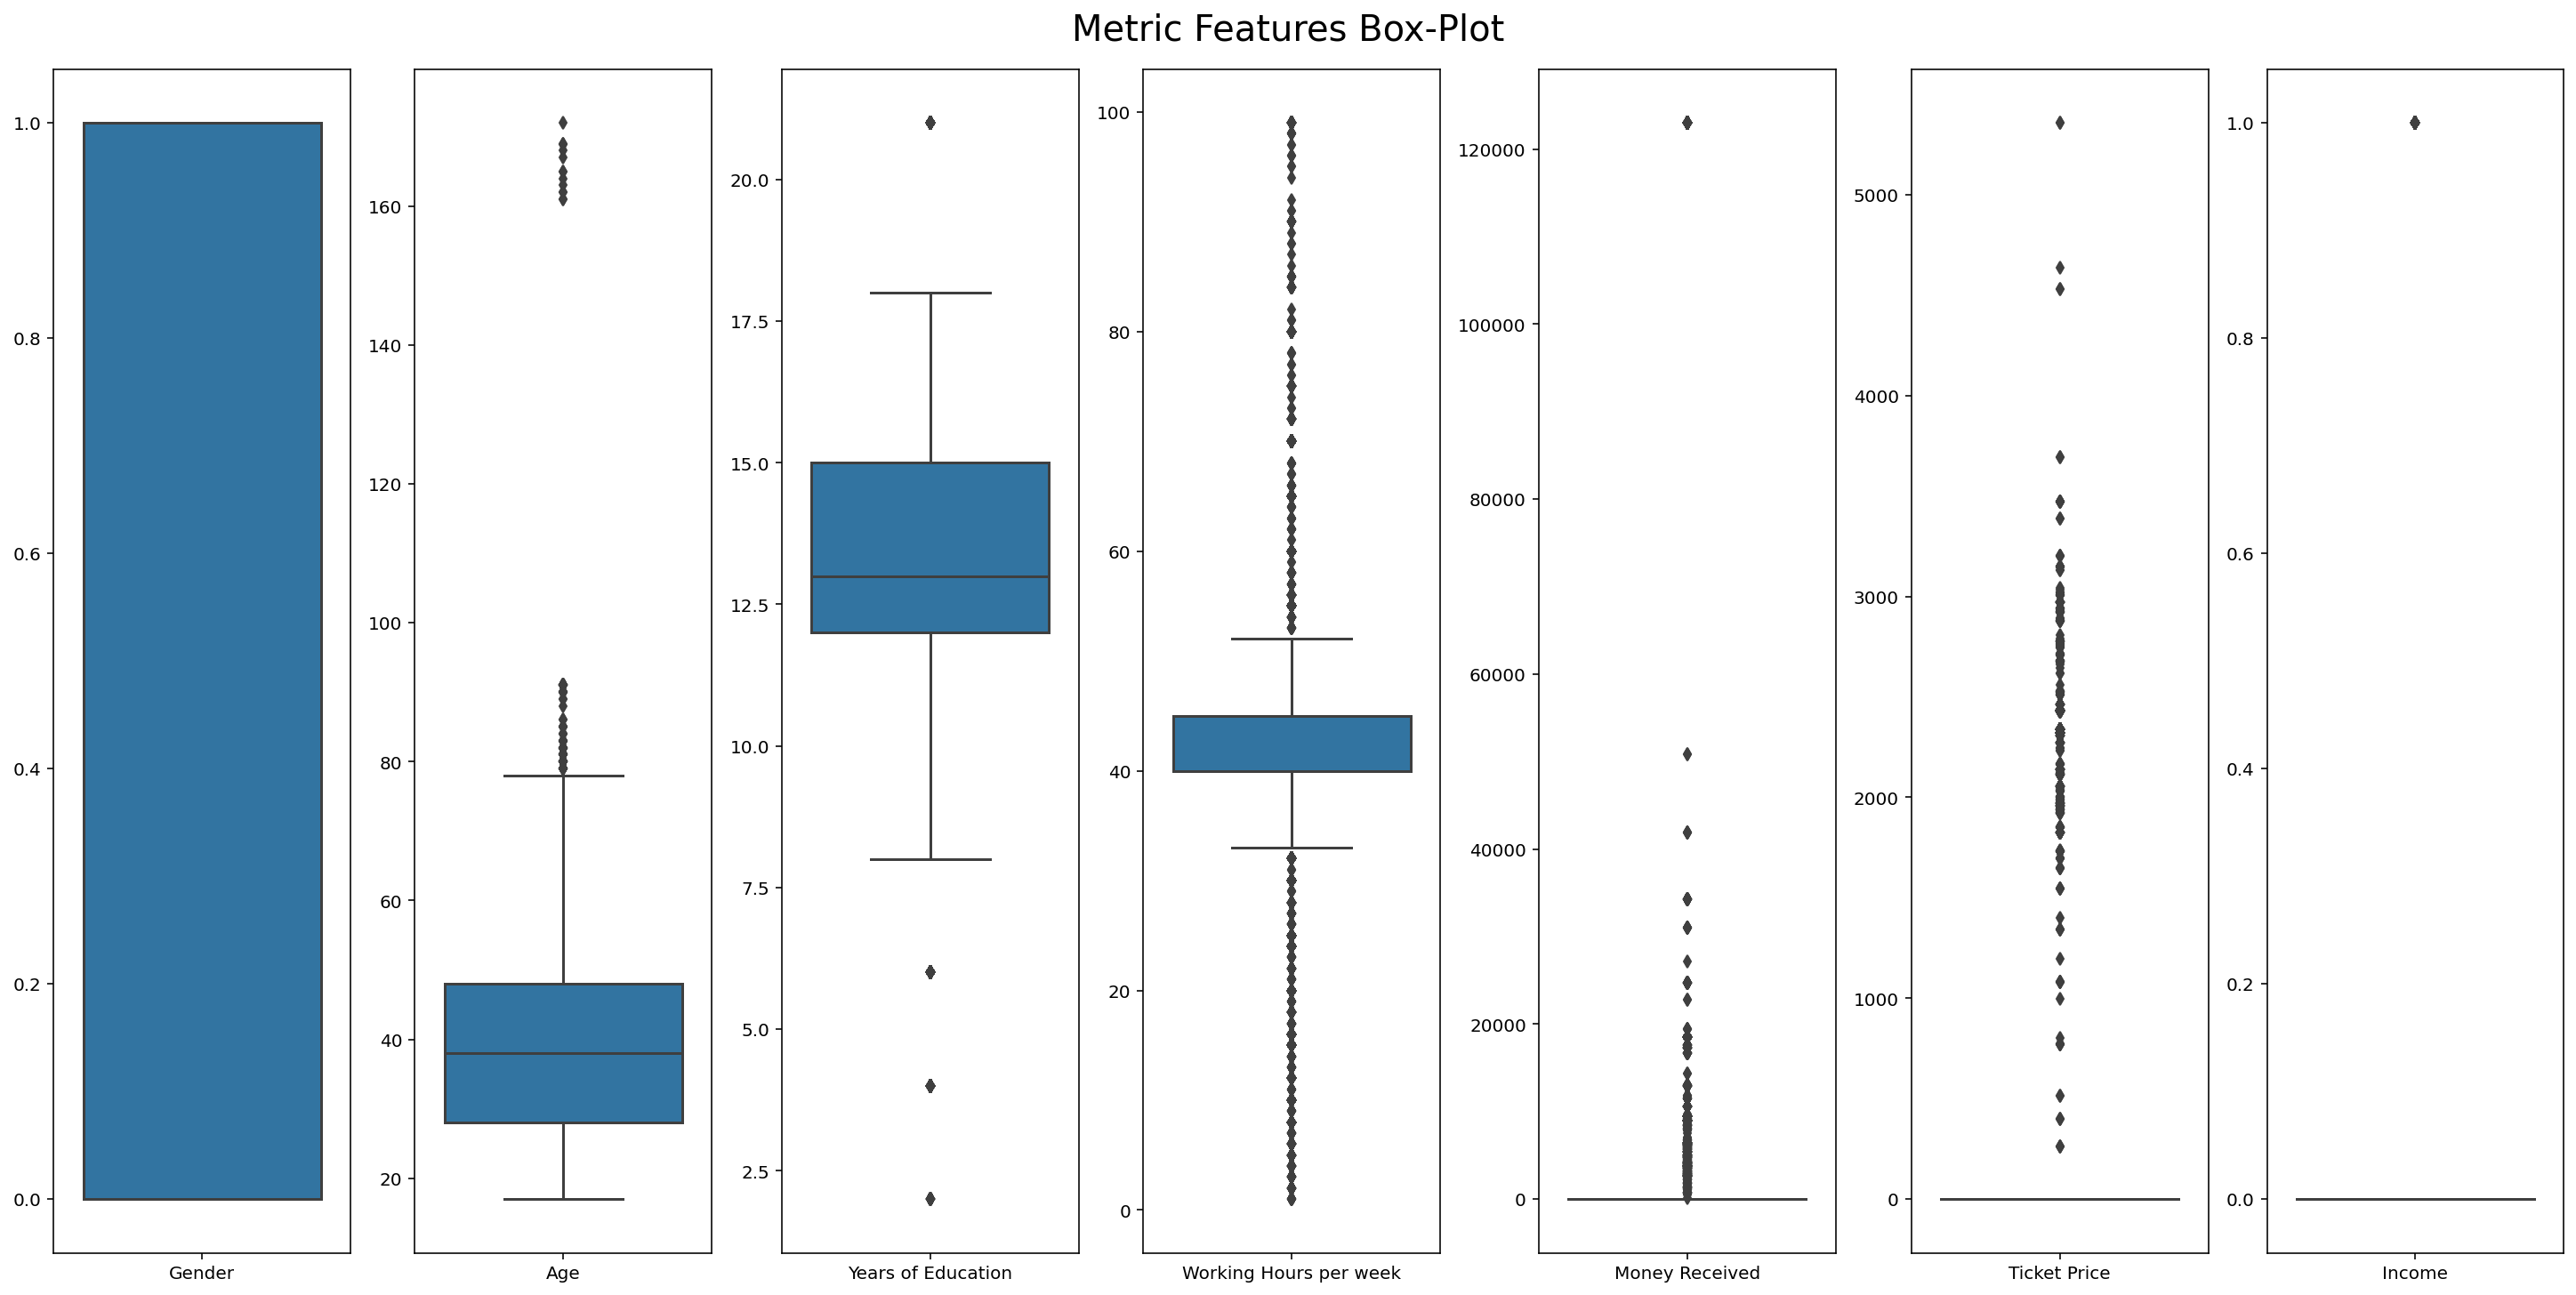

In [25]:
## boxplot for metric features
metric_data=train_upd.select_dtypes(exclude='object').melt('CITIZEN_ID')
metric_features=train_upd.select_dtypes(exclude='object').drop('CITIZEN_ID',1).columns

fig,axes=plt.subplots(1,len(metric_features),figsize=(20,10),constrained_layout=True)
    
for i in zip(axes, metric_features):
    f=sns.boxplot(x='variable', y='value', data=metric_data.loc[metric_data['variable']==i[1]], ax=i[0])
    plt.rc('xtick',labelsize=18)
    plt.rc('ytick',labelsize=18)
    f.set(xlabel=None)
    f.set(ylabel=None)
    
plt.suptitle('Metric Features Box-Plot',fontsize=20)
plt.show()

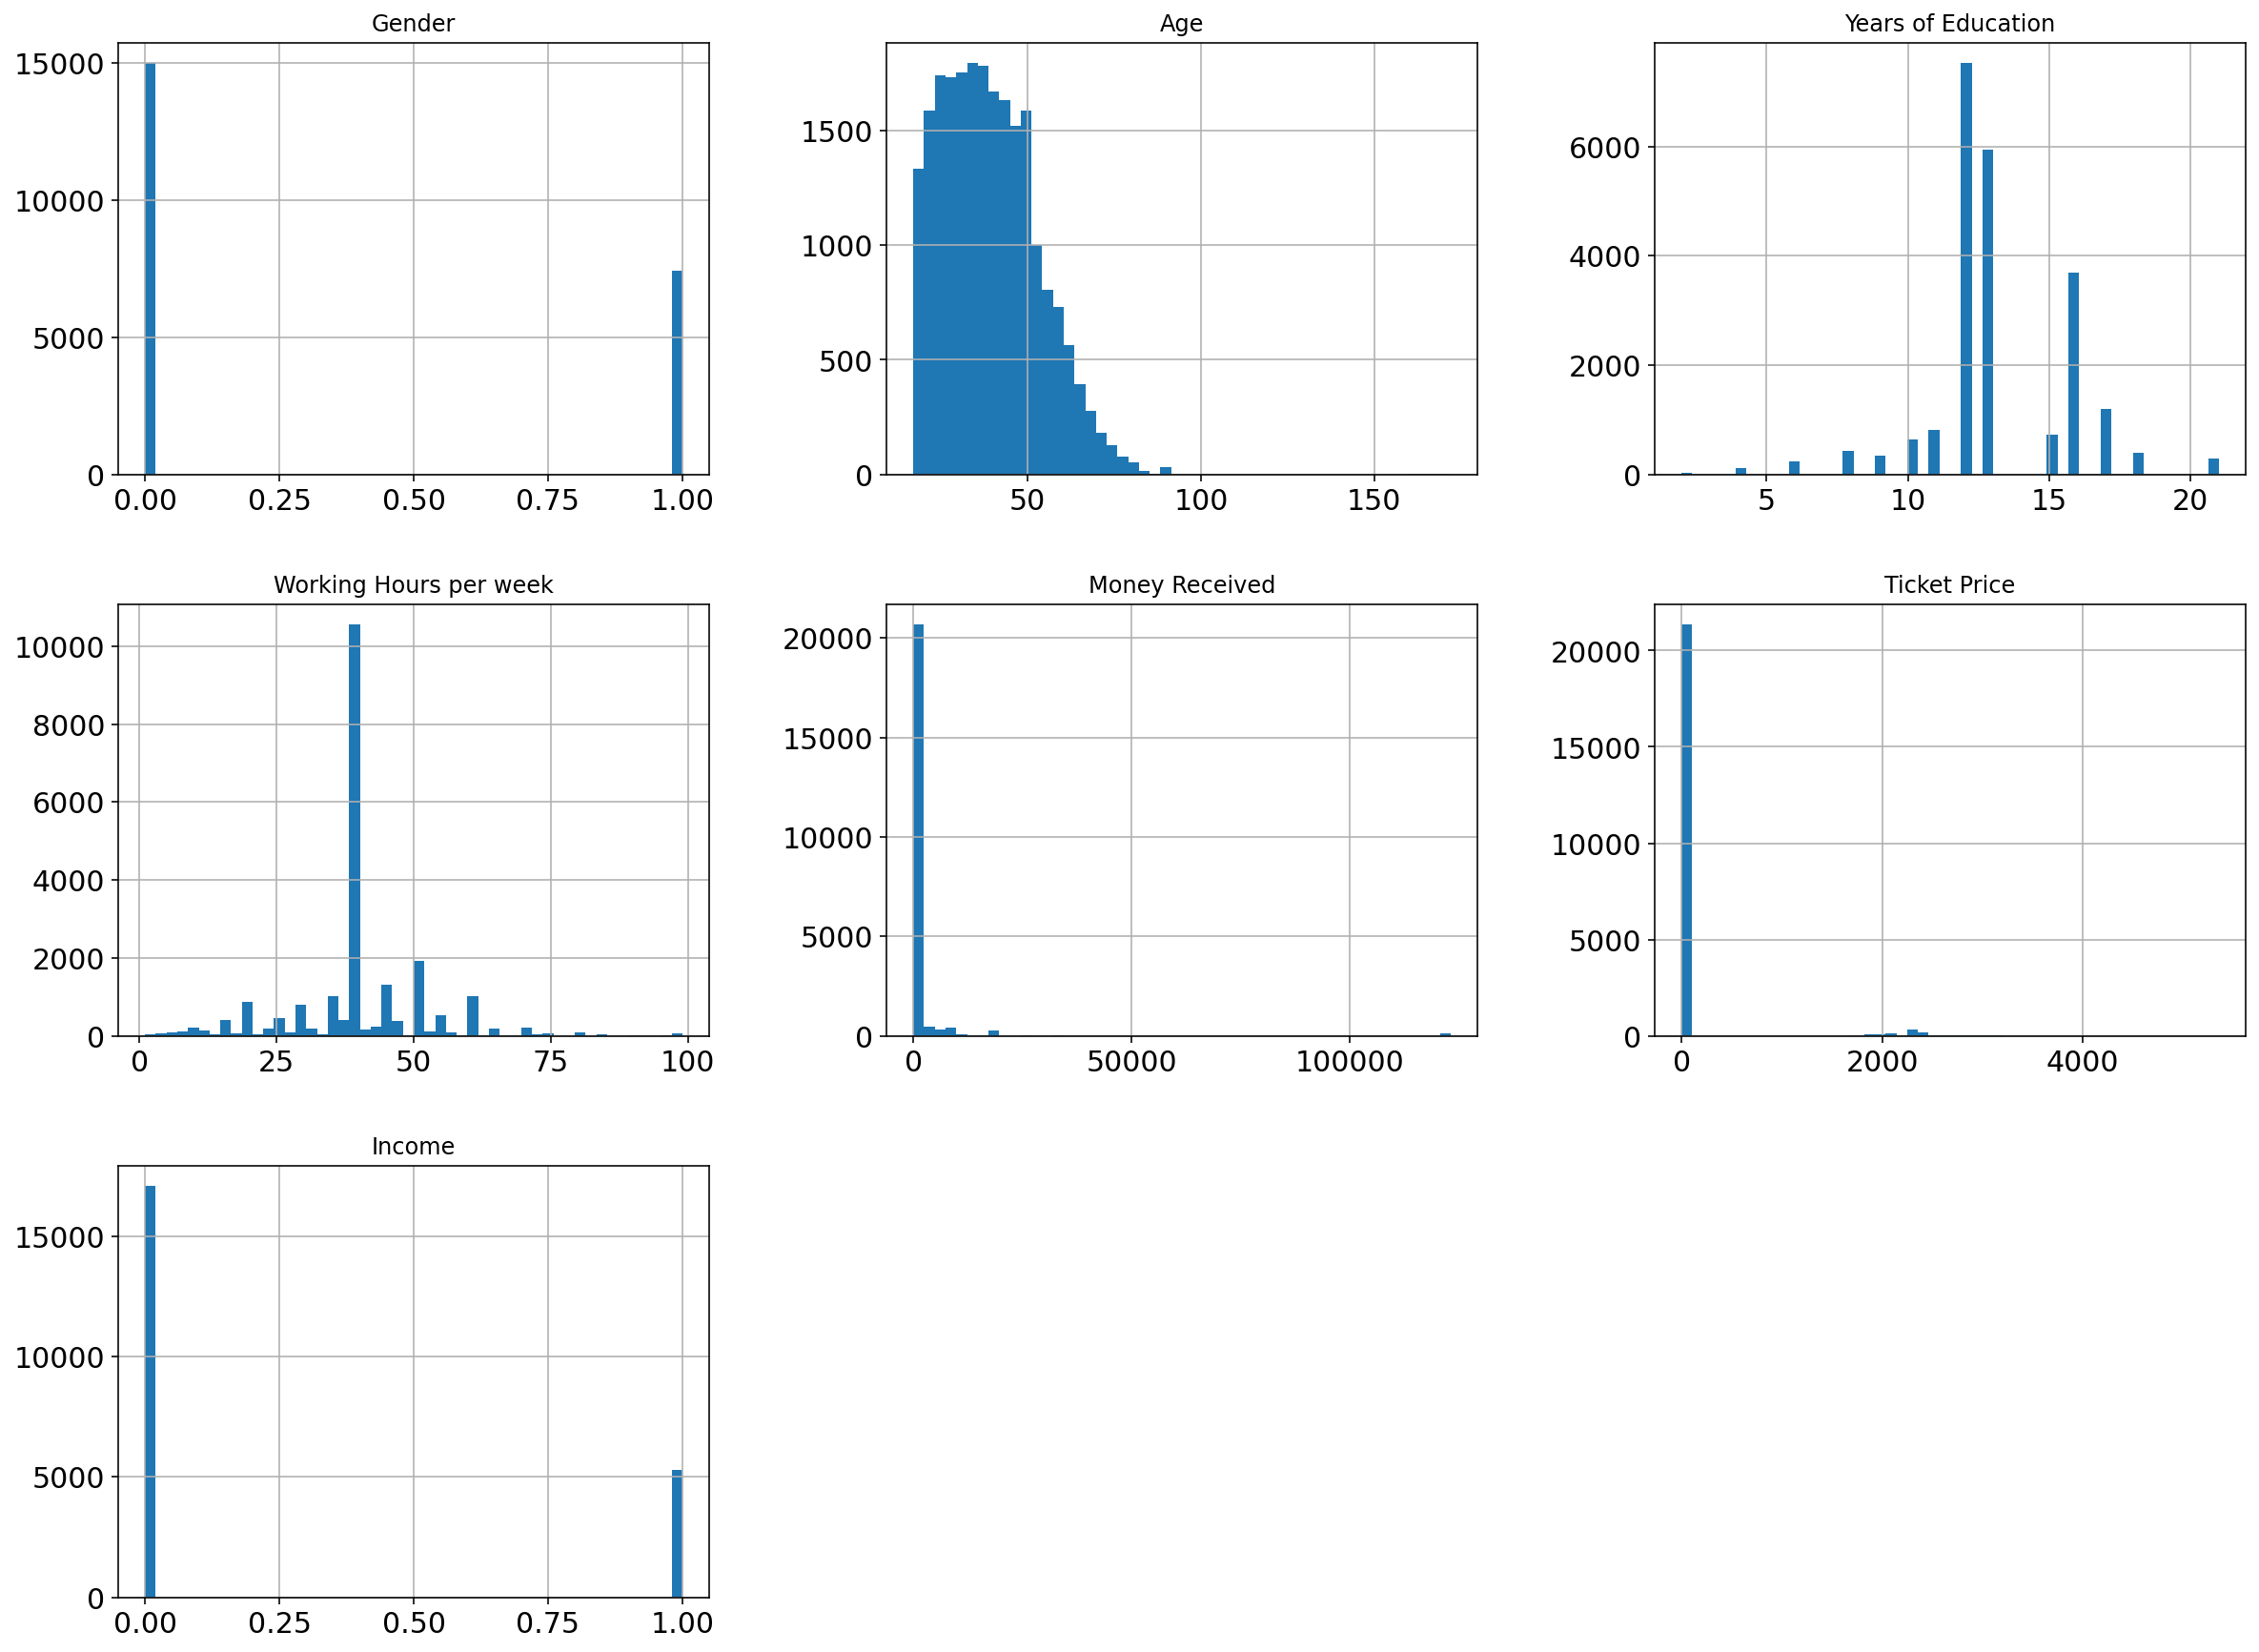

In [26]:
train_upd.iloc[:,1:].hist(figsize=(20,15),bins=50,xlabelsize=15,ylabelsize=15)
plt.show()

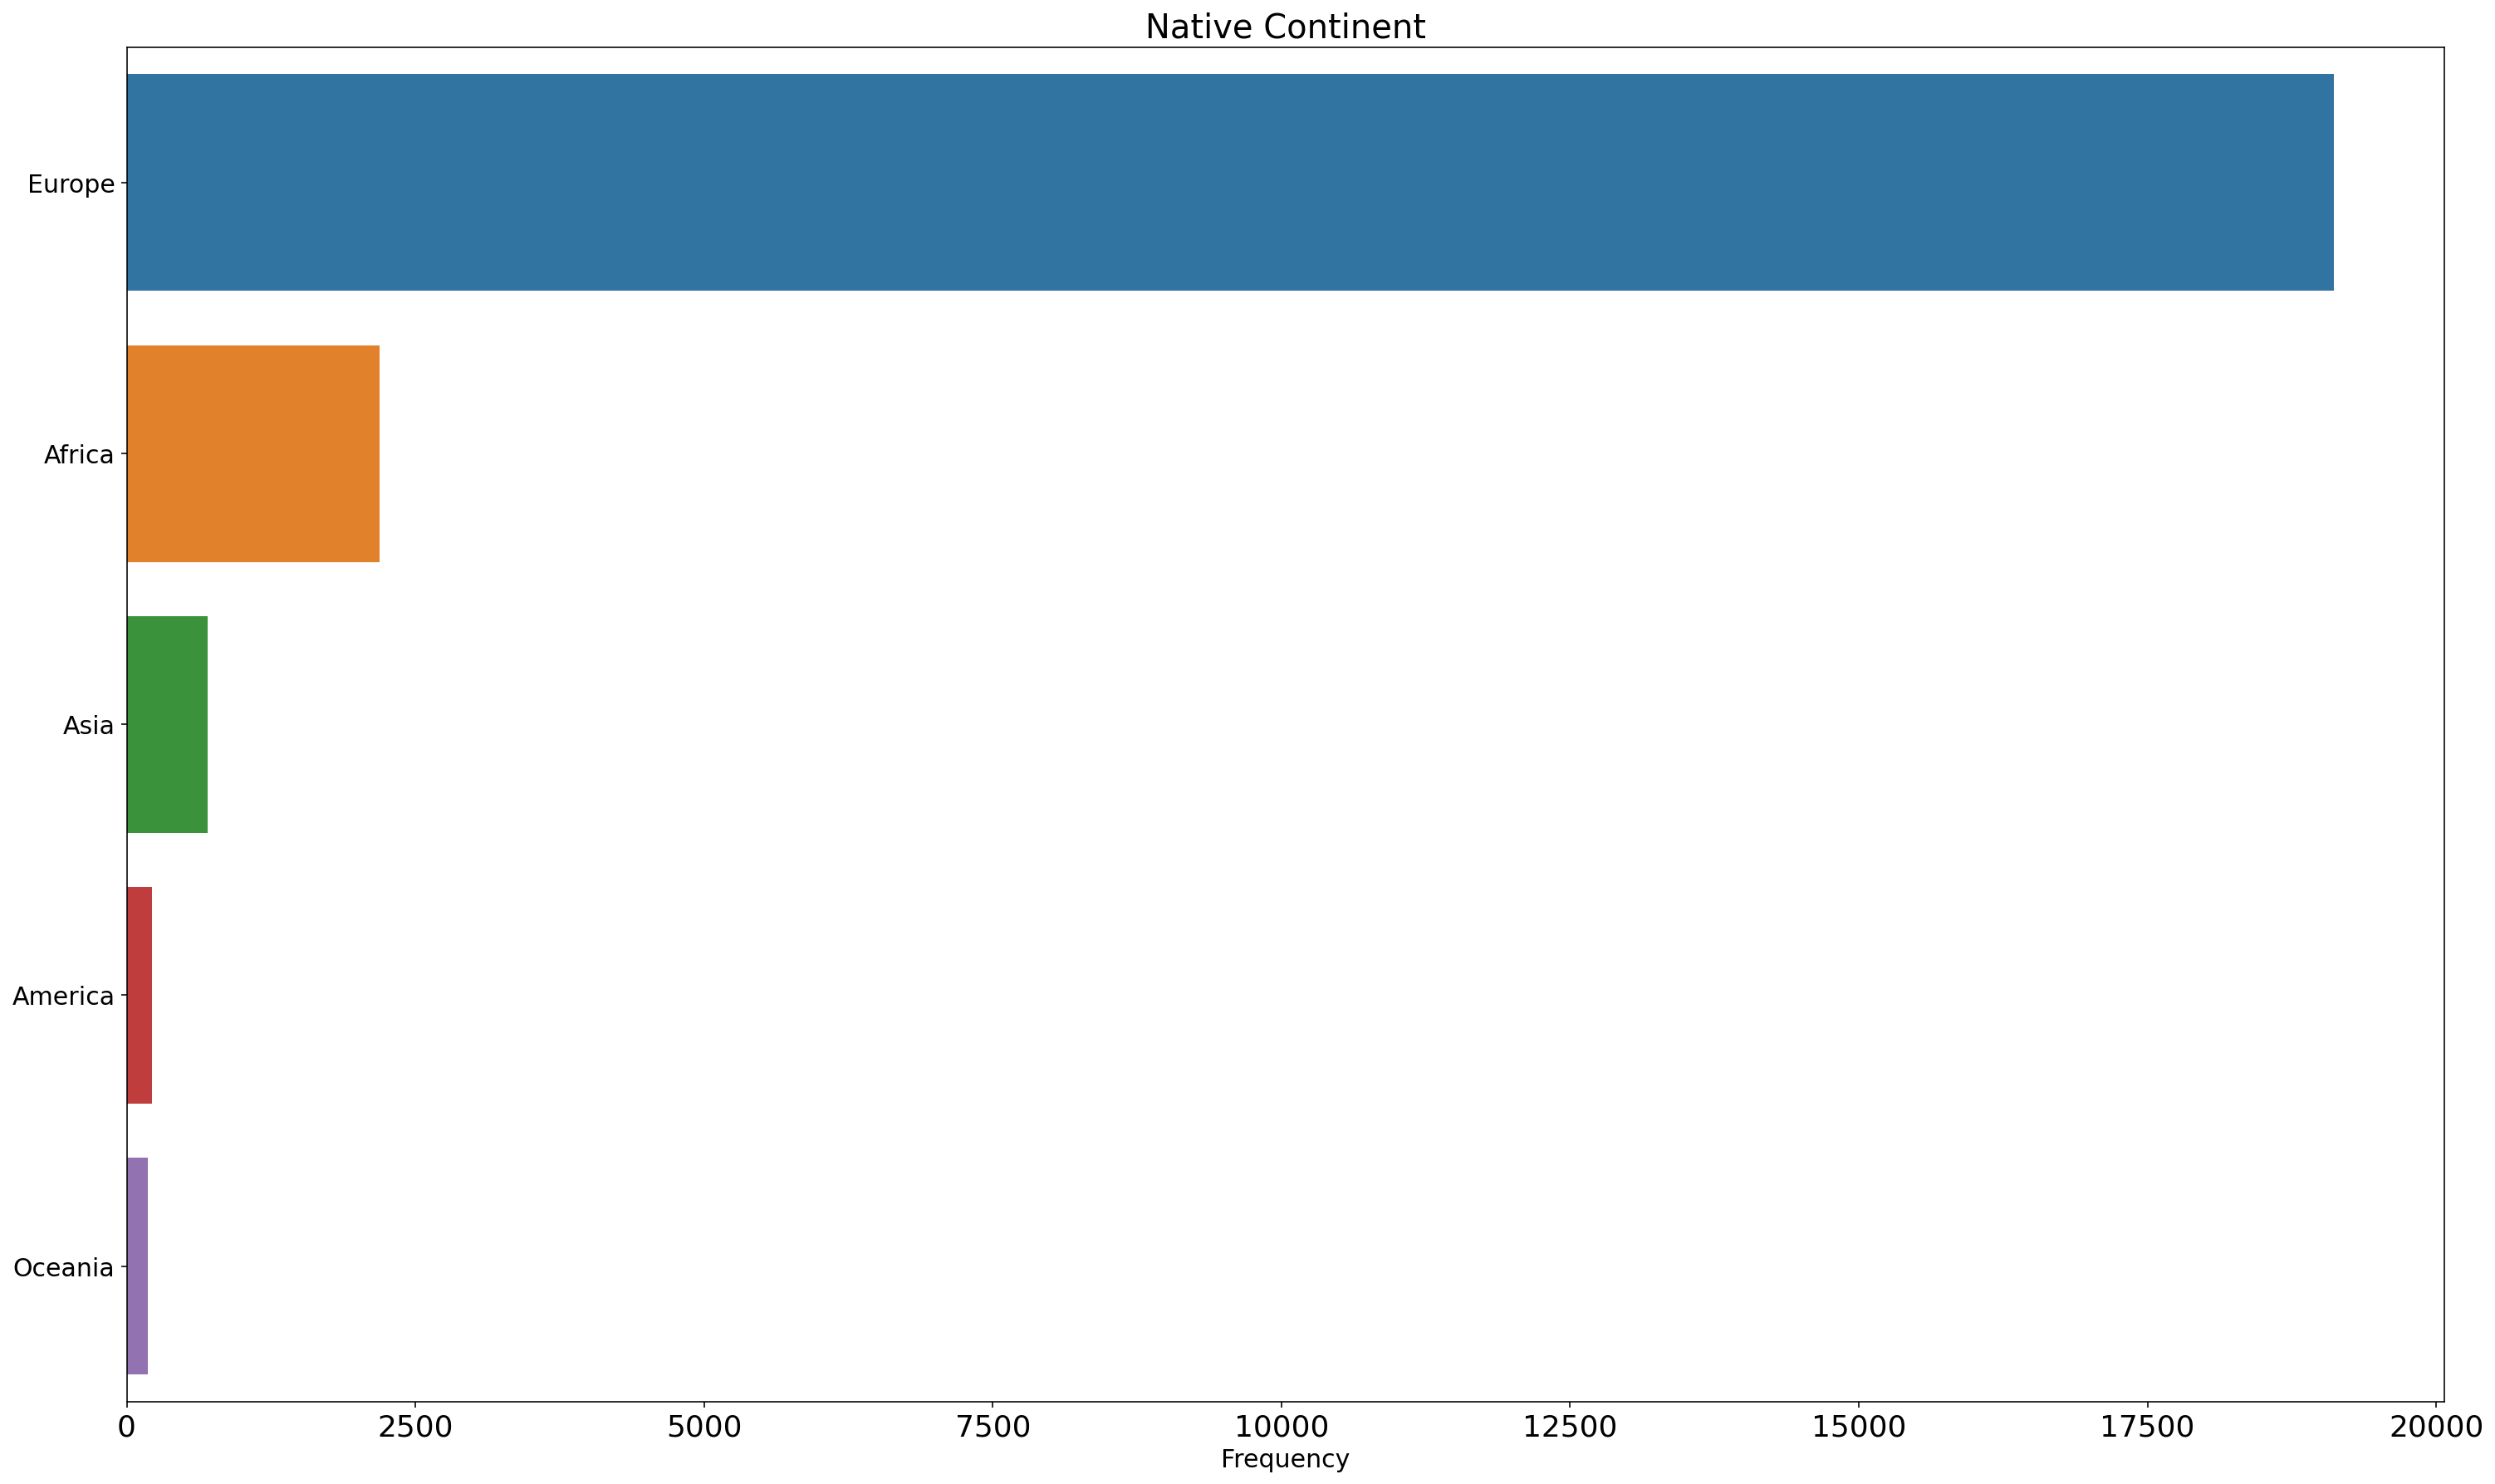

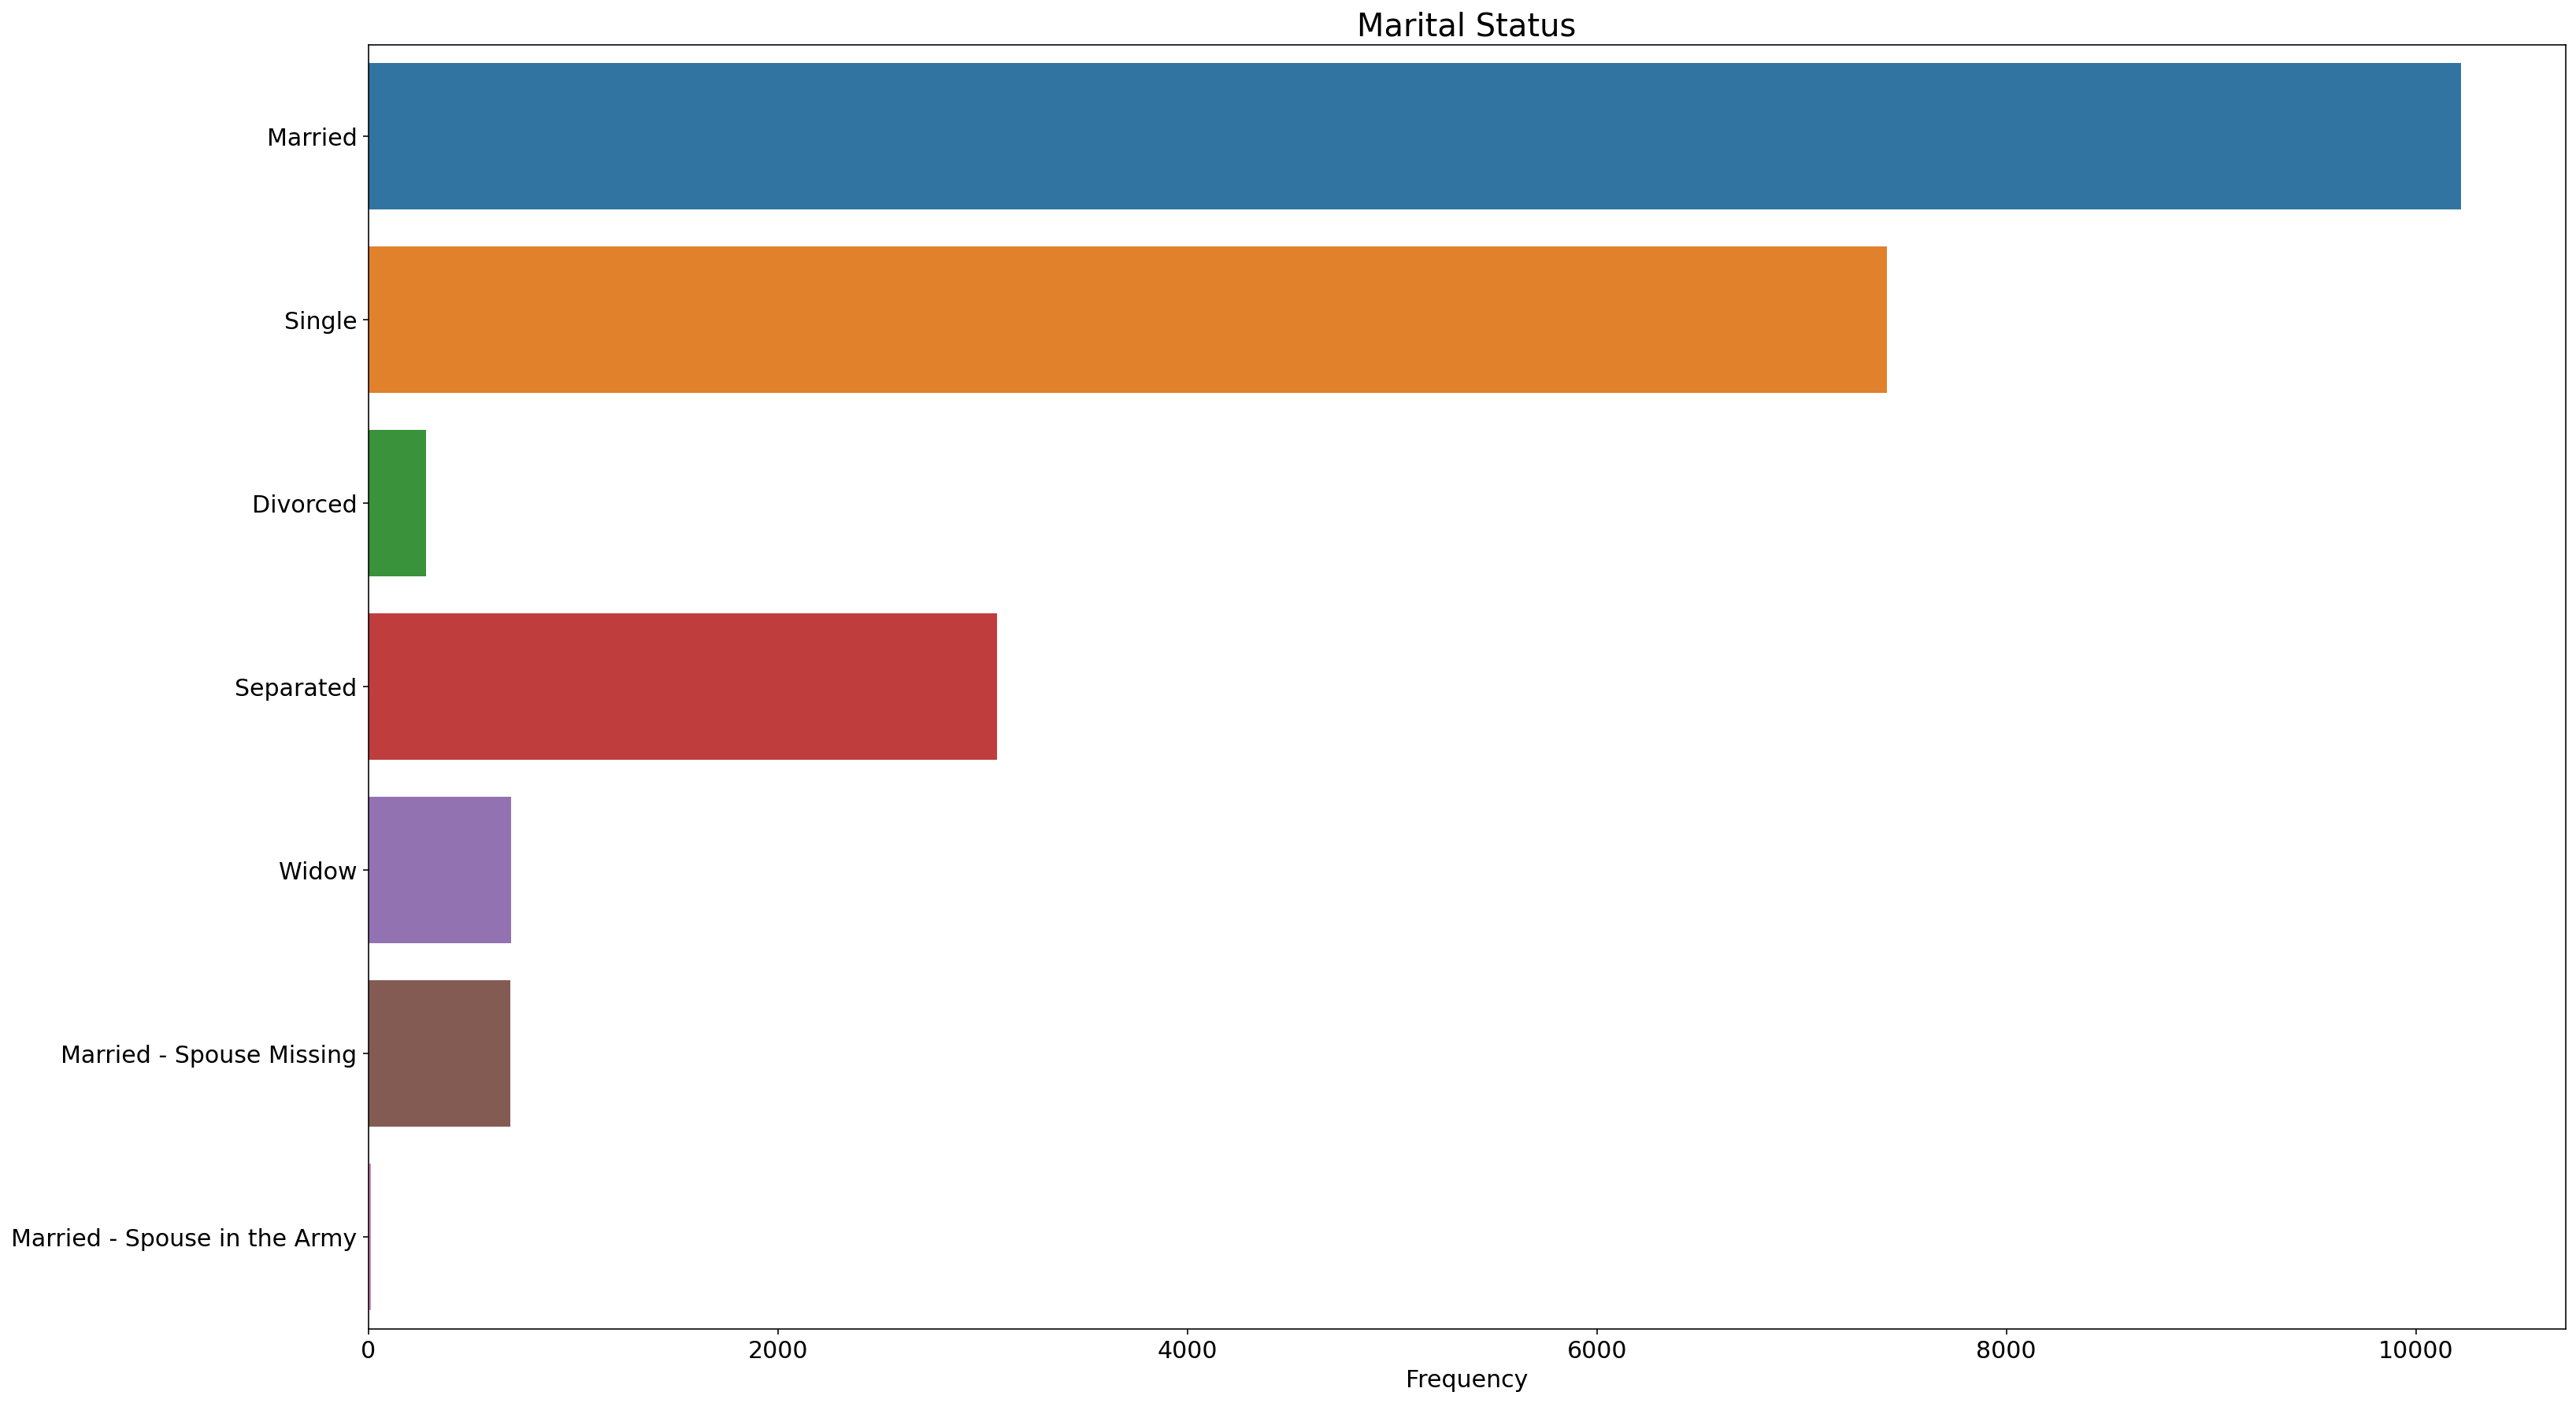

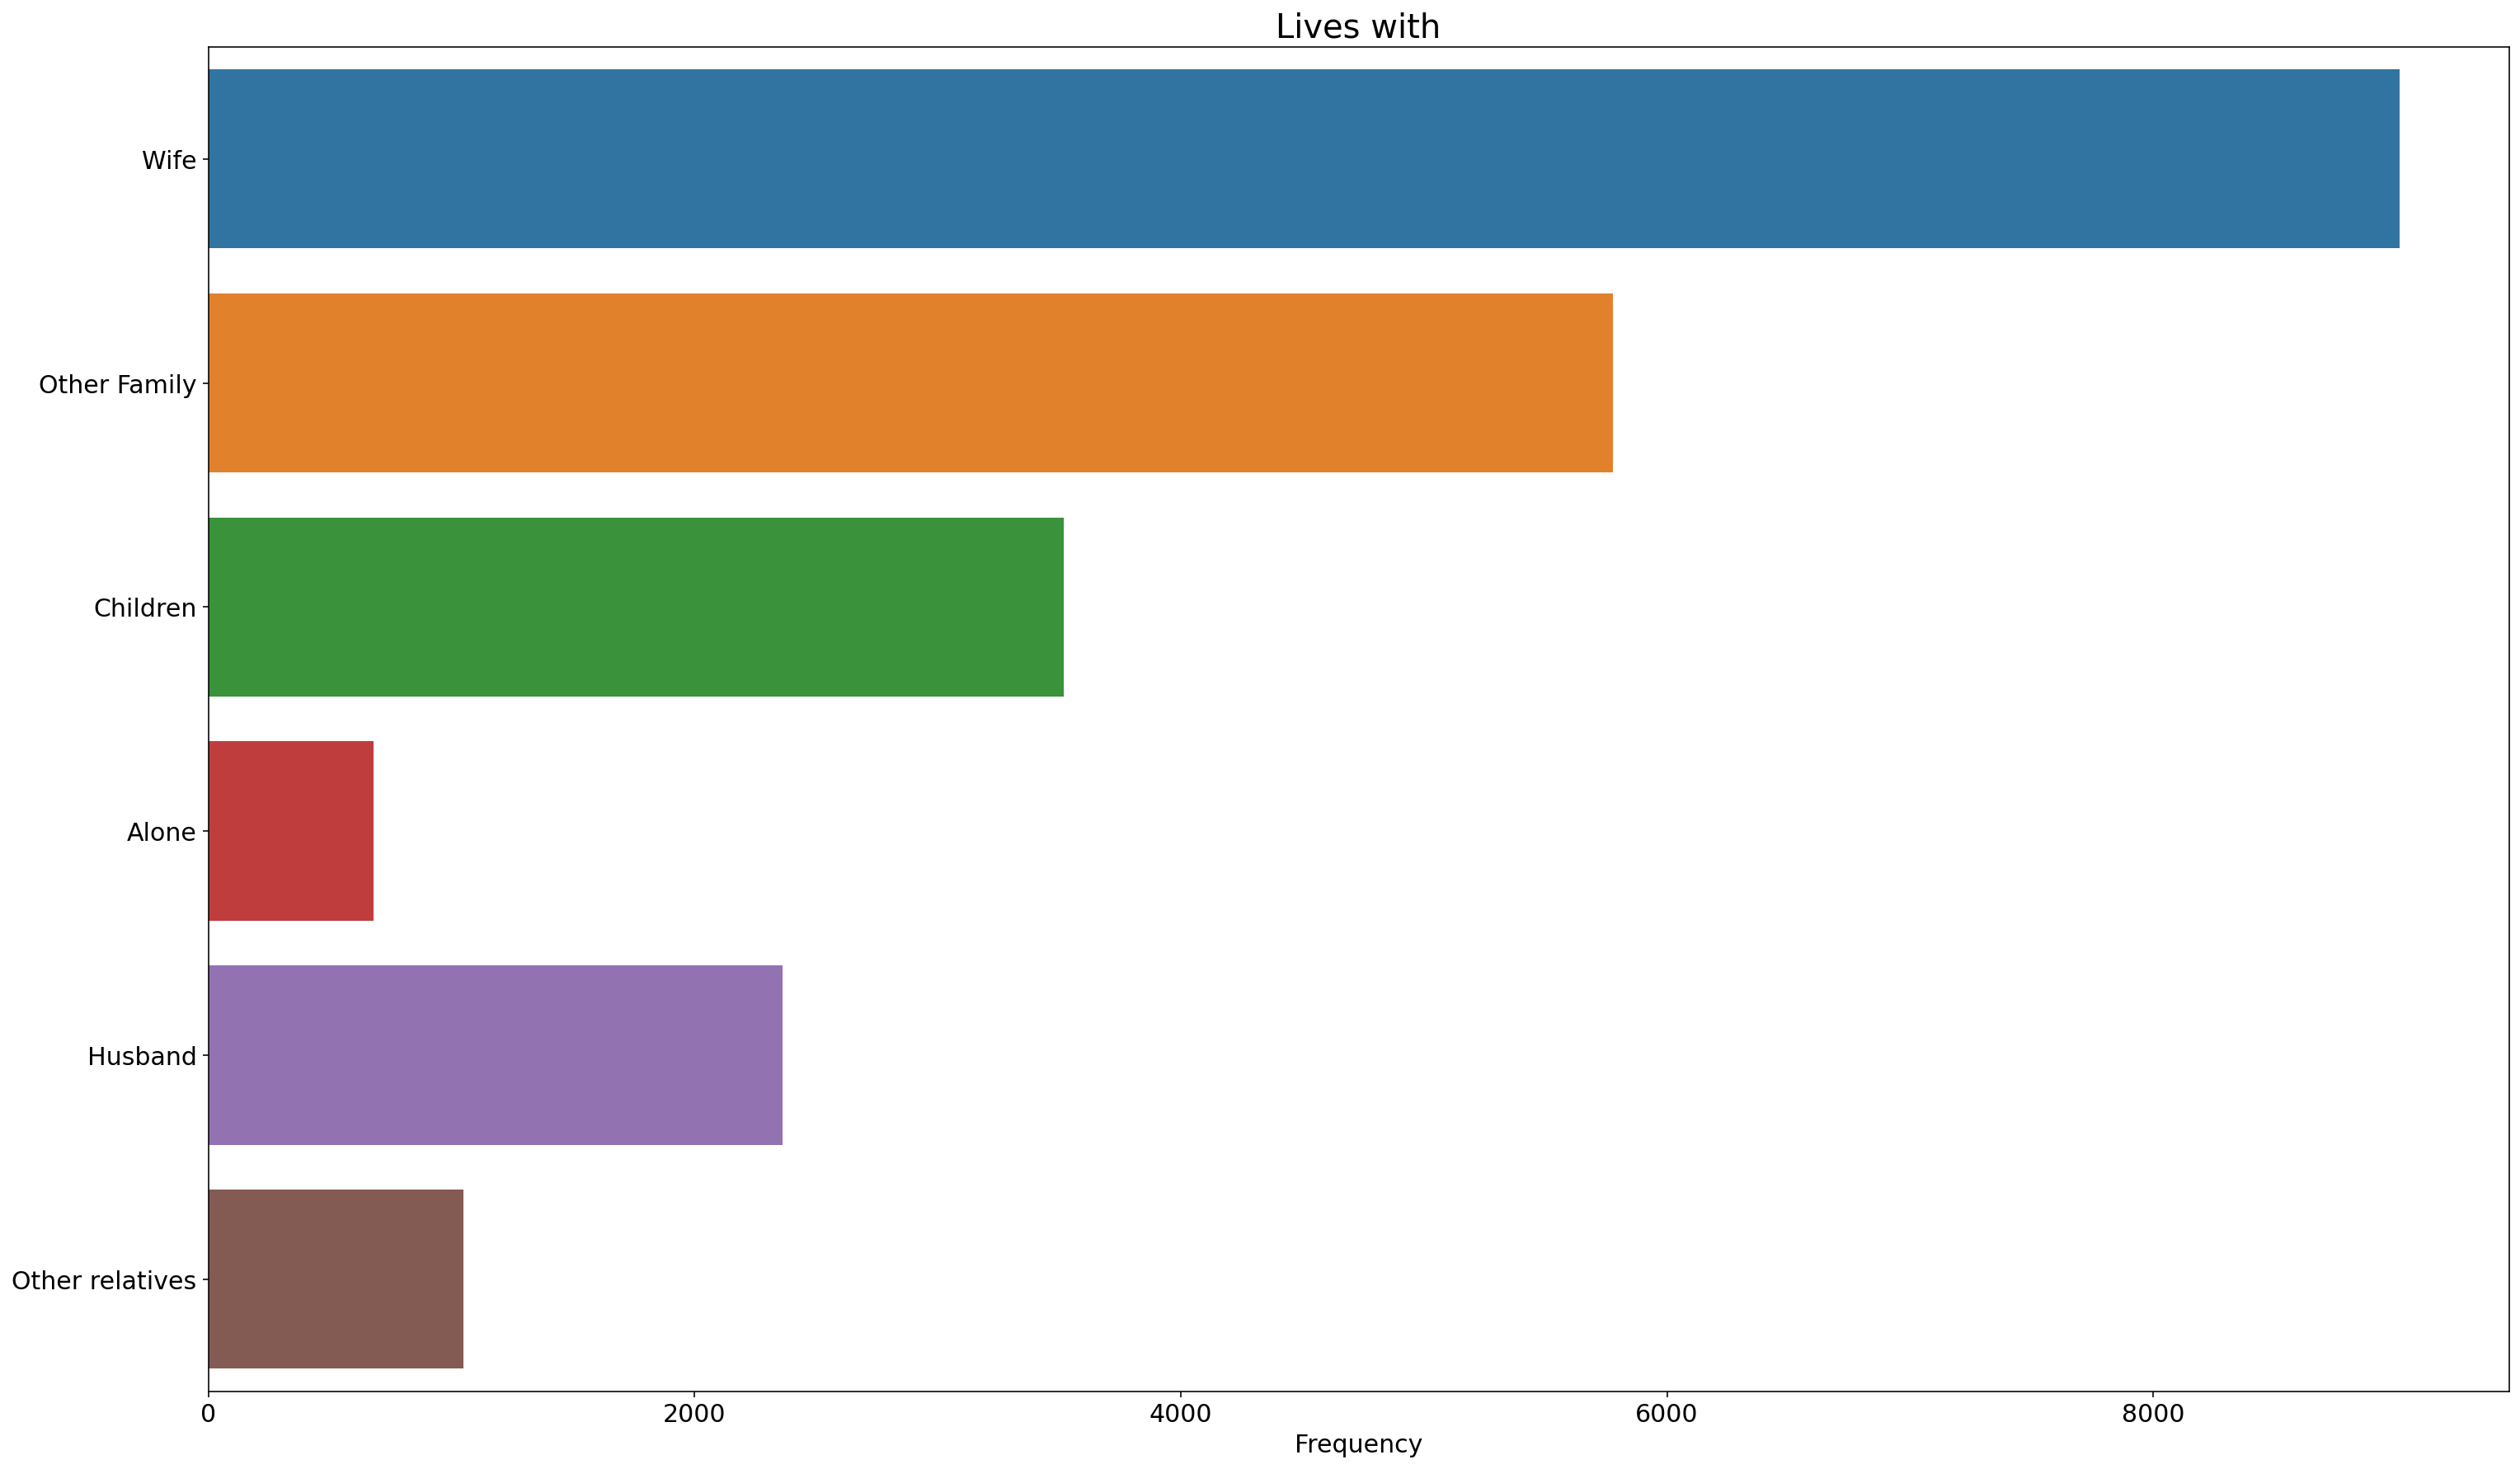

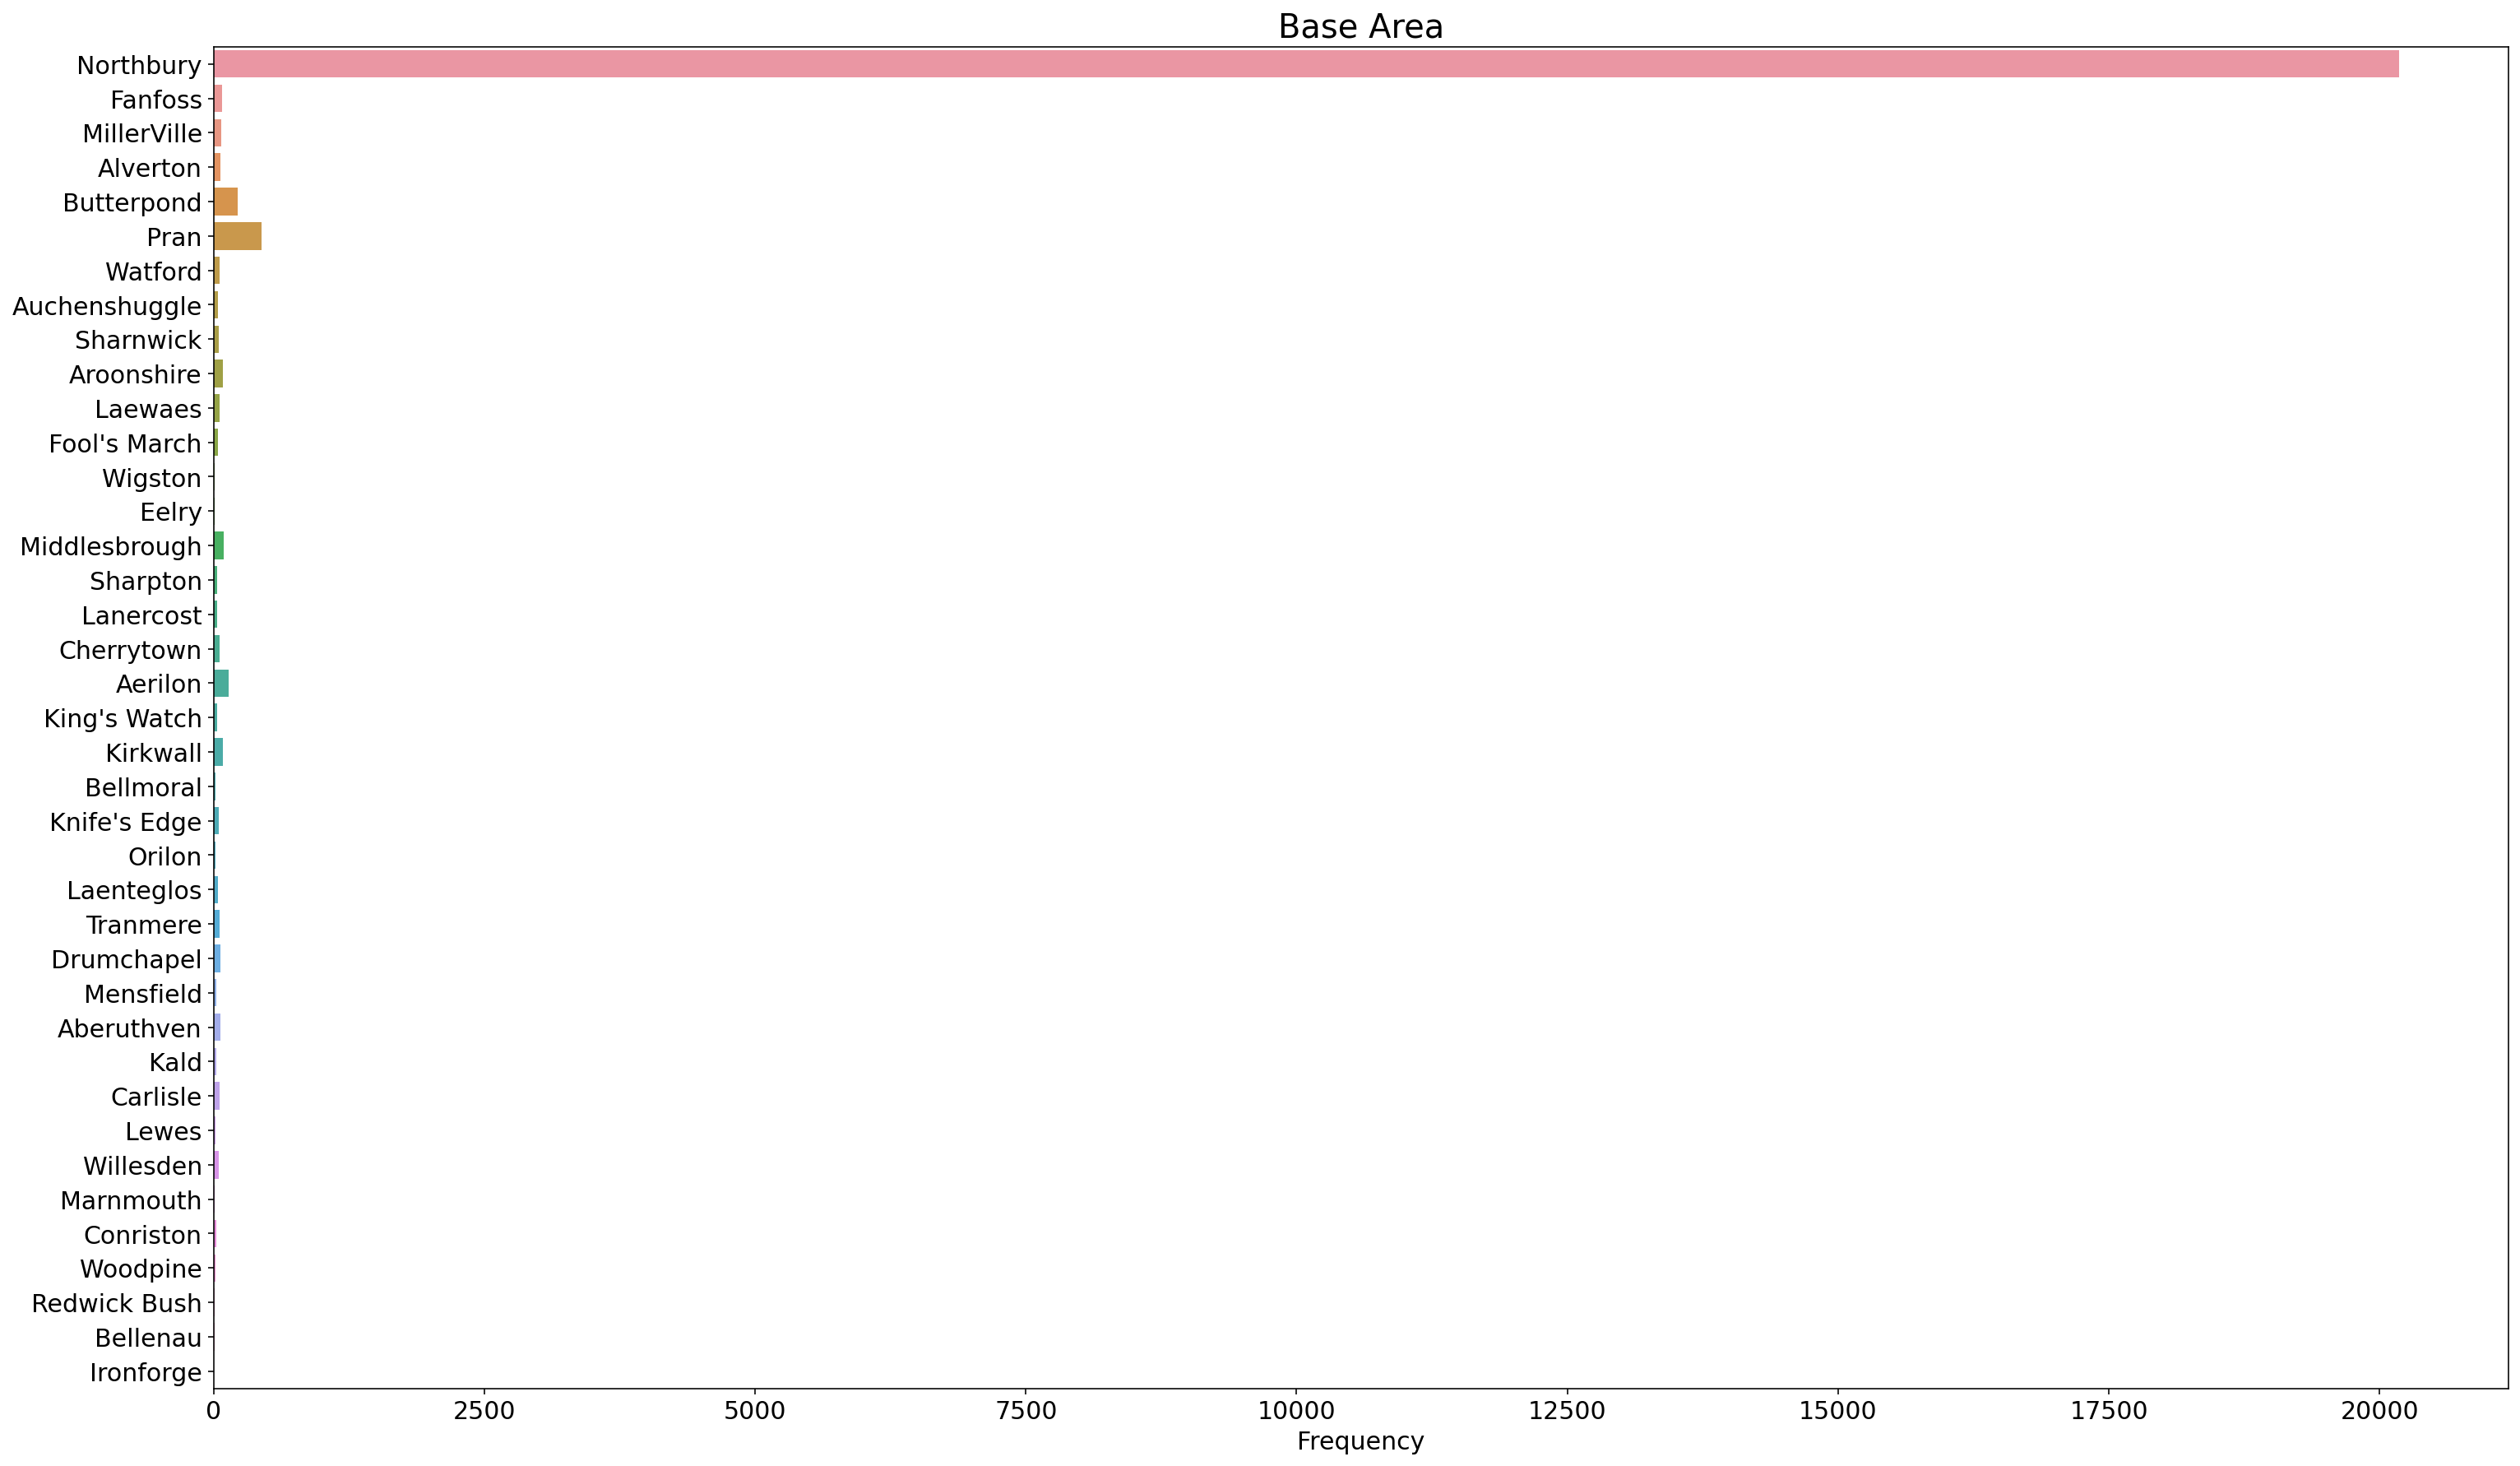

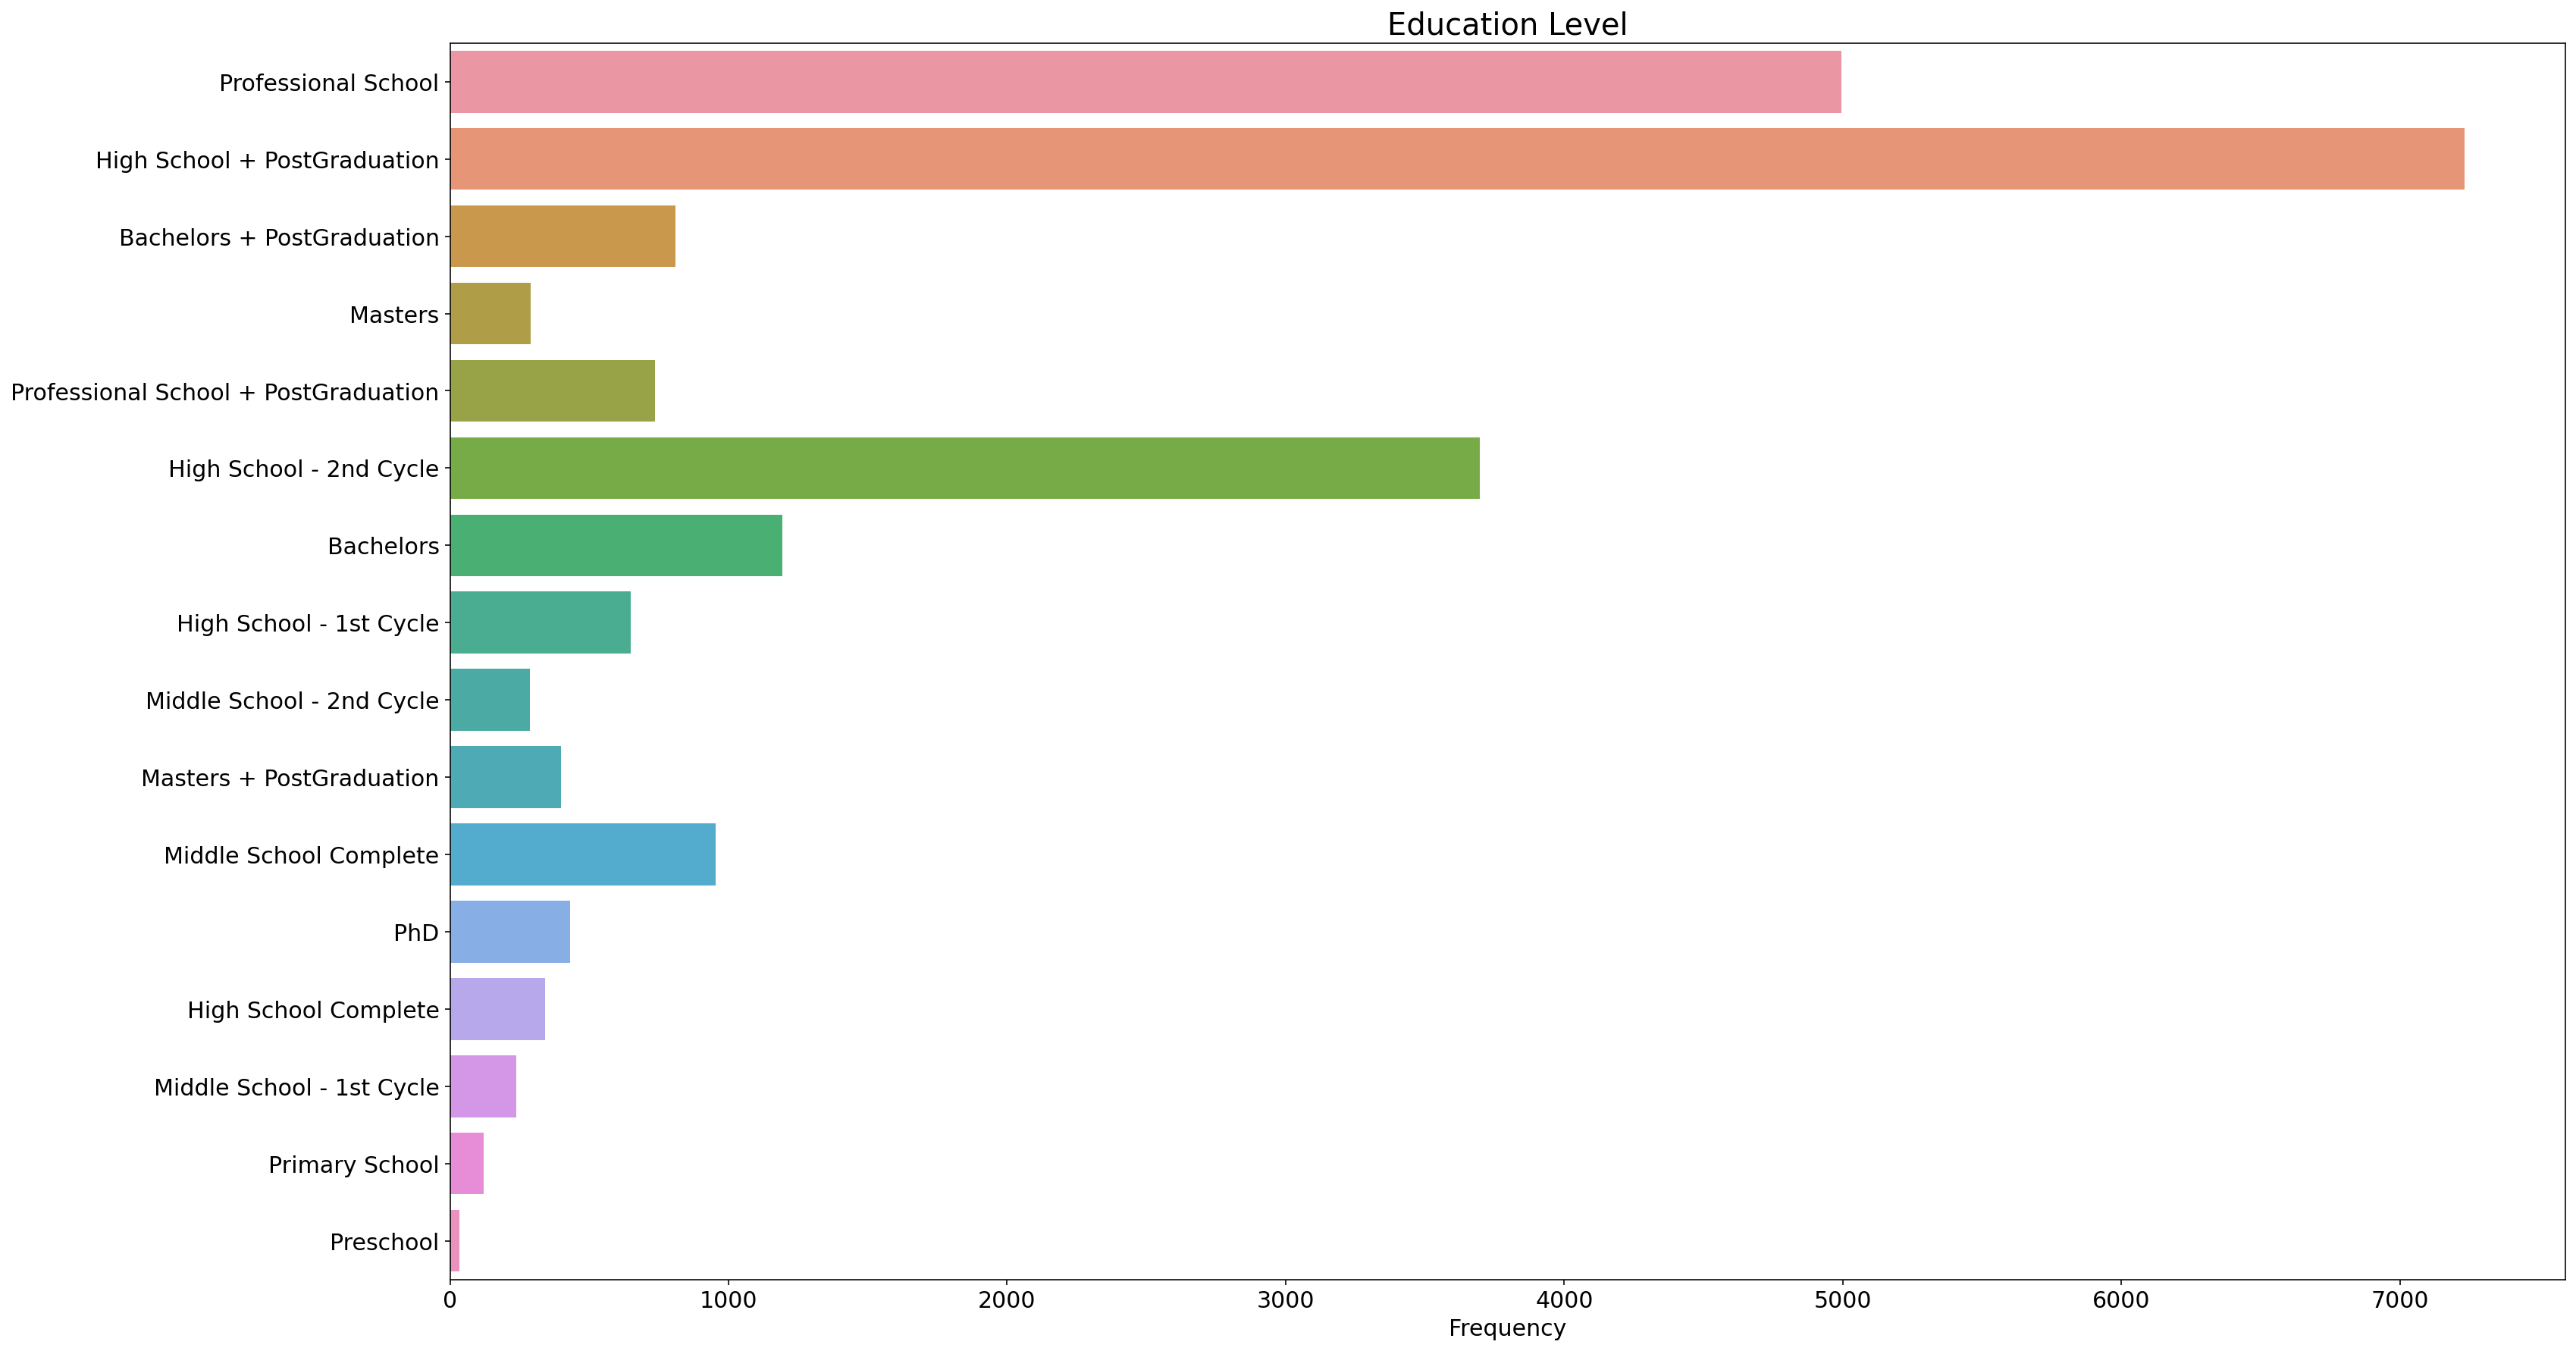

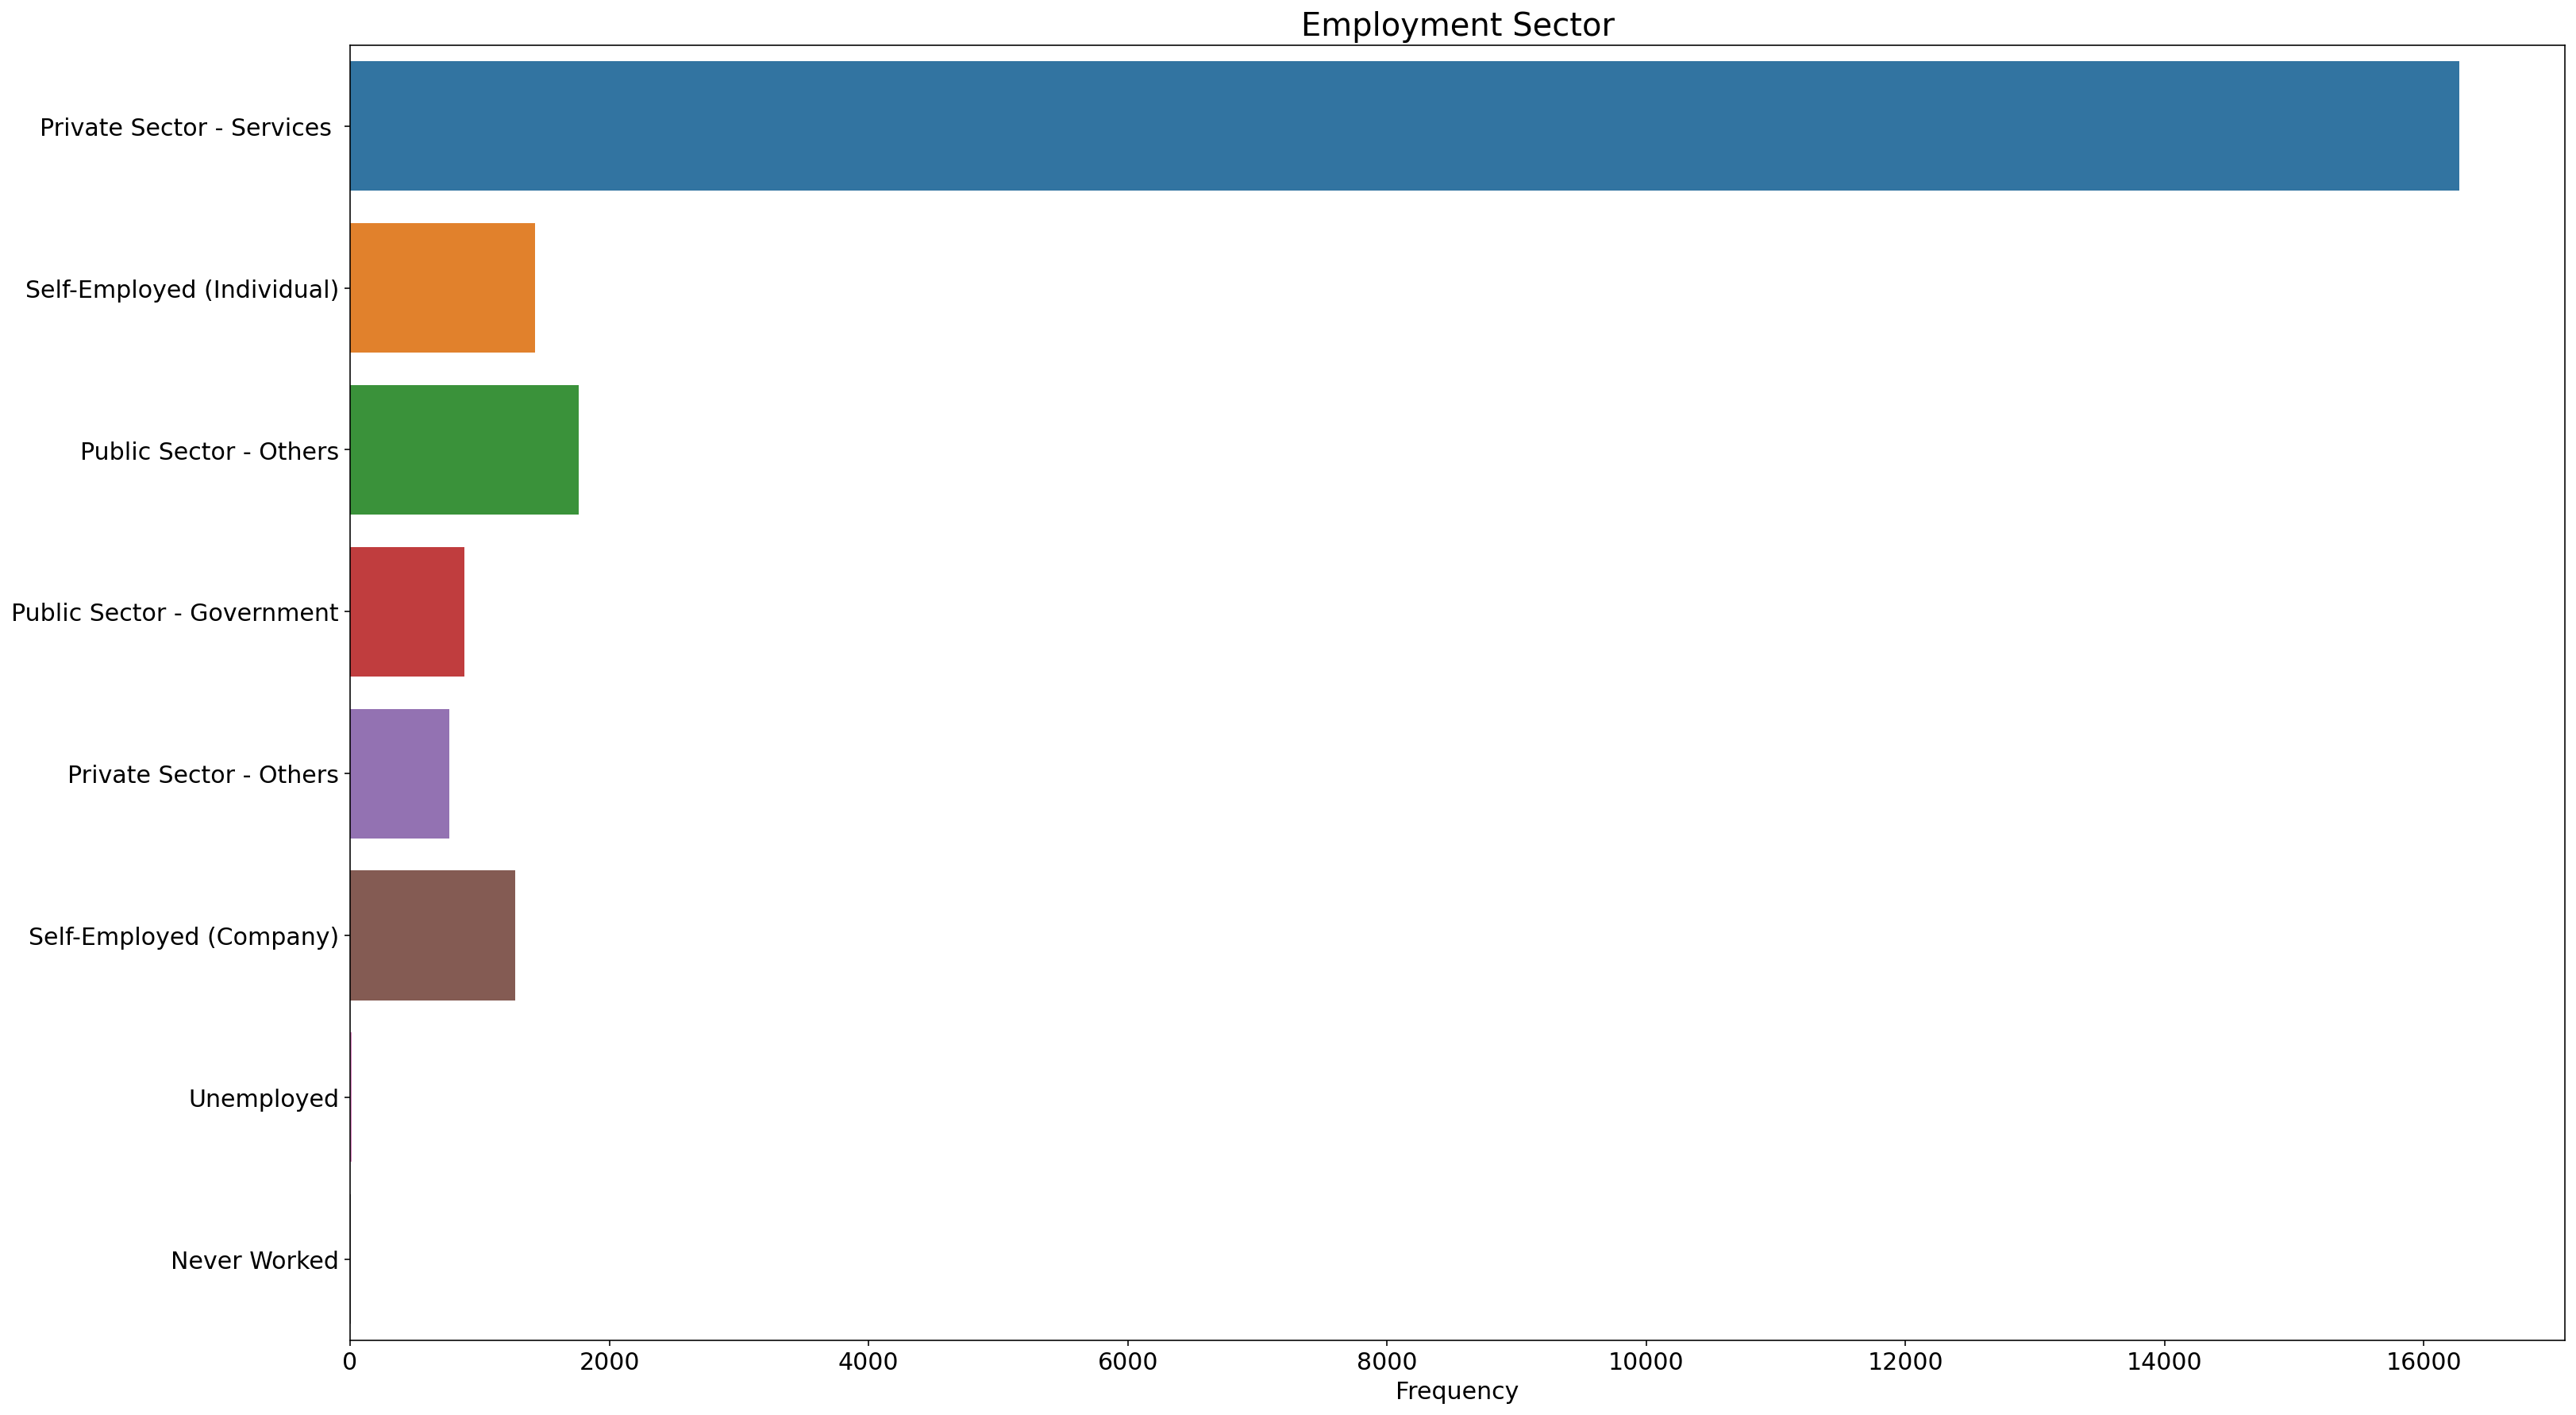

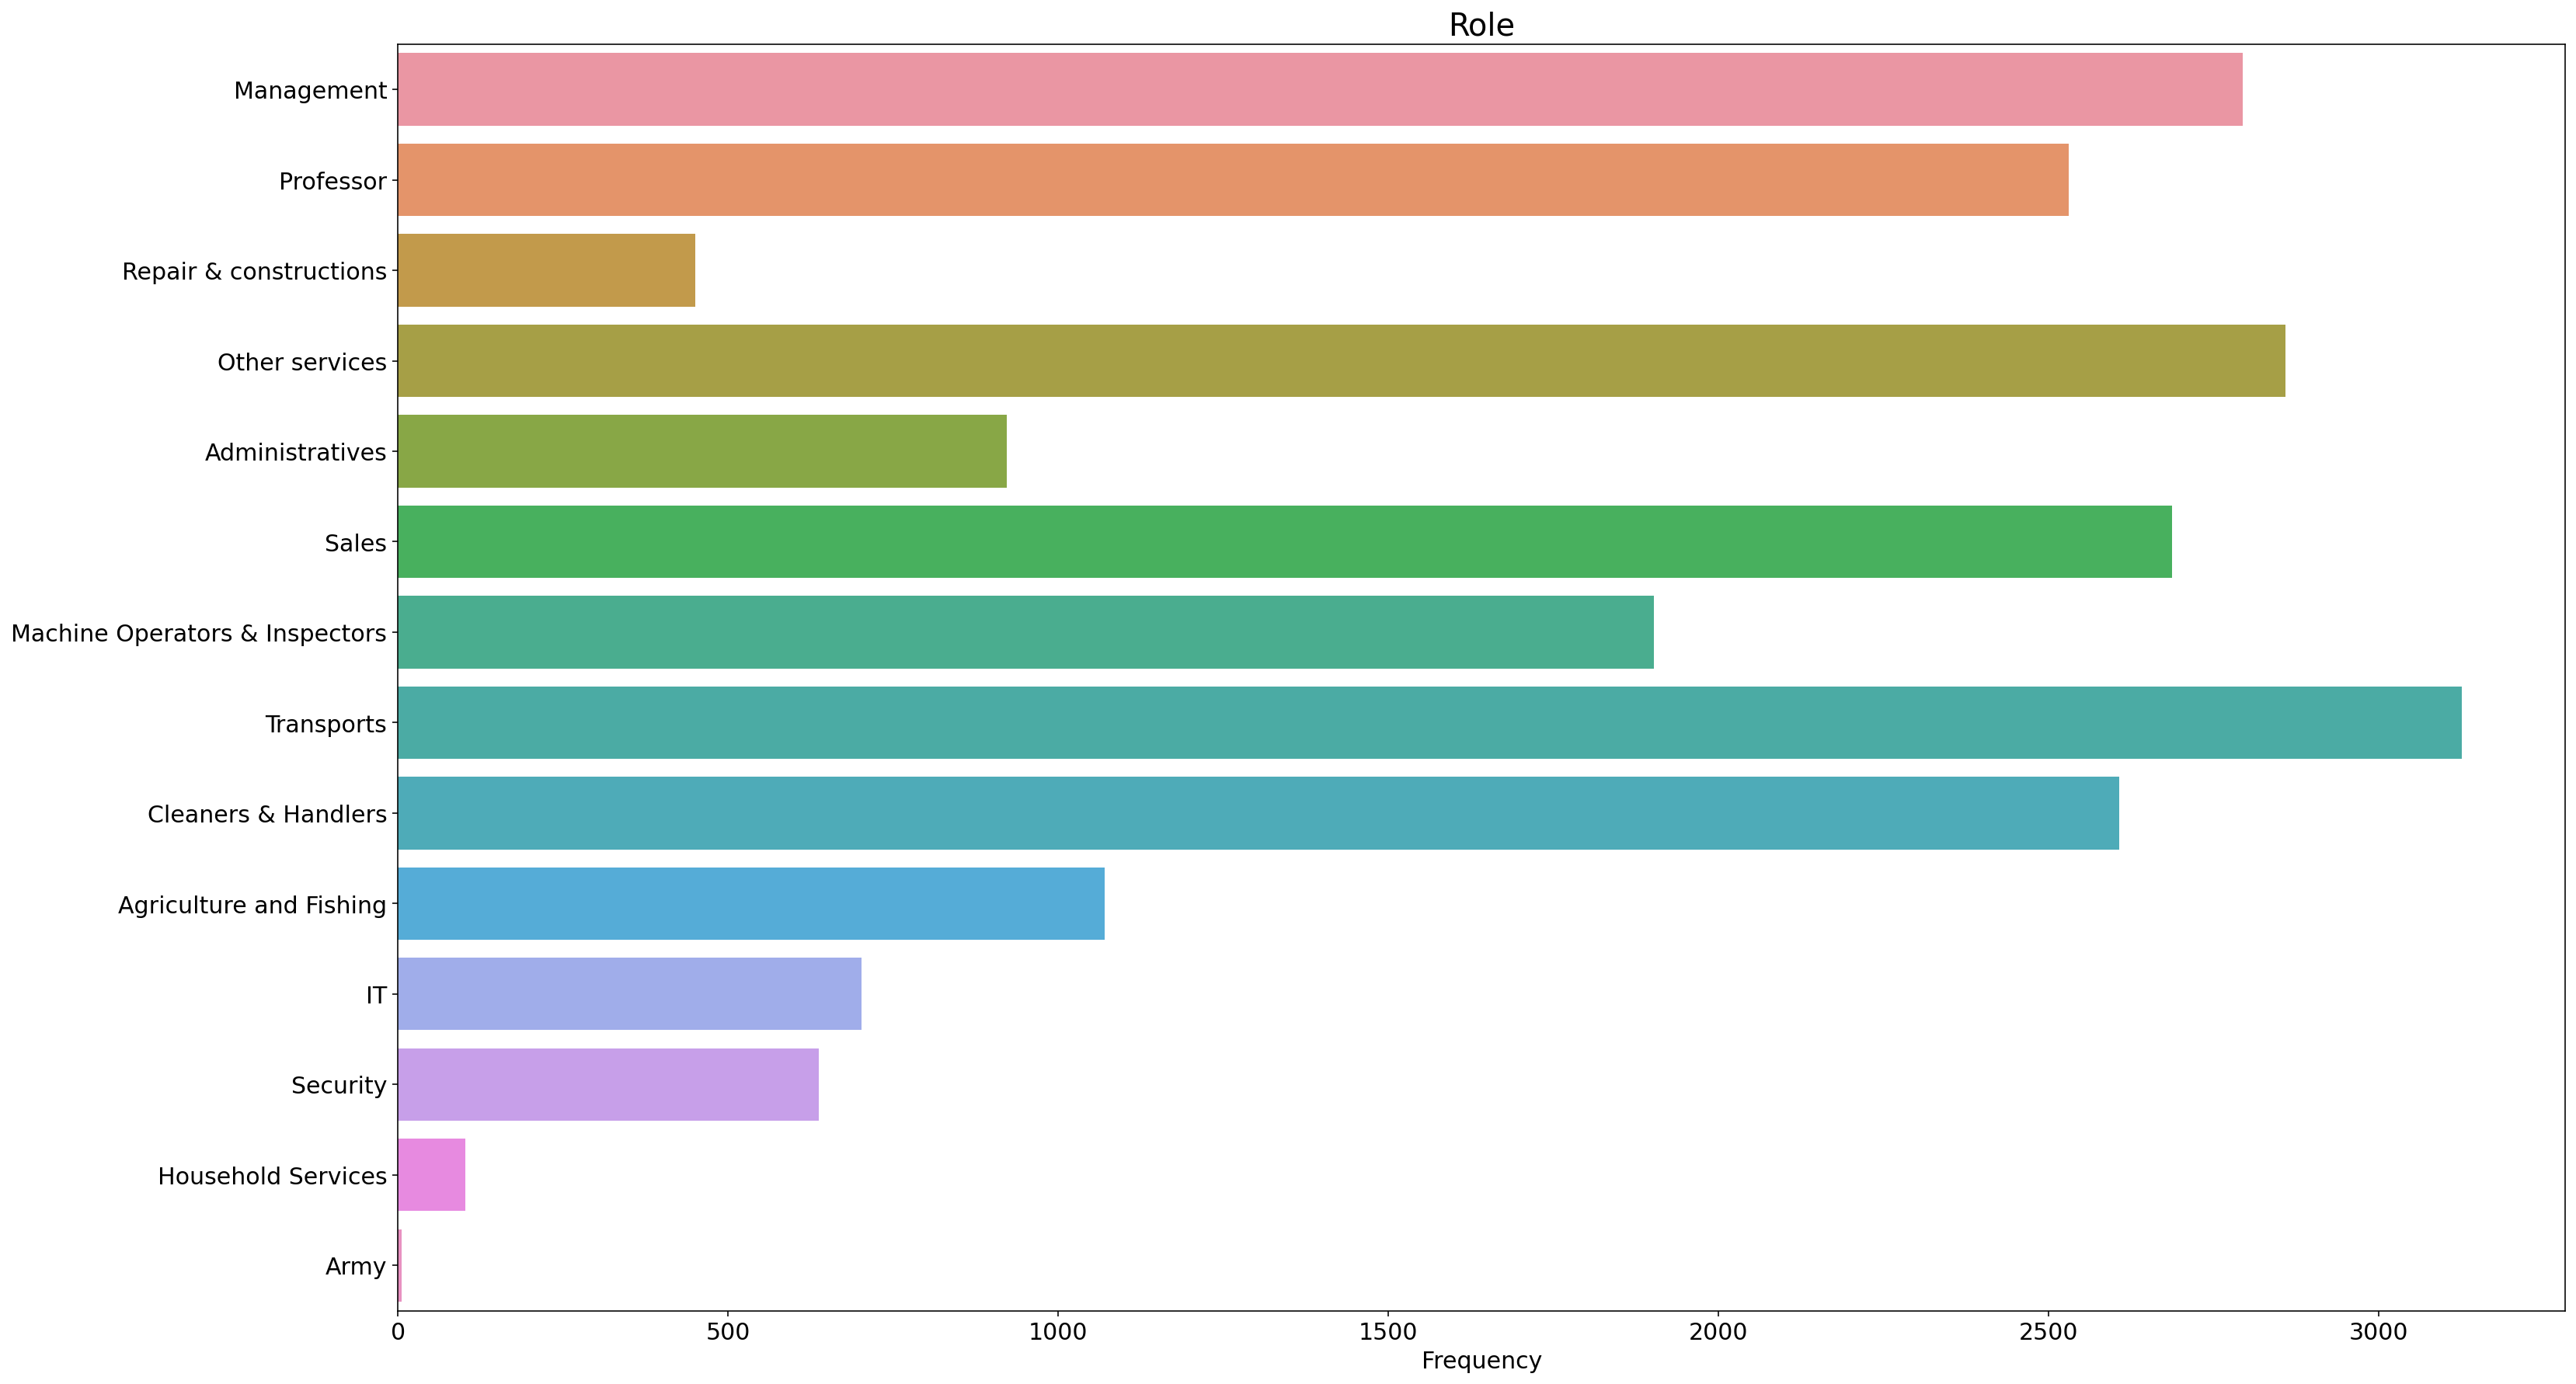

In [27]:
#countplot for categorical features
non_metric_data=train_upd.select_dtypes(include='object')

for i in non_metric_data.columns:
    plt.figure(figsize=(25,15))
    plt.title(i,fontsize=20)

    axes=sns.countplot(y=i, linewidth=2, data=non_metric_data)
    axes.set_yticklabels(list(non_metric_data.loc[:,i].value_counts().index), size=15)
    
    plt.rc('xtick',labelsize=15) 
    plt.xlabel('Frequency',fontsize=15)
    plt.ylabel('')
    plt.show()

In [28]:
#getting phi_k correlation matrix from pandas profiling
def get_phi_k_corr(df,title):
    profile=ProfileReport(df.iloc[:,1:], title=title)
    phi_k=pd.DataFrame([])
    dict=profile.description_set
    
    for keys,values in dict.items():
            try:
                for keys_ in dict.get(keys).keys():
                    try:
                        if keys_=='phi_k':
                            phi_k= pd.concat([phi_k,dict.get(keys).get(keys_)])
                    except AttributeError as e:
                        pass
            except AttributeError as e:
                pass
    return phi_k

In [33]:
#print correlation matrix
def print_corr_matrix(df,title):
    plt.title(title, size=20)
    mask = np.triu(np.ones_like(df, dtype=np.bool))
    sns.set(rc={'figure.figsize':(15,8)})
    sns.heatmap(df,
                xticklabels=df.columns,
                yticklabels=df.columns, 
                annot=True, 
                linewidths=.5, 
                vmin = -1.0,
                vmax = 1.0,
                mask = mask,
                cmap=sns.diverging_palette(-10, 240, sep=70, n=7),
                fmt='.2')
    plt.show()

In [30]:
#get pairwise correlation
def pairwise_corr(df,tol):
    for c in df:
        aCol,aVar=[],[]
        for i in range(len(df)):
            temp=df[df.keys()[i]].copy()
            if abs(df[c][i])==1.0 and c!=df.keys()[i]: nCorr=0
            else: nCorr=(1 if abs(df[c][i])>tol else -1)*abs(temp[df.keys()[i]])
            aCol.append(nCorr)
            aVar.append(df.keys()[i])
        mask=np.ones(len(aCol), dtype='bool')
        nRemove=0
        
        for n,j in enumerate(aCol):
            mask[n] = not(j!=max(aCol) and j>=0)
            if j != max(aCol) and j>=0:
                df.pop('%s' %aVar[n])
                temp.pop('%s' %aVar[n])
                nRemove+=1
        df=df[mask]
    return df

In [31]:
#for c in phi_k.keys().values: phi_k_abs.append(abs(phi_k.loc[:,c]))
#pairwise_corr(phi_k,0.7)

# 4.3 Split dataset based on group types

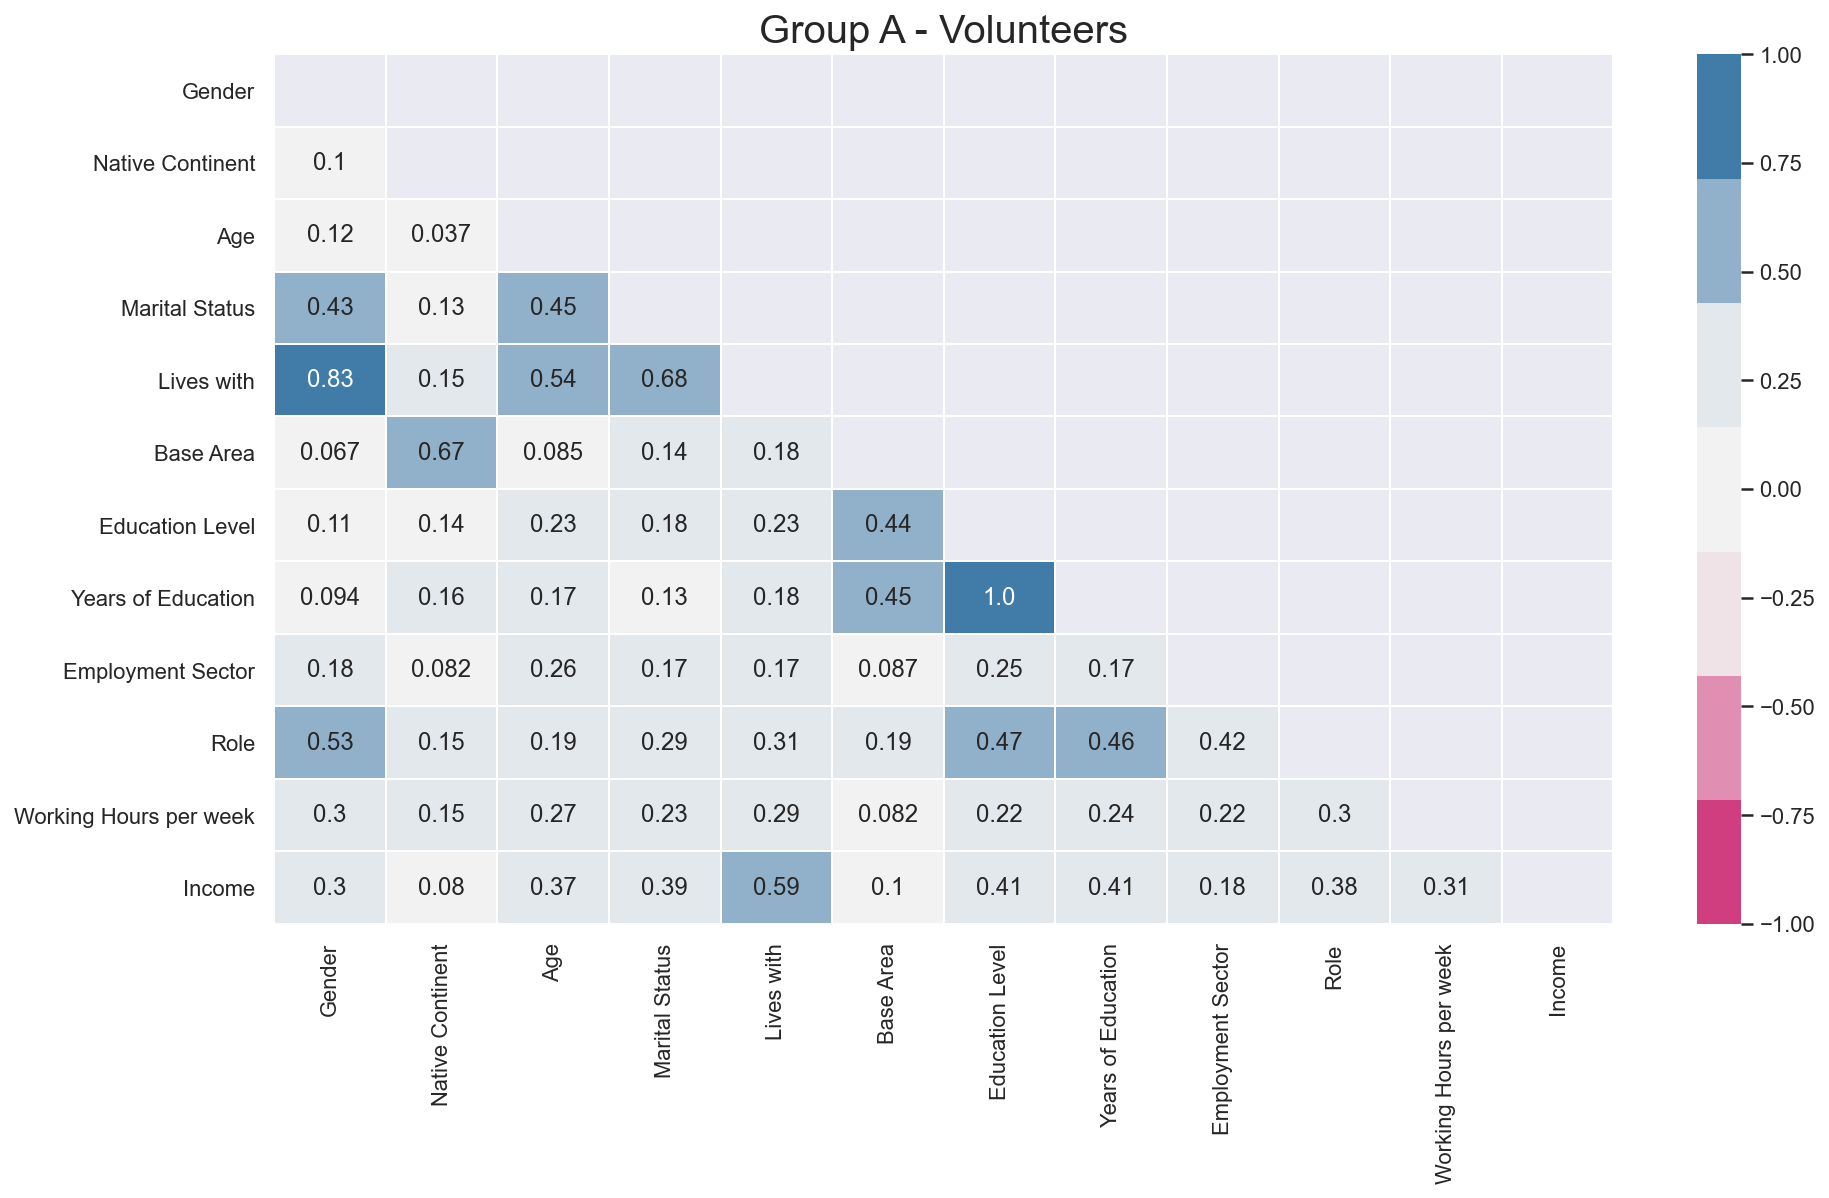

Income                    1.000000
Lives with                0.586095
Education Level           0.411534
Years of Education        0.408981
Marital Status            0.390183
Role                      0.377633
Age                       0.371202
Working Hours per week    0.308169
Gender                    0.302077
Employment Sector         0.179437
Base Area                 0.100856
Native Continent          0.080031
Name: Income, dtype: float64

In [34]:
#Group A: Volunteers
train_upd_a=train_upd[(train_upd['Ticket Price']==0) & (train_upd['Money Received']==0)].copy()
train_upd_a.reset_index(inplace=True)
train_upd_a.drop(train_upd_a.columns[0],axis=1,inplace=True)
#get correlation matrix
phi_k_a=get_phi_k_corr(train_upd_a,'')
#print matrix
print_corr_matrix(phi_k_a,'Group A - Volunteers')
phi_k_a.loc[:,'Income'].sort_values(ascending=False)

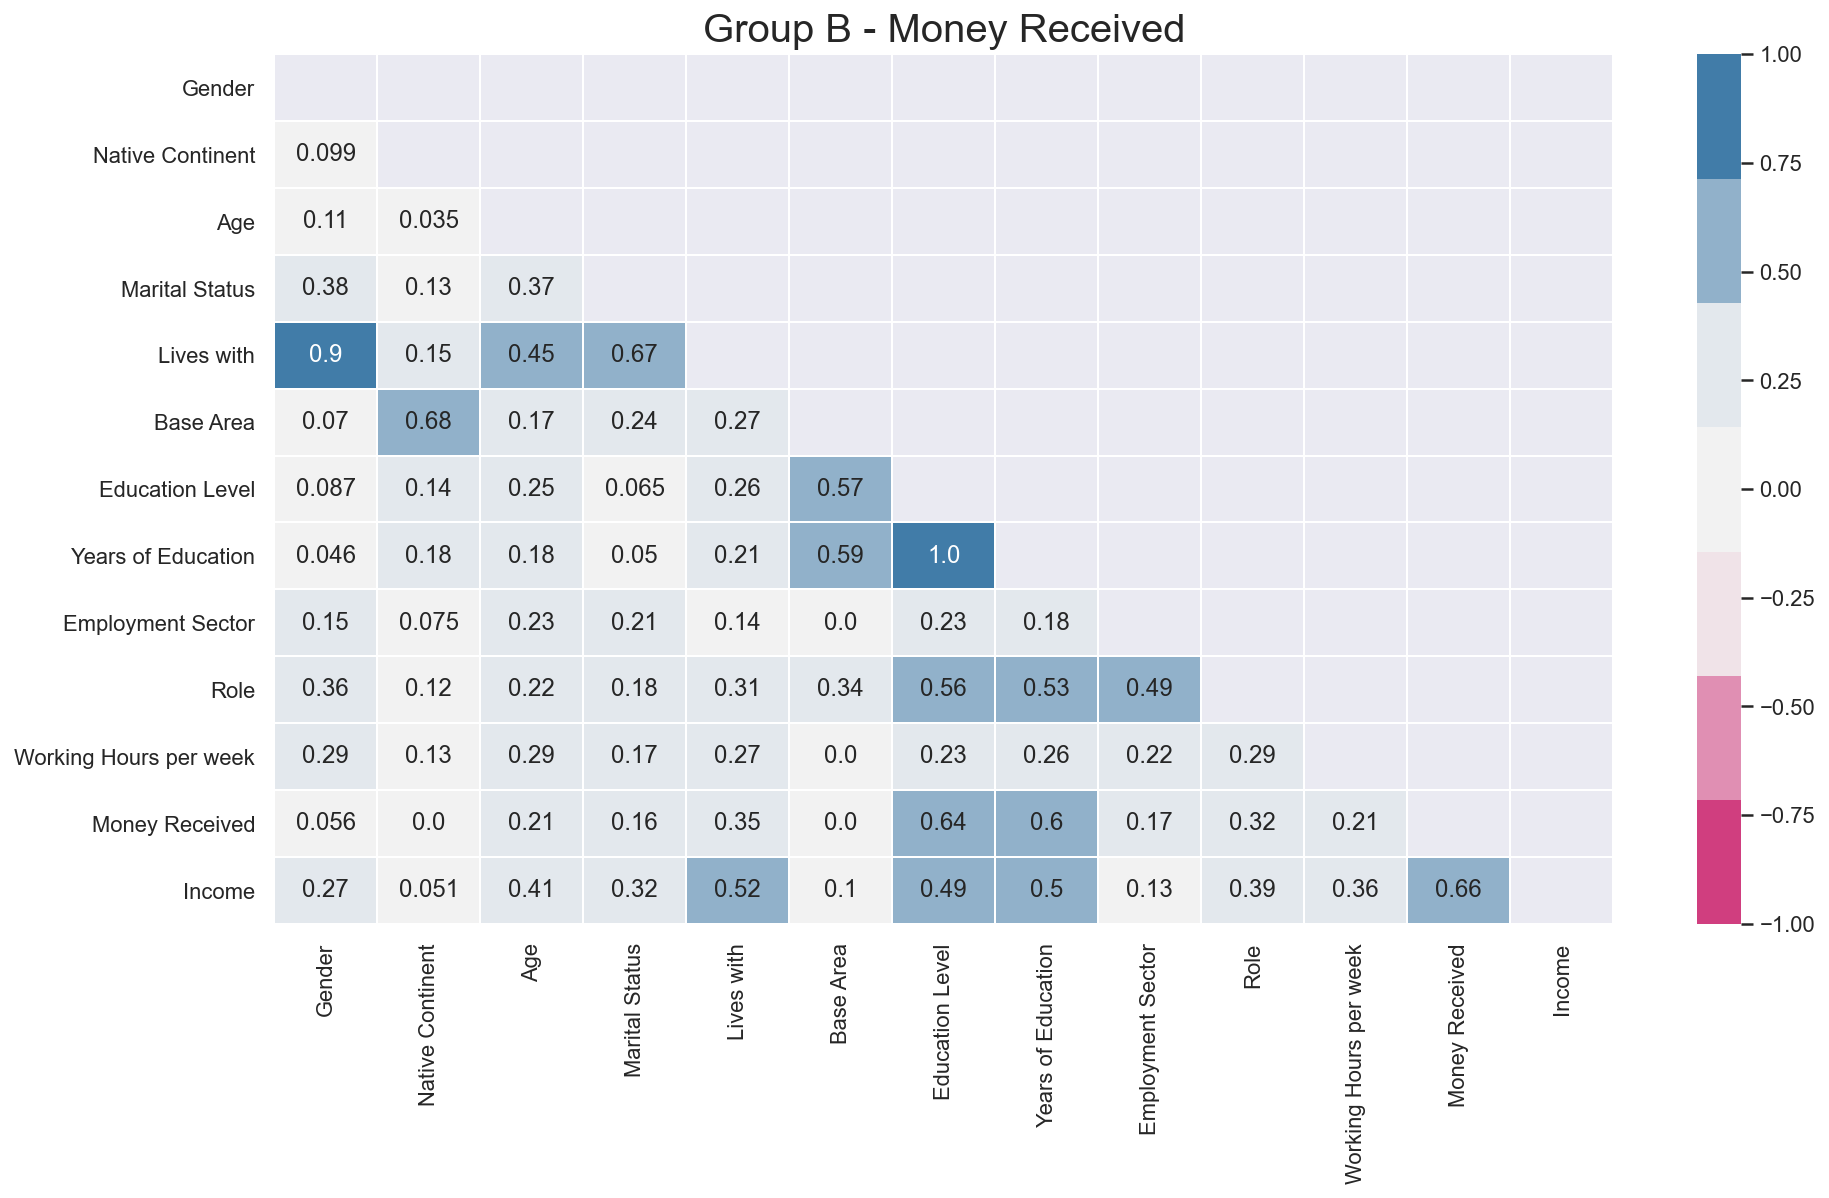

Income                    1.000000
Money Received            0.660613
Lives with                0.517797
Years of Education        0.495102
Education Level           0.488648
Age                       0.408580
Role                      0.388146
Working Hours per week    0.358737
Marital Status            0.320688
Gender                    0.274763
Employment Sector         0.128742
Base Area                 0.103197
Native Continent          0.050931
Name: Income, dtype: float64

In [35]:
#Group B: Money Received
train_upd_b=train_upd[train_upd['Money Received']>0].copy()
train_upd_b.reset_index(inplace=True)
train_upd_b.drop(train_upd_b.columns[0],axis=1,inplace=True)
#get correlation matrix
phi_k_b=get_phi_k_corr(train_upd_b,'')
#print matrix
print_corr_matrix(phi_k_b,'Group B - Money Received')
phi_k_b.loc[:,'Income'].sort_values(ascending=False)

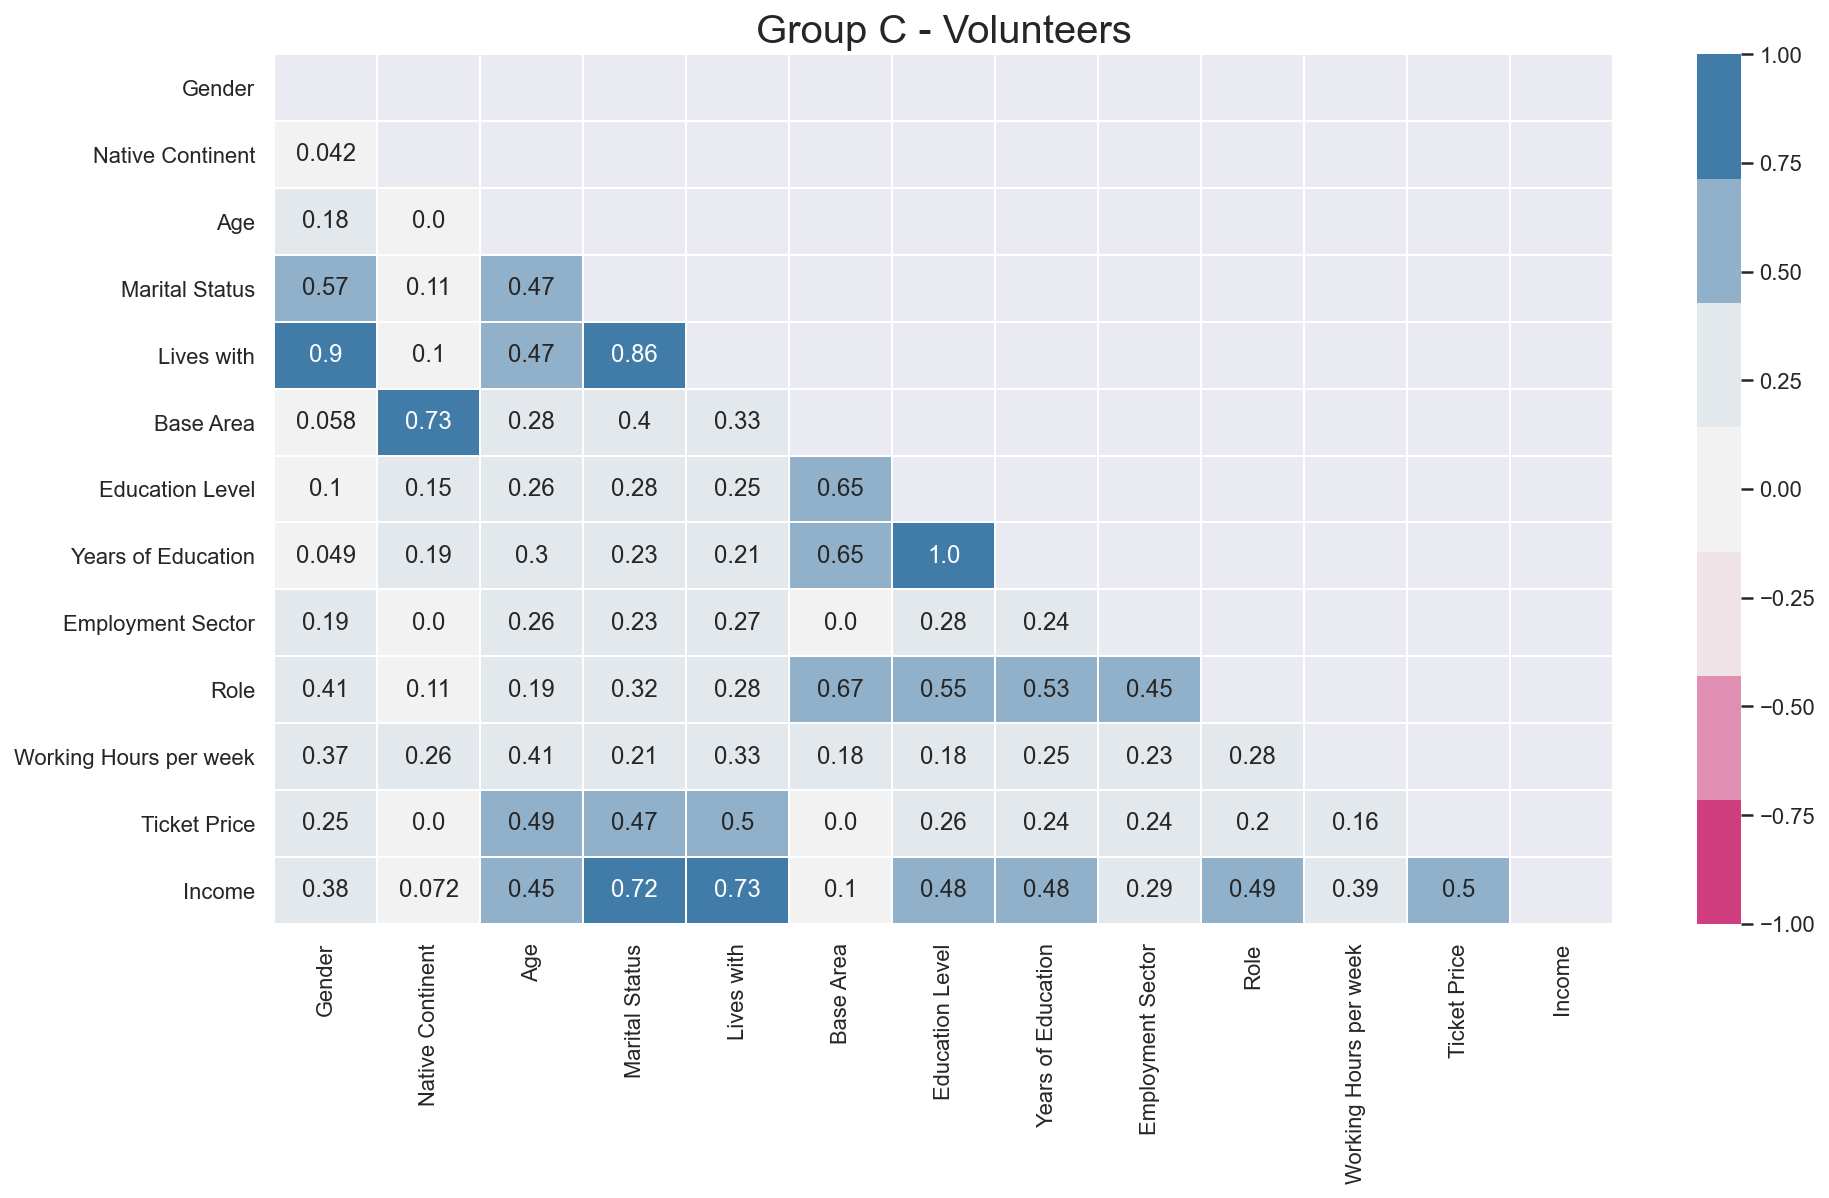

Income                    1.000000
Lives with                0.732715
Marital Status            0.722570
Ticket Price              0.501141
Role                      0.488935
Years of Education        0.482735
Education Level           0.479631
Age                       0.453034
Working Hours per week    0.385629
Gender                    0.376127
Employment Sector         0.286403
Base Area                 0.099534
Native Continent          0.071752
Name: Income, dtype: float64

In [36]:
#Group C: Buy Entry -> Ticket Price
train_upd_c=train_upd[train_upd['Ticket Price']>0].copy()
train_upd_c.reset_index(inplace=True)
train_upd_c.drop(train_upd_c.columns[0],axis=1,inplace=True)
#get correlation matrix
phi_k_c=get_phi_k_corr(train_upd_c,'')
#print matrix
print_corr_matrix(phi_k_c,'Group C - Volunteers')
phi_k_c.loc[:,'Income'].sort_values(ascending=False)

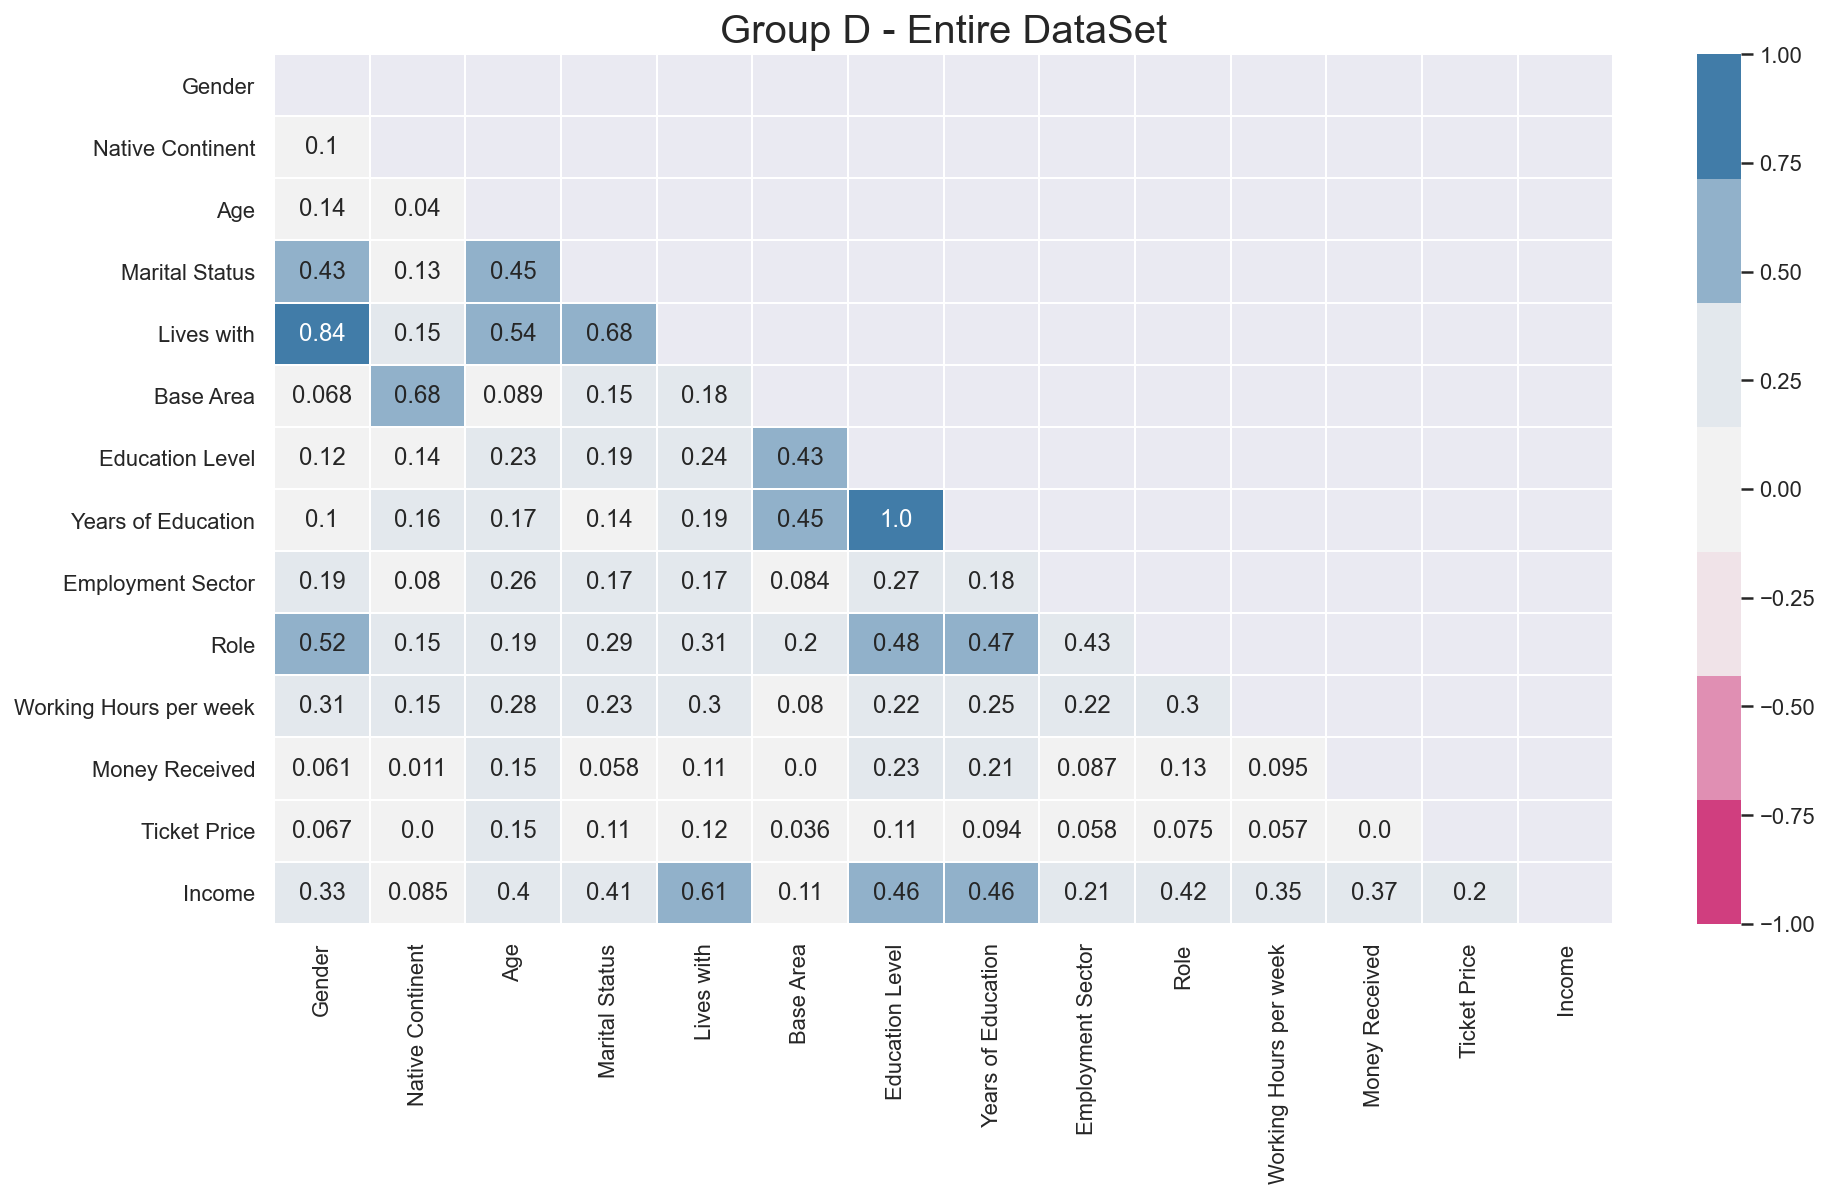

Income                    1.000000
Lives with                0.613506
Education Level           0.460428
Years of Education        0.459682
Role                      0.421604
Marital Status            0.408871
Age                       0.403309
Money Received            0.374297
Working Hours per week    0.345269
Gender                    0.325092
Employment Sector         0.206612
Ticket Price              0.203472
Base Area                 0.111442
Native Continent          0.084513
Name: Income, dtype: float64

In [37]:
#Group D: Entire dataset
train_upd_d=train_upd.copy()
phi_k_d=get_phi_k_corr(train_upd,'')
print_corr_matrix(phi_k_d,'Group D - Entire DataSet')
phi_k_d.loc[:,'Income'].sort_values(ascending=False)

# 4.4 Removing the Outliers

In [38]:
def data_normalization(df,index):
    main_df = df.copy().set_index(index)
    metric_df = main_df.select_dtypes(exclude='object')
    #Declare Instances for QT & Yeo-Johnson
    yj = prep.PowerTransformer(method='yeo-johnson')
    qt = prep.QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=np.random.RandomState(104))
    #Fit into QT & Yeo-Johnson
    X_trans_yj = yj.fit_transform(metric_df)
    X_trans_qt = qt.fit_transform(metric_df)
    #Merging 
    X_trans = np.concatenate((X_trans_yj, X_trans_qt), axis=1)
    #Creating DataFrame
    merge_labels = list(map(lambda x: "yj_" + x, metric_df.columns.to_list()))+list(map(lambda x: "qt_" + x, metric_df.columns.to_list()))
    trans_df = pd.DataFrame(X_trans, columns=merge_labels, index=metric_df.index)
    #Get Standarized DataFrames
    transqt_df = trans_df.loc[:,[i for i in trans_df.columns.to_list() if "qt" in i]]
    transyj_df = trans_df.loc[:,[i for i in trans_df.columns.to_list() if "yj" in i]]
    return transqt_df, transyj_df

In [39]:
def out_mahalanobis(data, random, contamination=0.03):
    n = data.shape[0]
    df = data.shape[1]
    #Obtain mahalanobis distance of each observation to the center and then sort it
    ee_out = cov.EllipticEnvelope(contamination=0.2, support_fraction=0.95, random_state=np.random.RandomState(304)).fit(data)
    mahalan = ee_out.mahalanobis(data)
    #Obtain chi-square percentiles of each observations
    quantiles = chi2.ppf(q=np.fromfunction(lambda x:(x-0.5)/n, (n,)), df=df)
    #Obtain labels
    labels = ee_out.predict(data)    
    return mahalan, quantiles, labels

In [40]:
def remove_outliers(df,index):
    #Apply Data Normalization
    transqt_df, transyj_df = data_normalization(df,index)
    #Call mahalanobis
    mqt, qqt, lqt = out_mahalanobis(transqt_df, 0)
    myj, qyj, lyj = out_mahalanobis(transyj_df, 0)
    lqt_lyj = pd.DataFrame({'lqt': lqt, 'lyj': lyj}, index=df.set_index(index).index)
    #Checking outliers precentage
    inl = lqt_lyj.loc[(lqt_lyj['lqt'] == 1) & (lqt_lyj['lyj'] == 1)].sum()['lqt']
    print('Outliers Percentage: {:4.2f}%'.format(100 - inl/len(lqt_lyj) * 100))
    #Creating mask for outliers' drop
    lqt_lyj.loc[(lqt_lyj['lqt'] == 1) & (lqt_lyj['lyj'] == 1), 'mask'] = True
    lqt_lyj.fillna(False, inplace=True)
    lqt_lyj.drop(columns=['lqt', 'lyj'], inplace=True)
    #Update dataframe marking the outliers for remotion
    main_df = df.set_index(index).merge(lqt_lyj, left_index=True, right_index=True)
    clean_df = main_df.loc[main_df['mask'] == True]
    #clean_df.drop(columns=['mask'], inplace=True)
    return clean_df

In [41]:
#Dataset Normalization & Outliers Remotion - Group A
train_out_a= remove_outliers(train_upd_a,'CITIZEN_ID')

Outliers Percentage: 22.76%


In [42]:
#Dataset Normalization & Outliers Remotion - Group B
train_out_b= remove_outliers(train_upd_b,'CITIZEN_ID')

Outliers Percentage: 23.96%


In [43]:
#Dataset Normalization & Outliers Remotion - Group C
train_out_c= remove_outliers(train_upd_c,'CITIZEN_ID')

Outliers Percentage: 24.03%


In [44]:
#Dataset Normalization & Outliers Remotion - Group D
train_out_d= remove_outliers(train_upd_d,'CITIZEN_ID')

Outliers Percentage: 21.54%


# 4.5 - Feature Selection Functions

In [45]:
def prepare_input(X, X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

In [46]:
def select_features(X_train, y_train, X_test, score_type, feat, name):
    if score_type=='chi2':
        fs = SelectKBest(score_func=chis2, k=feat)
    elif score_type=='mutual_info_class':
        fs = SelectKBest(score_func=mutual_info_classif, k=feat)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    #print the score for the features
    for i in range(len(fs.scores_)):
        print('Feature {} : Score {}'.format(i, fs.scores_[i]))
    #plot scores as a graph bar
    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.title('Feature Importance: ' + name, size=25)
    plt.show()
    return X_train_fs, X_test_fs

In [47]:
def rfe_group(df):
    data = df.iloc[:,:-1]
    target = df.iloc[:,-1]
    nof_list=np.arange(1,len(data.columns)+1)  
    high_score=0
    nof=0           
    score_list =[]
    #dividing the data sets into train and validation. 
    for n in range(len(nof_list)):
        X_train, X_test, y_train, y_test = train_test_split(data,target, test_size = 0.2, random_state = 0,stratify = target)     
        #Selecting the model for the Feature selection.
        model = LogisticRegression()
        rfe = RFE(model,nof_list[n])
        X_train_rfe = rfe.fit_transform(X_train,y_train)
        X_test_rfe = rfe.transform(X_test)
        model.fit(X_train_rfe,y_train)
        
        score = model.score(X_test_rfe,y_test)
        score_list.append(score)

        if(score>high_score):
            high_score = score
            nof = nof_list[n]
    print('Optimum Number of Features: %d' %nof)
    print('\n')
    print('Score with %d features: %f' % (nof, high_score))
    rfe = RFE(estimator = model, n_features_to_select = nof)
    X_rfe = rfe.fit_transform(X = data, y = target)
    model = LogisticRegression().fit(X = X_rfe,y = target)
    selected_features = pd.Series(rfe.support_, index = data.columns)
    print(selected_features)
    ridge = RidgeClassifierCV().fit(X = data,y = target)
    coef_ridge = pd.Series(ridge.coef_[0], index = data.columns)
    return coef_ridge

In [48]:
#Ploting the features importance with ridge regression. 
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(12,10))
    imp_coef.plot(kind = 'barh')
    plt.title('Feature Importance: ' + name, size=20)
    plt.show()

# 4.6 - Applying Feature Selection Techniques

### 4.6.1 - Chi-Square

Feature 0 : Score 625.5850926310211
Feature 1 : Score 27.79894657418708
Feature 2 : Score 5373.931609196549
Feature 3 : Score 1459.2683922588174
Feature 4 : Score 1798.1951201964243
Feature 5 : Score 2.7364253933862677
Feature 6 : Score 387.09828161346127
Feature 7 : Score 345.2508009814487
Feature 8 : Score 28.232747558025228
Feature 9 : Score 273.35538134772247
Feature 10 : Score 1100.0414597677468
Feature 11 : Score nan
Feature 12 : Score nan


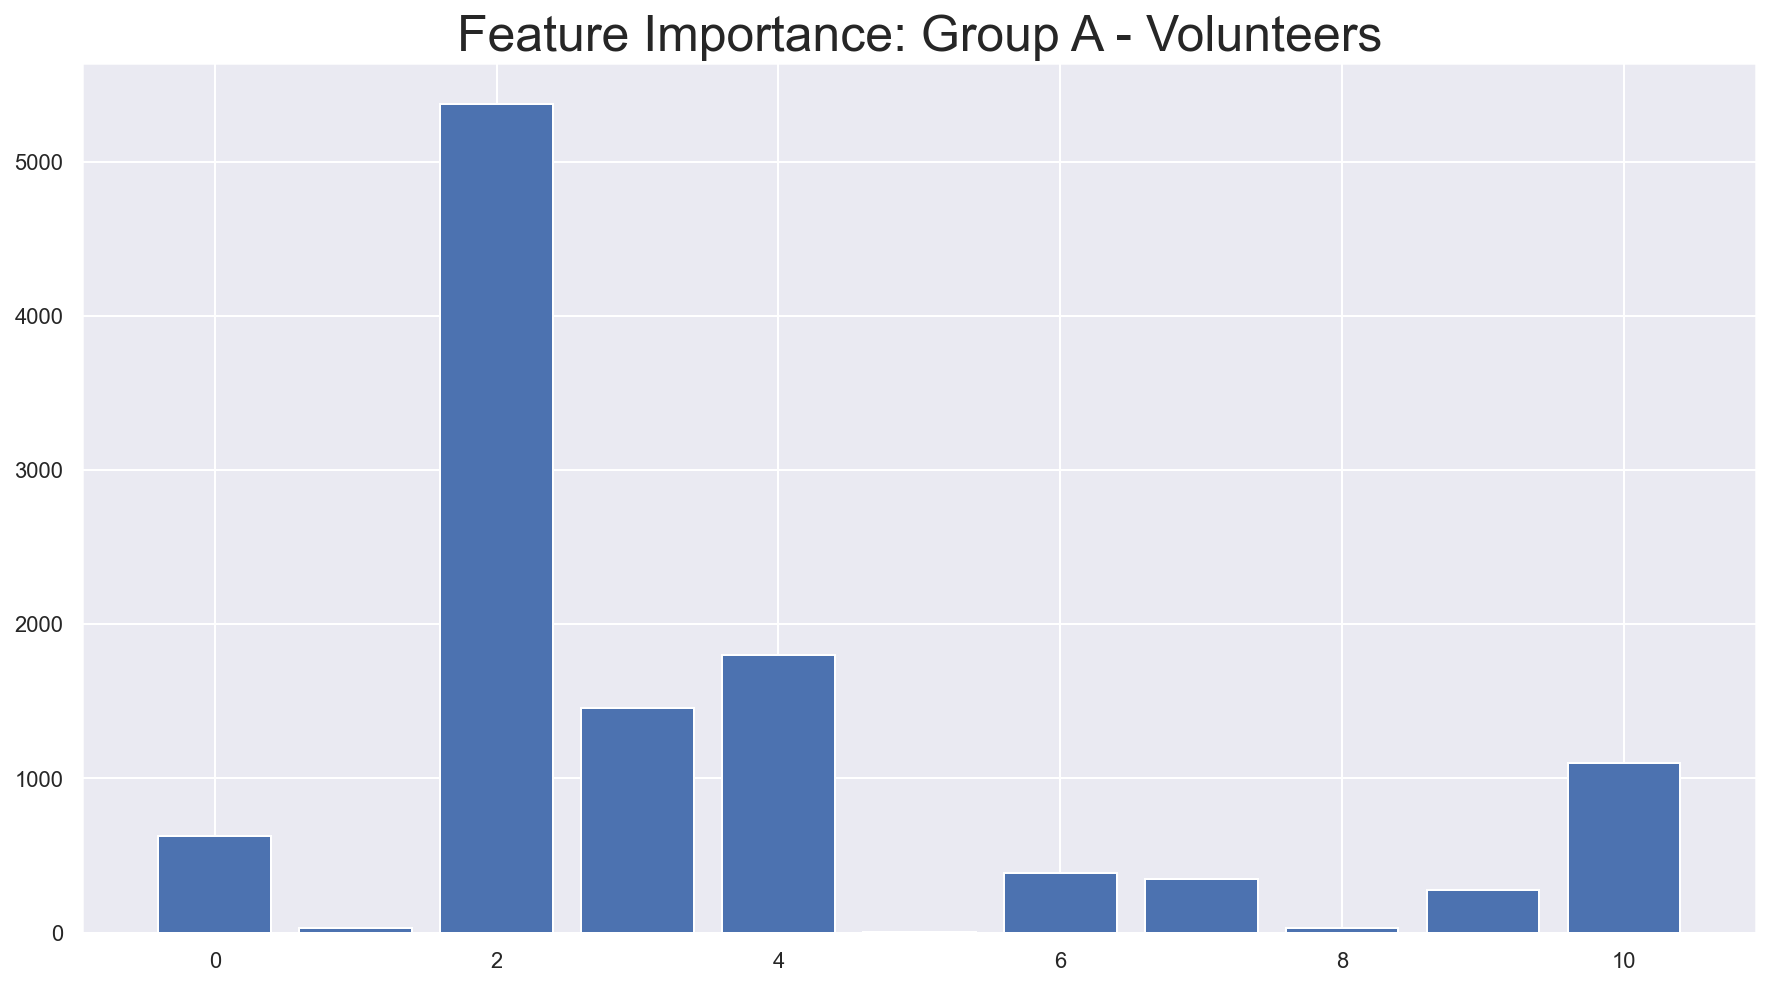

In [49]:
#Group A -> Creating a Training & Testing DataSet
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(train_out_a.iloc[:,:-1],train_out_a.iloc[:,-1], test_size=0.25, random_state=1)
#Prepare Input Data
X_train_enc_a, X_test_enc_a = prepare_input(train_out_a.iloc[:,:-1], X_train_a, X_test_a)
#Feature Selection & Plot Scores
X_train_score_a, X_test_score_a = select_features(X_train_enc_a, y_train_a.values.astype('int64'), X_test_enc_a, 'chi2', 'all', 'Group A - Volunteers')

Feature 0 : Score 19.386230577865682
Feature 1 : Score 1.4088925956070515
Feature 2 : Score 213.81590969473768
Feature 3 : Score 105.51830294488184
Feature 4 : Score 51.733418773838686
Feature 5 : Score 2.0241457329118147
Feature 6 : Score 130.0270189577341
Feature 7 : Score 85.7382960809828
Feature 8 : Score 3.7499800849879135
Feature 9 : Score 10.63221555572044
Feature 10 : Score 100.50670168035853
Feature 11 : Score 4948.634238842935
Feature 12 : Score nan


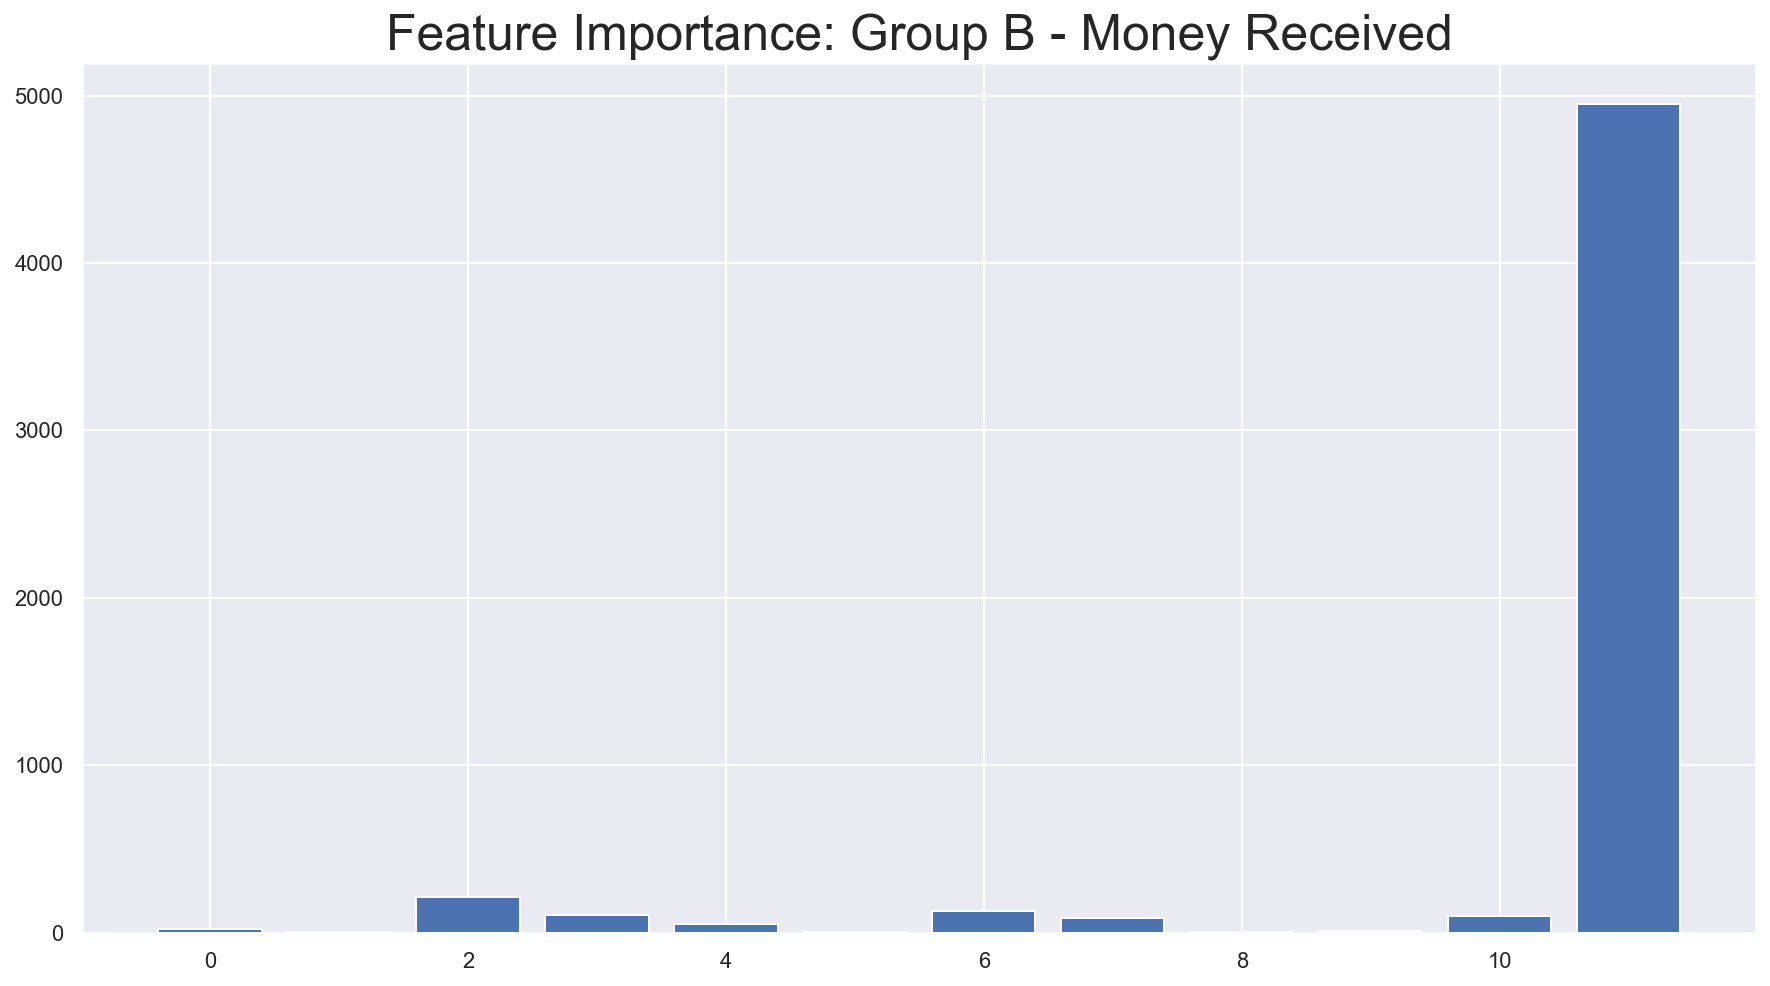

In [53]:
#Group B -> Creating a Training & Testing DataSet
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(train_out_b.iloc[:,:-1], train_out_b.iloc[:,-1], test_size=0.25, random_state=1)
#Prepare Input Data
X_train_enc_b, X_test_enc_b = prepare_input(train_out_b.iloc[:,:-1], X_train_b, X_test_b)
#Feature Selection & Plot Scores
X_train_score_b, X_test_score_b = select_features(X_train_enc_b, y_train_b.values.astype('int64'), X_test_enc_b, 'chi2','all', 'Group B - Money Received')

Feature 0 : Score 28.298782318598835
Feature 1 : Score 0.535612916999518
Feature 2 : Score 336.5304580009324
Feature 3 : Score 114.97208911076197
Feature 4 : Score 68.22565493789112
Feature 5 : Score 0.12767849424025482
Feature 6 : Score 14.34697626105643
Feature 7 : Score 40.62694858256732
Feature 8 : Score 20.382499923940827
Feature 9 : Score 4.019264354266343
Feature 10 : Score 113.31962757792269
Feature 11 : Score nan
Feature 12 : Score 441.03566046190633


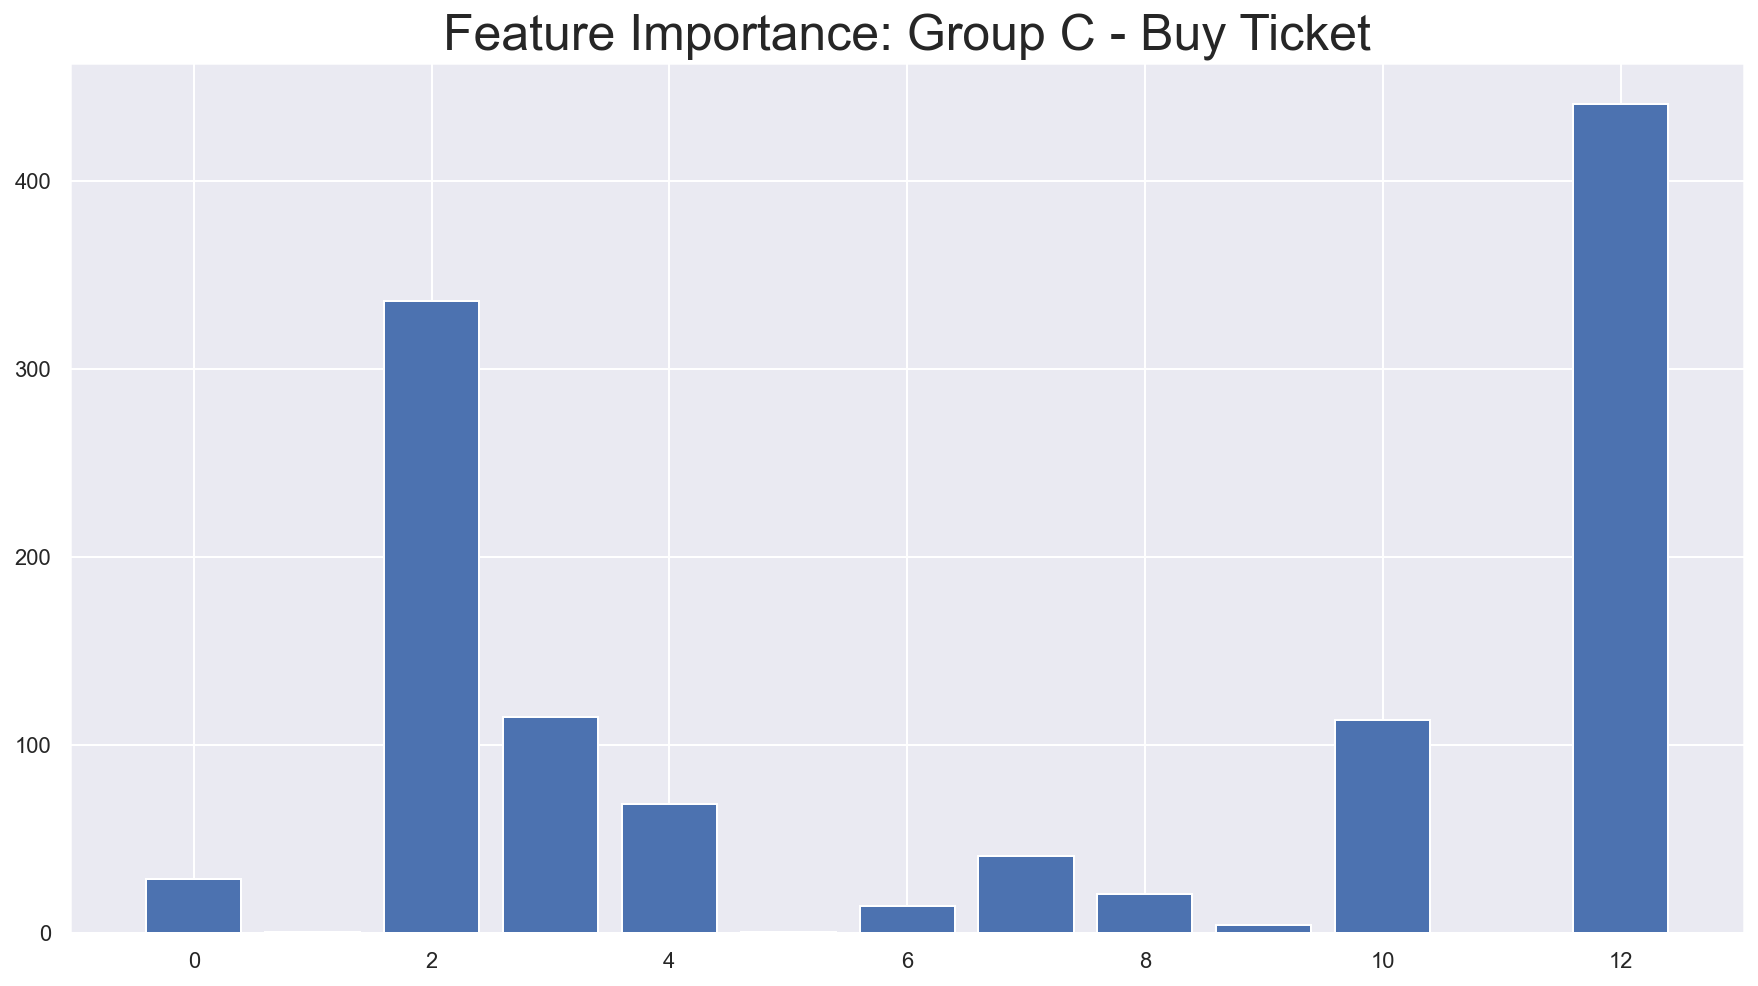

In [54]:
#Group C -> Creating a Training & Testing DataSet
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(train_out_c.iloc[:,:-1], train_out_c.iloc[:,-1], test_size=0.25, random_state=1)
#Prepare Input Data
X_train_enc_c, X_test_enc_c = prepare_input(train_out_c.iloc[:,:-1], X_train_c, X_test_c)
#Feature Selection & Plot Scores
X_train_score_c, X_test_score_c = select_features(X_train_enc_c, y_train_c.values.astype('int64'), X_test_enc_c, 'chi2', 'all', 'Group C - Buy Ticket')

Feature 0 : Score 390.33980154347614
Feature 1 : Score 36.79422898873608
Feature 2 : Score 5972.071515481777
Feature 3 : Score 1902.013344002727
Feature 4 : Score 1621.367004051303
Feature 5 : Score 3.7230224416868554
Feature 6 : Score 488.480023201546
Feature 7 : Score 528.8640256102244
Feature 8 : Score 46.92271563251197
Feature 9 : Score 296.57402282748865
Feature 10 : Score 1707.8249465594163
Feature 11 : Score nan
Feature 12 : Score nan


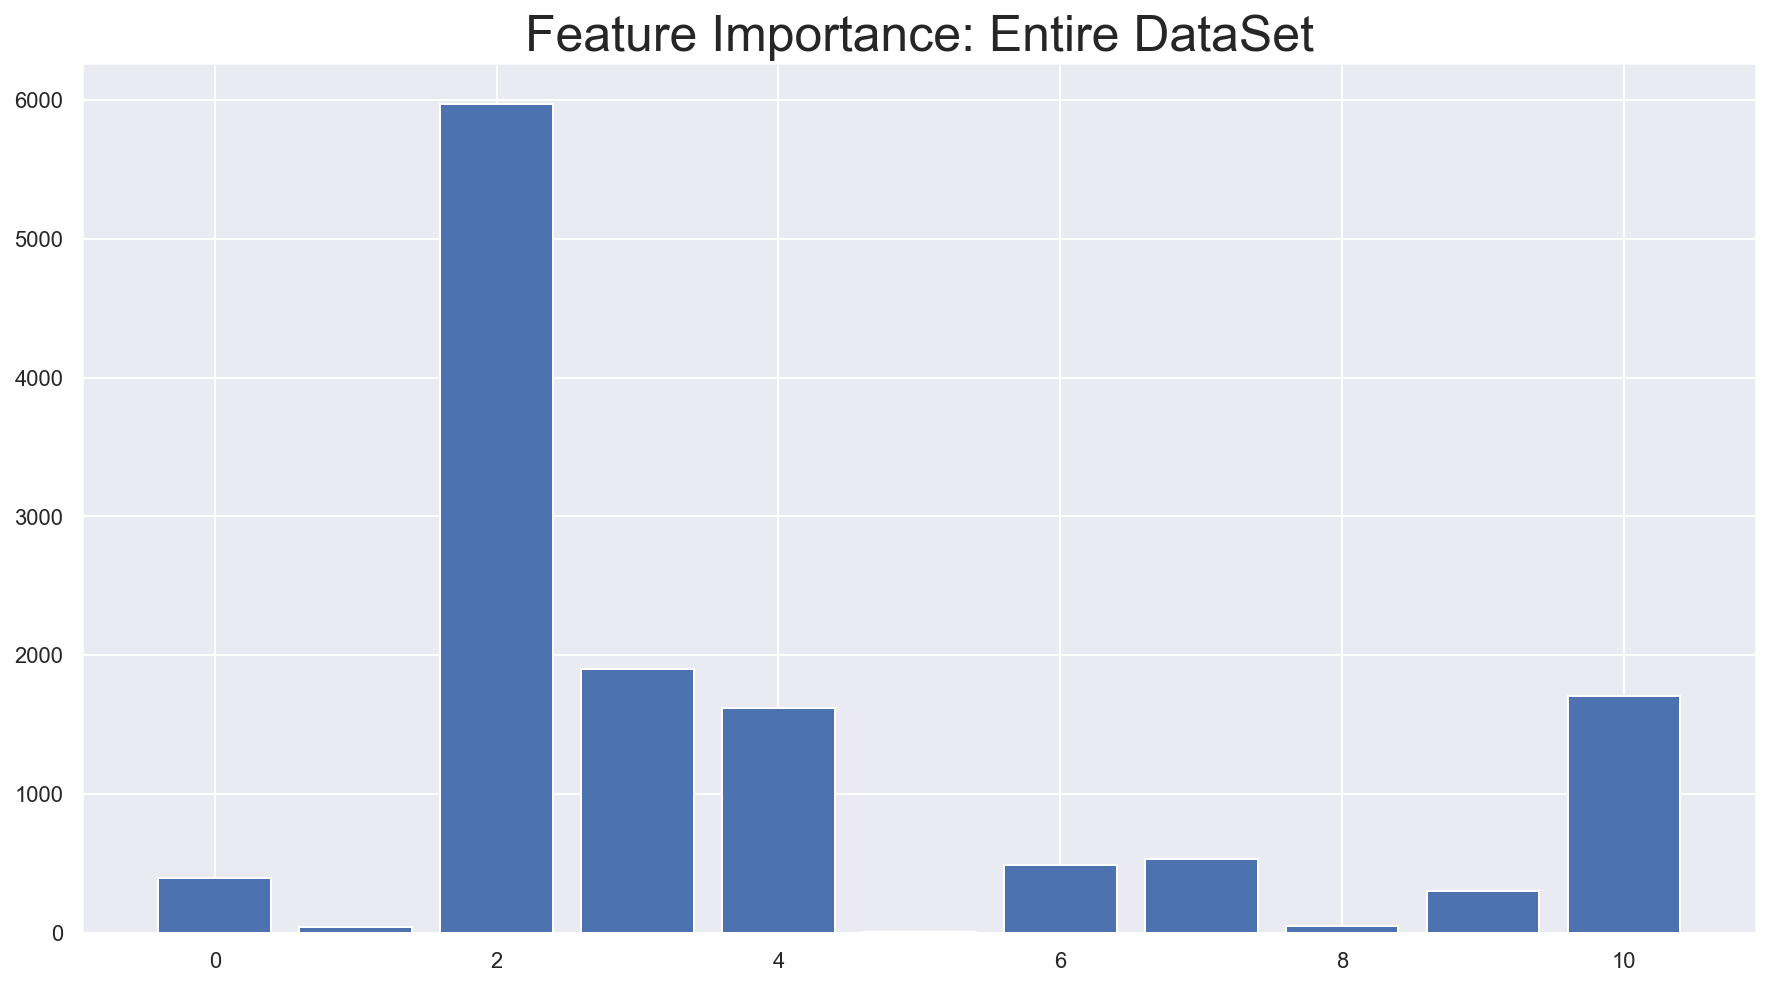

In [55]:
#Group D -> Creating a Training & Testing DataSet
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(train_out_d.iloc[:,:-1], train_out_d.iloc[:,-1], test_size=0.25, random_state=1)
#Prepare Input Data
X_train_enc_d, X_test_enc_d = prepare_input(train_out_d.iloc[:,:-1], X_train_d, X_test_d)
#Feature Selection & Plot Scores
X_train_score_d, X_test_score_d = select_features(X_train_enc_d, y_train_d.values.astype('int64'), X_test_enc_d, 'chi2', 'all' ,'Entire DataSet')

### 4.6.2 - Mutual-Info-Classification

Feature 0 : Score 0.06749780034917063
Feature 1 : Score 0.013979520442363391
Feature 2 : Score 0.05349540343339787
Feature 3 : Score 0.09129087036512451
Feature 4 : Score 0.10961245849475931
Feature 5 : Score 0.004688228500738356
Feature 6 : Score 0.0412078907620419
Feature 7 : Score 0.038397926827857365
Feature 8 : Score 0.011021841322881754
Feature 9 : Score 0.03739856574955569
Feature 10 : Score 0.03368795761541388
Feature 11 : Score 0.0
Feature 12 : Score 0.0013327596887267035


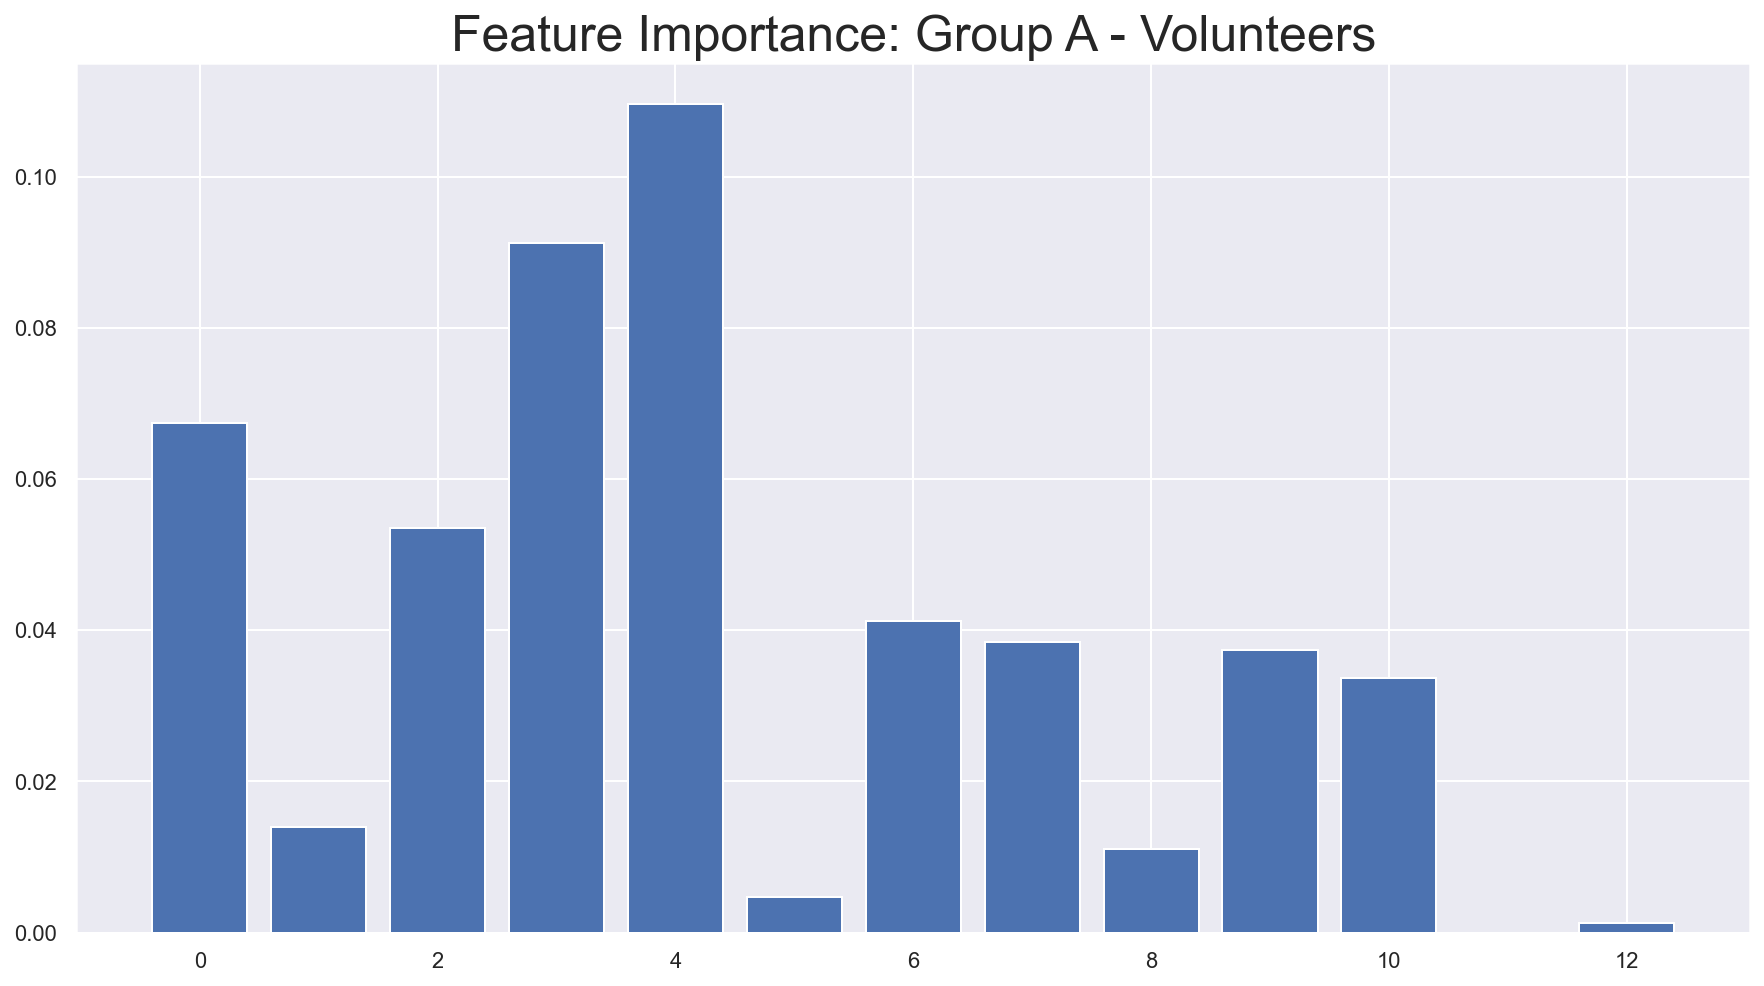

In [56]:
#Group A -> Creating a Training & Testing DataSet
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(train_out_a.iloc[:,:-1],train_out_a.iloc[:,-1], test_size=0.25, random_state=1)
#Prepare Input Data
X_train_enc_a, X_test_enc_a = prepare_input(train_out_a.iloc[:,:-1], X_train_a, X_test_a)
#Feature Selection & Plot Scores
X_train_score_a, X_test_score_a = select_features(X_train_enc_a, y_train_a.values.astype('int64'), X_test_enc_a, 'mutual_info_class', 'all', 'Group A - Volunteers')

Feature 0 : Score 0.0031013137338427033
Feature 1 : Score 0.0
Feature 2 : Score 0.04640644471998079
Feature 3 : Score 0.04912593633453599
Feature 4 : Score 0.04874144314084683
Feature 5 : Score 0.009713793628769674
Feature 6 : Score 0.08337506316685017
Feature 7 : Score 0.07001610011623605
Feature 8 : Score 0.009474576229145493
Feature 9 : Score 0.05777494425998109
Feature 10 : Score 0.018607191635606313
Feature 11 : Score 0.614152942917977
Feature 12 : Score 0.0


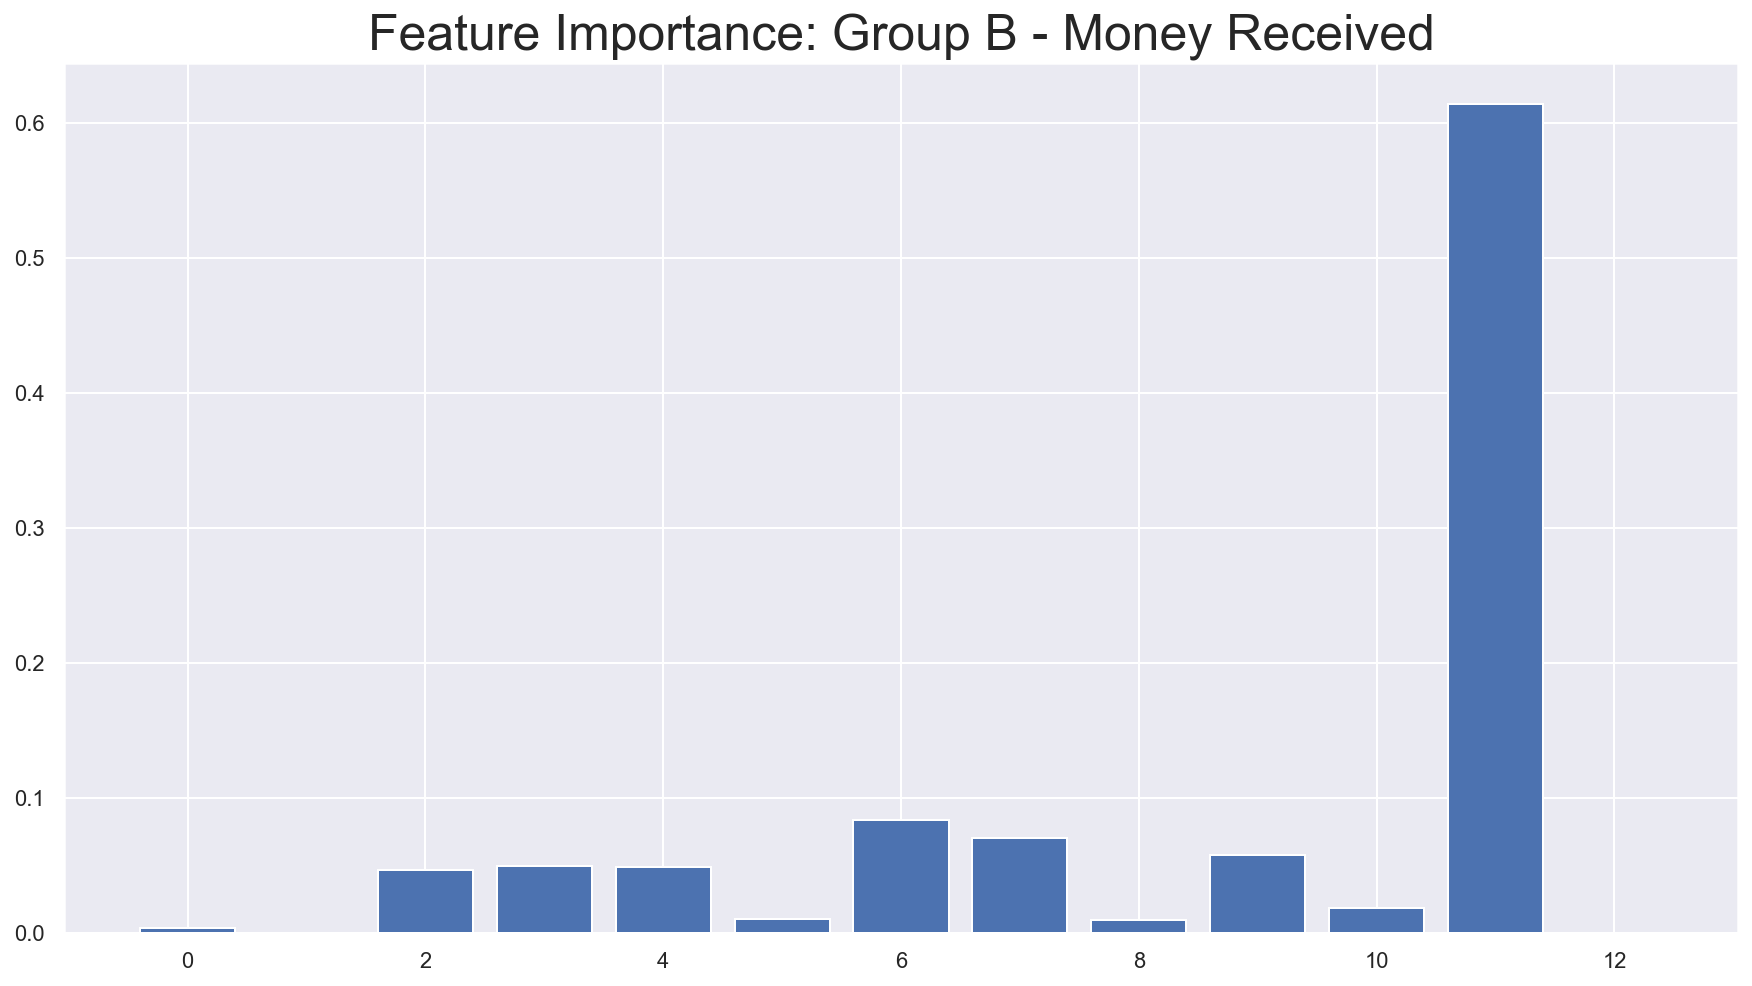

In [57]:
#Group B -> Creating a Training & Testing DataSet
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(train_out_b.iloc[:,:-1], train_out_b.iloc[:,-1], test_size=0.25, random_state=1)
#Prepare Input Data
X_train_enc_b, X_test_enc_b = prepare_input(train_out_b.iloc[:,:-1], X_train_b, X_test_b)
#Feature Selection & Plot Scores
X_train_score_b, X_test_score_b = select_features(X_train_enc_b, y_train_b.values.astype('int64'), X_test_enc_b, 'mutual_info_class', 'all', 'Group B - Money Received')

Feature 0 : Score 0.0
Feature 1 : Score 0.0
Feature 2 : Score 0.09830230372595827
Feature 3 : Score 0.1566154250601619
Feature 4 : Score 0.19322639838003952
Feature 5 : Score 0.0
Feature 6 : Score 0.09852594152086214
Feature 7 : Score 0.0773825019885741
Feature 8 : Score 0.04321269441708164
Feature 9 : Score 0.0778252200273446
Feature 10 : Score 0.05371665049656116
Feature 11 : Score 0.030627225971197936
Feature 12 : Score 0.5690854184689116


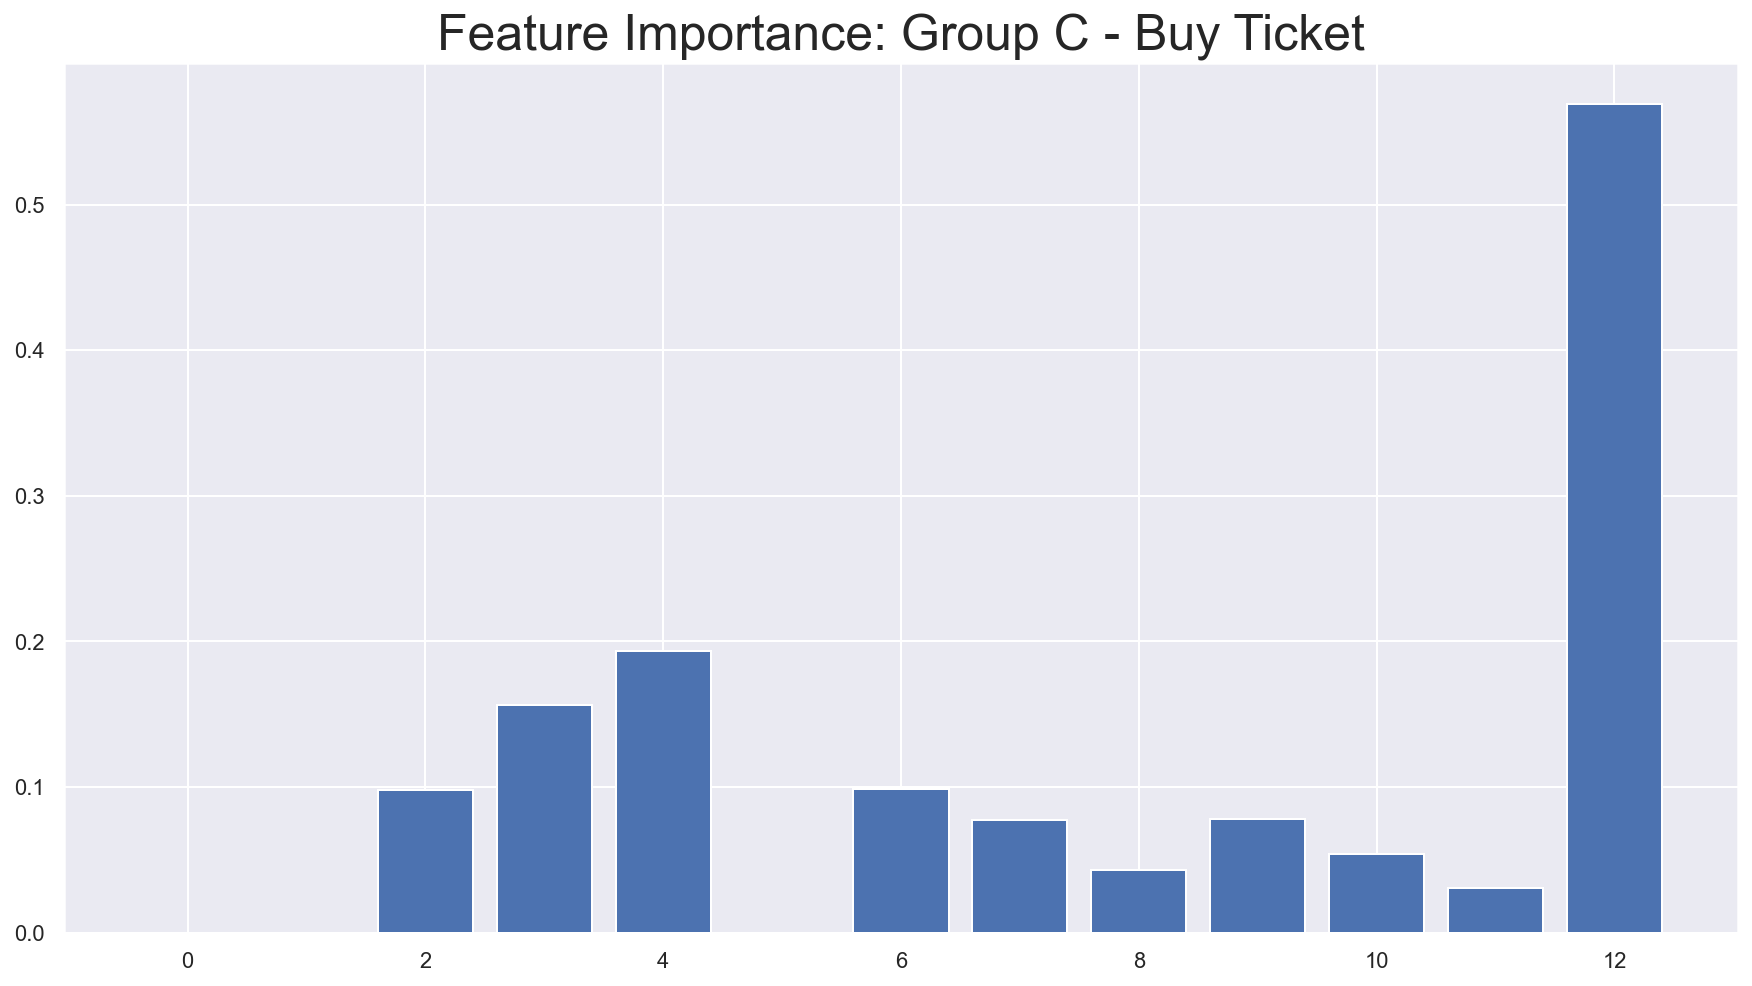

In [58]:
#Group C -> Creating a Training & Testing DataSet
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(train_out_c.iloc[:,:-1], train_out_c.iloc[:,-1], test_size=0.25, random_state=1)
#Prepare Input Data
X_train_enc_c, X_test_enc_c = prepare_input(train_out_c.iloc[:,:-1], X_train_c, X_test_c)
#Feature Selection & Plot Scores
X_train_score_c, X_test_score_c = select_features(X_train_enc_c, y_train_c.values.astype('int64'), X_test_enc_c, 'mutual_info_class', 'all', 'Group C - Buy Ticket')

Feature 0 : Score 0.026836206749739633
Feature 1 : Score 0.009685744868193291
Feature 2 : Score 0.06570202869381236
Feature 3 : Score 0.0992312985739241
Feature 4 : Score 0.11139842913248077
Feature 5 : Score 0.0016904220558366934
Feature 6 : Score 0.05856060802654883
Feature 7 : Score 0.059203593794438625
Feature 8 : Score 0.01436039551366064
Feature 9 : Score 0.05491758212552322
Feature 10 : Score 0.034857860843064525
Feature 11 : Score 0.07998606622719961
Feature 12 : Score 0.03840760546553179


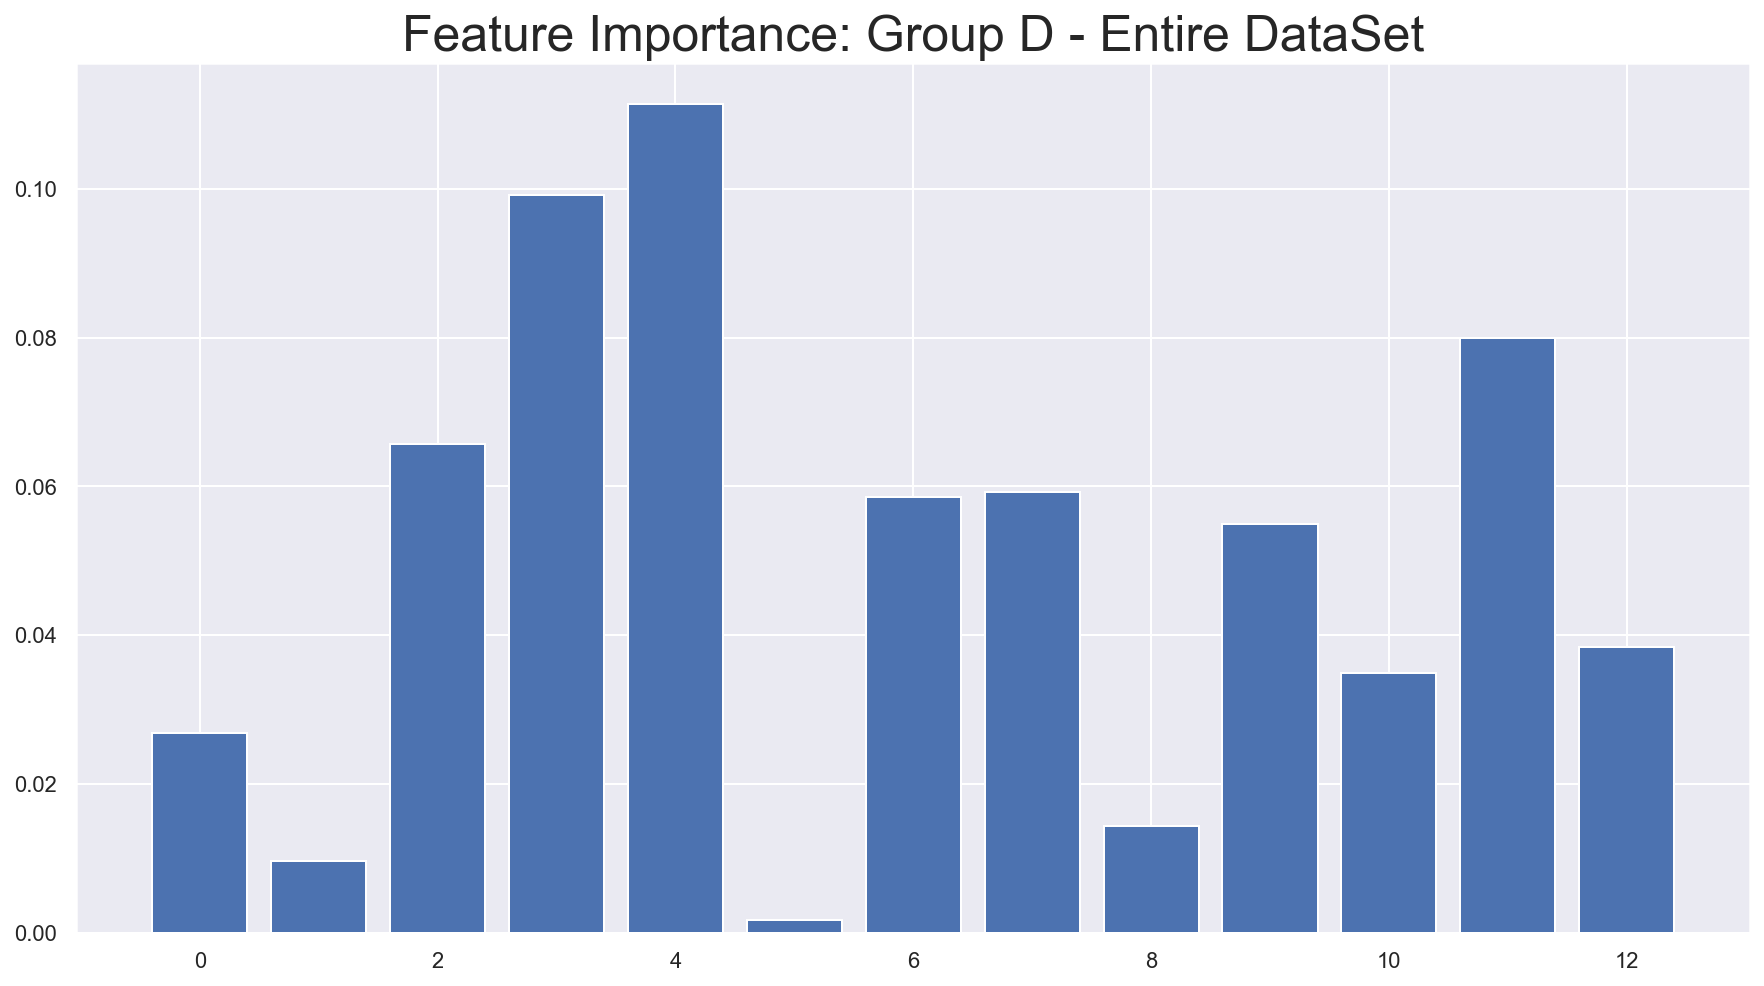

In [103]:
#Group D -> Creating a Training & Testing DataSet
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(train_upd_d.iloc[:,1:-1], train_upd_d.iloc[:,-1], test_size=0.25, random_state=1)
#Prepare Input Data
X_train_enc_d, X_test_enc_d = prepare_input(train_upd_d.iloc[:,1:-1], X_train_d, X_test_d)
#Feature Selection & Plot Scores
X_train_score_d, X_test_score_d = select_features(X_train_enc_d, y_train_d.values.astype('int64'), X_test_enc_d, 'mutual_info_class', 'all' ,'Group D - Entire DataSet')

### 4.6.3 - RFE - Recursive Feature Selection

Optimum Number of Features: 10


Score with 10 features: 0.873922
Gender                     True
Native Continent           True
Age                        True
Marital Status             True
Lives with                 True
Base Area                  True
Education Level            True
Years of Education         True
Employment Sector          True
Role                       True
Working Hours per week    False
Money Received            False
Ticket Price              False
dtype: bool


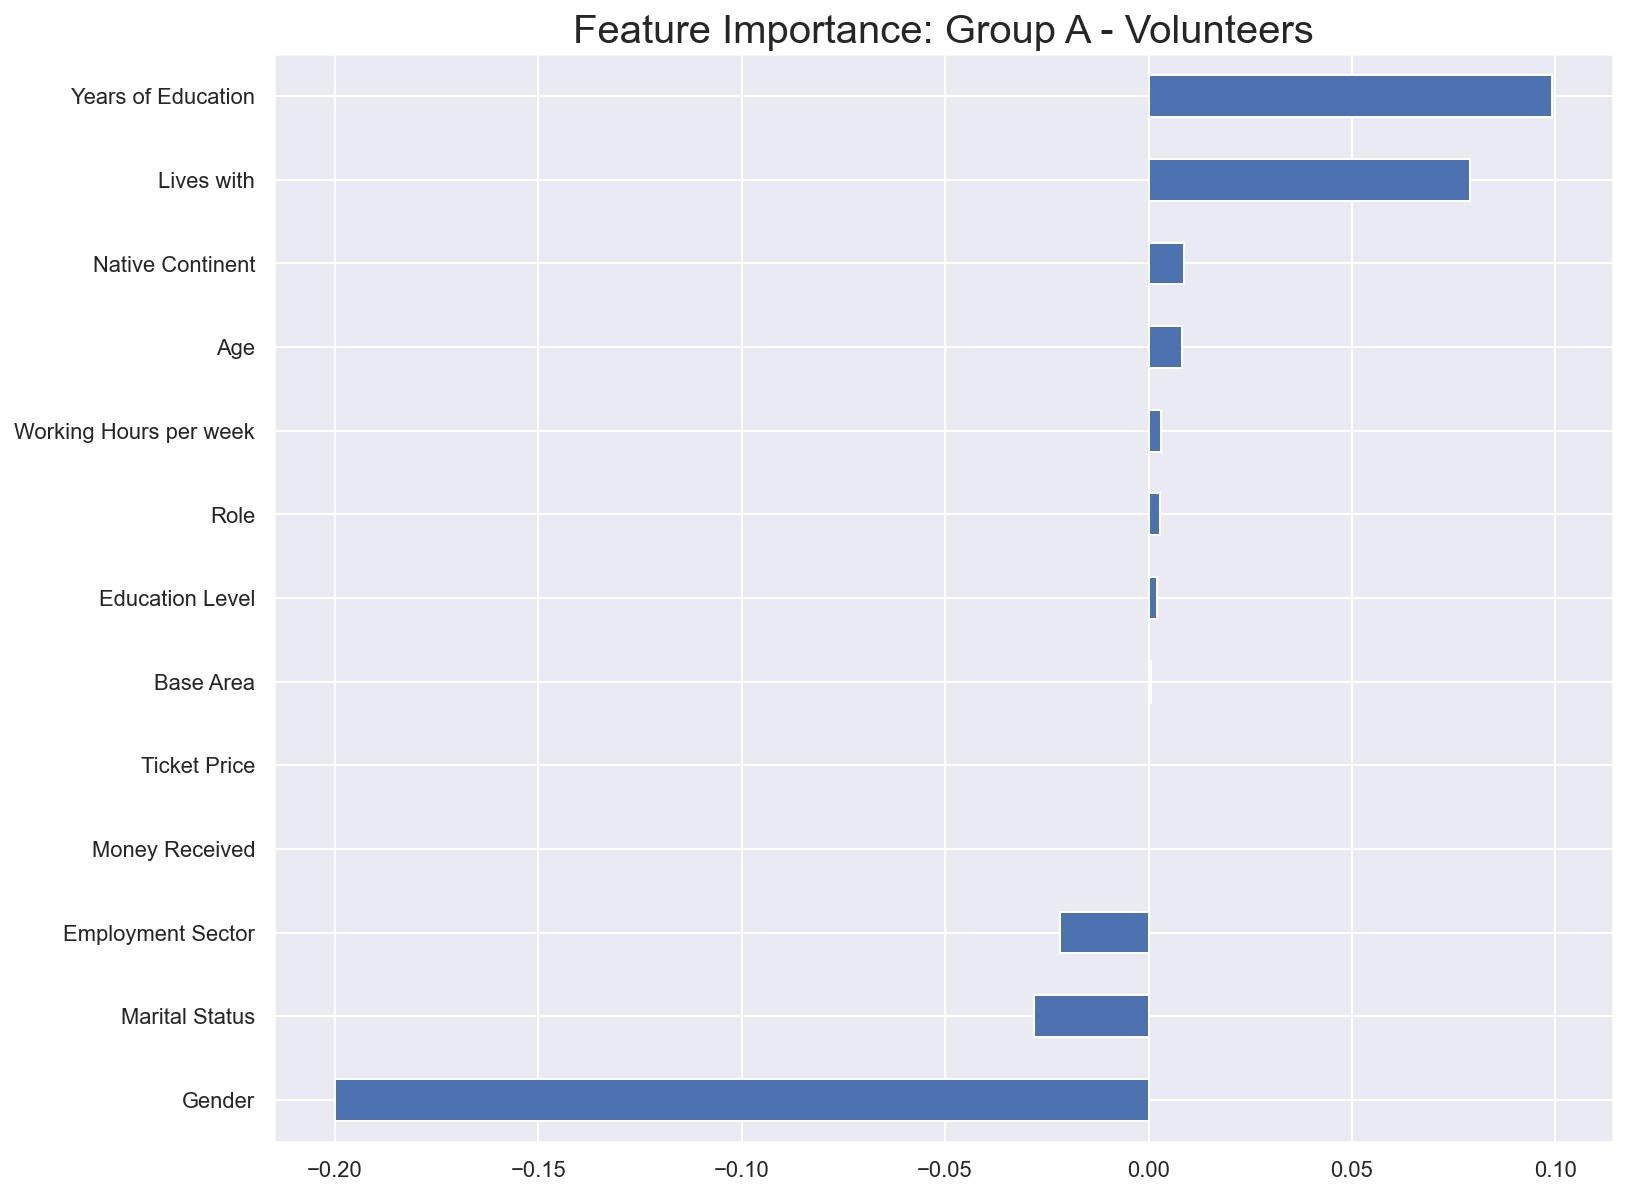

In [60]:
#Make a copy from the training group A dataframe prior to apply ordinal encoder for categorical columns
train_enc_a=train_out_a.copy()
for i in cat_col: encode(train_enc_a[i])
#Call RFE & Plot Feature Importance
plot_importance(rfe_group(train_enc_a),'Group A - Volunteers')

Optimum Number of Features: 12


Score with 12 features: 0.881720
Gender                     True
Native Continent           True
Age                        True
Marital Status             True
Lives with                 True
Base Area                  True
Education Level            True
Years of Education         True
Employment Sector          True
Role                       True
Working Hours per week     True
Money Received             True
Ticket Price              False
dtype: bool


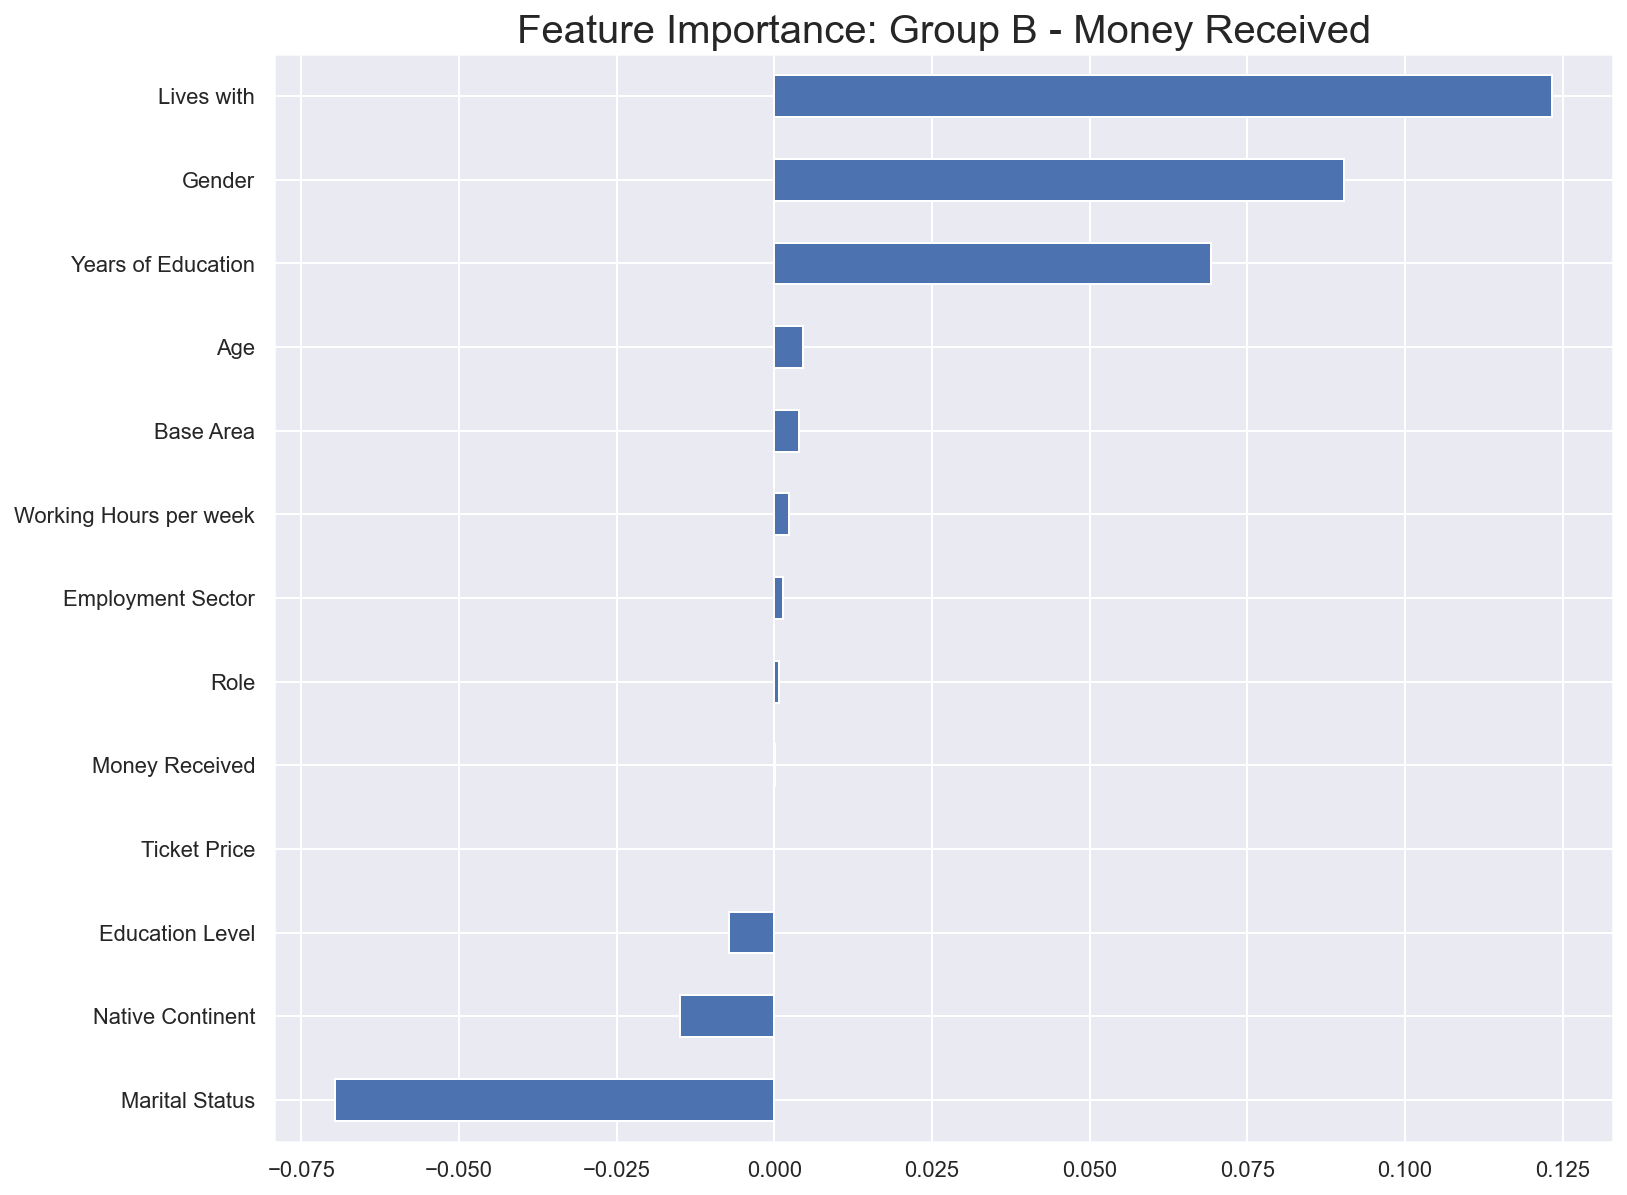

In [61]:
#Make a copy from the training group B dataframe prior to apply ordinal encoder for categorical columns
train_enc_b =train_out_b.copy()
for i in cat_col: encode(train_enc_b[i])
#Call RFE & Plot Feature Importance
plot_importance(rfe_group(train_enc_b),'Group B - Money Received')

Optimum Number of Features: 13


Score with 13 features: 0.826087
Gender                    True
Native Continent          True
Age                       True
Marital Status            True
Lives with                True
Base Area                 True
Education Level           True
Years of Education        True
Employment Sector         True
Role                      True
Working Hours per week    True
Money Received            True
Ticket Price              True
dtype: bool


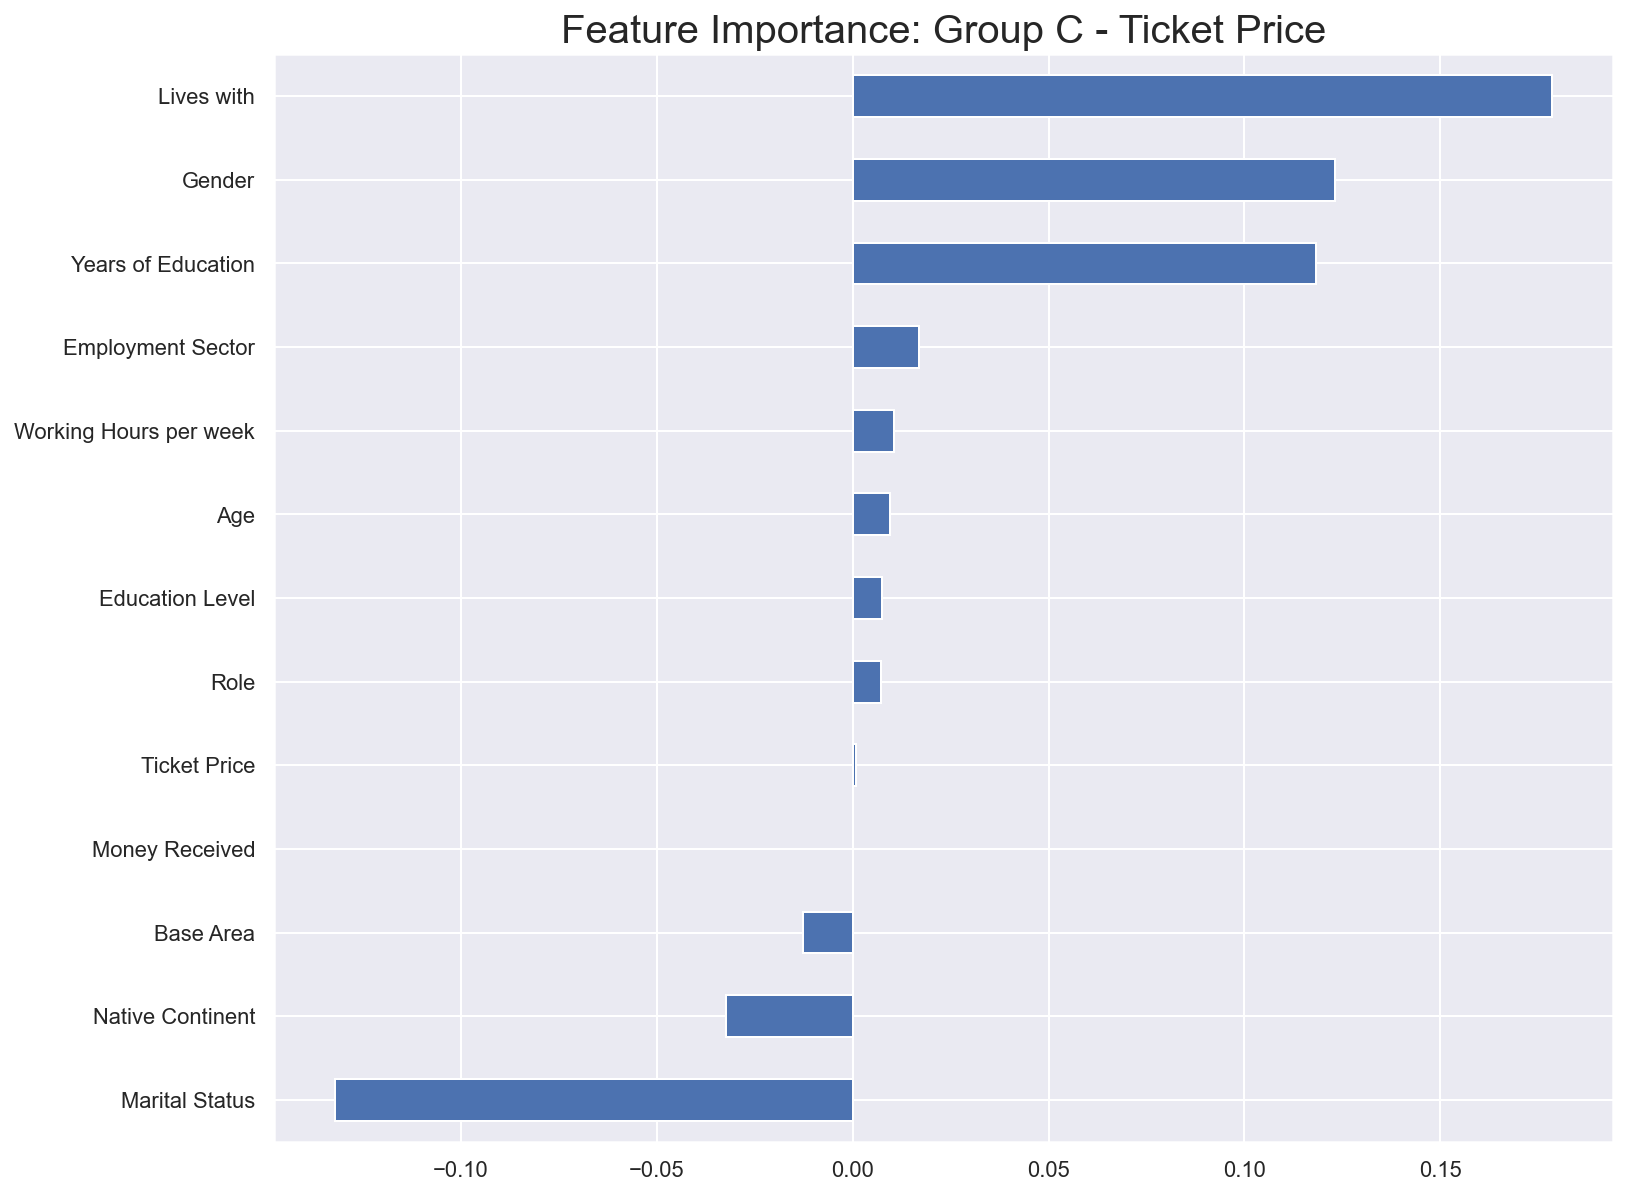

In [62]:
#Make a copy from the training group B dataframe prior to apply ordinal encoder for categorical columns
train_enc_c =train_out_c.copy()
for i in cat_col: encode(train_enc_c[i])
#Call RFE & Plot Feature Importance
plot_importance(rfe_group(train_enc_c),'Group C - Ticket Price')

Optimum Number of Features: 2


Score with 2 features: 0.810045
Gender                    False
Native Continent          False
Age                       False
Marital Status            False
Lives with                 True
Base Area                 False
Education Level           False
Years of Education         True
Employment Sector         False
Role                      False
Working Hours per week    False
Money Received            False
Ticket Price              False
dtype: bool


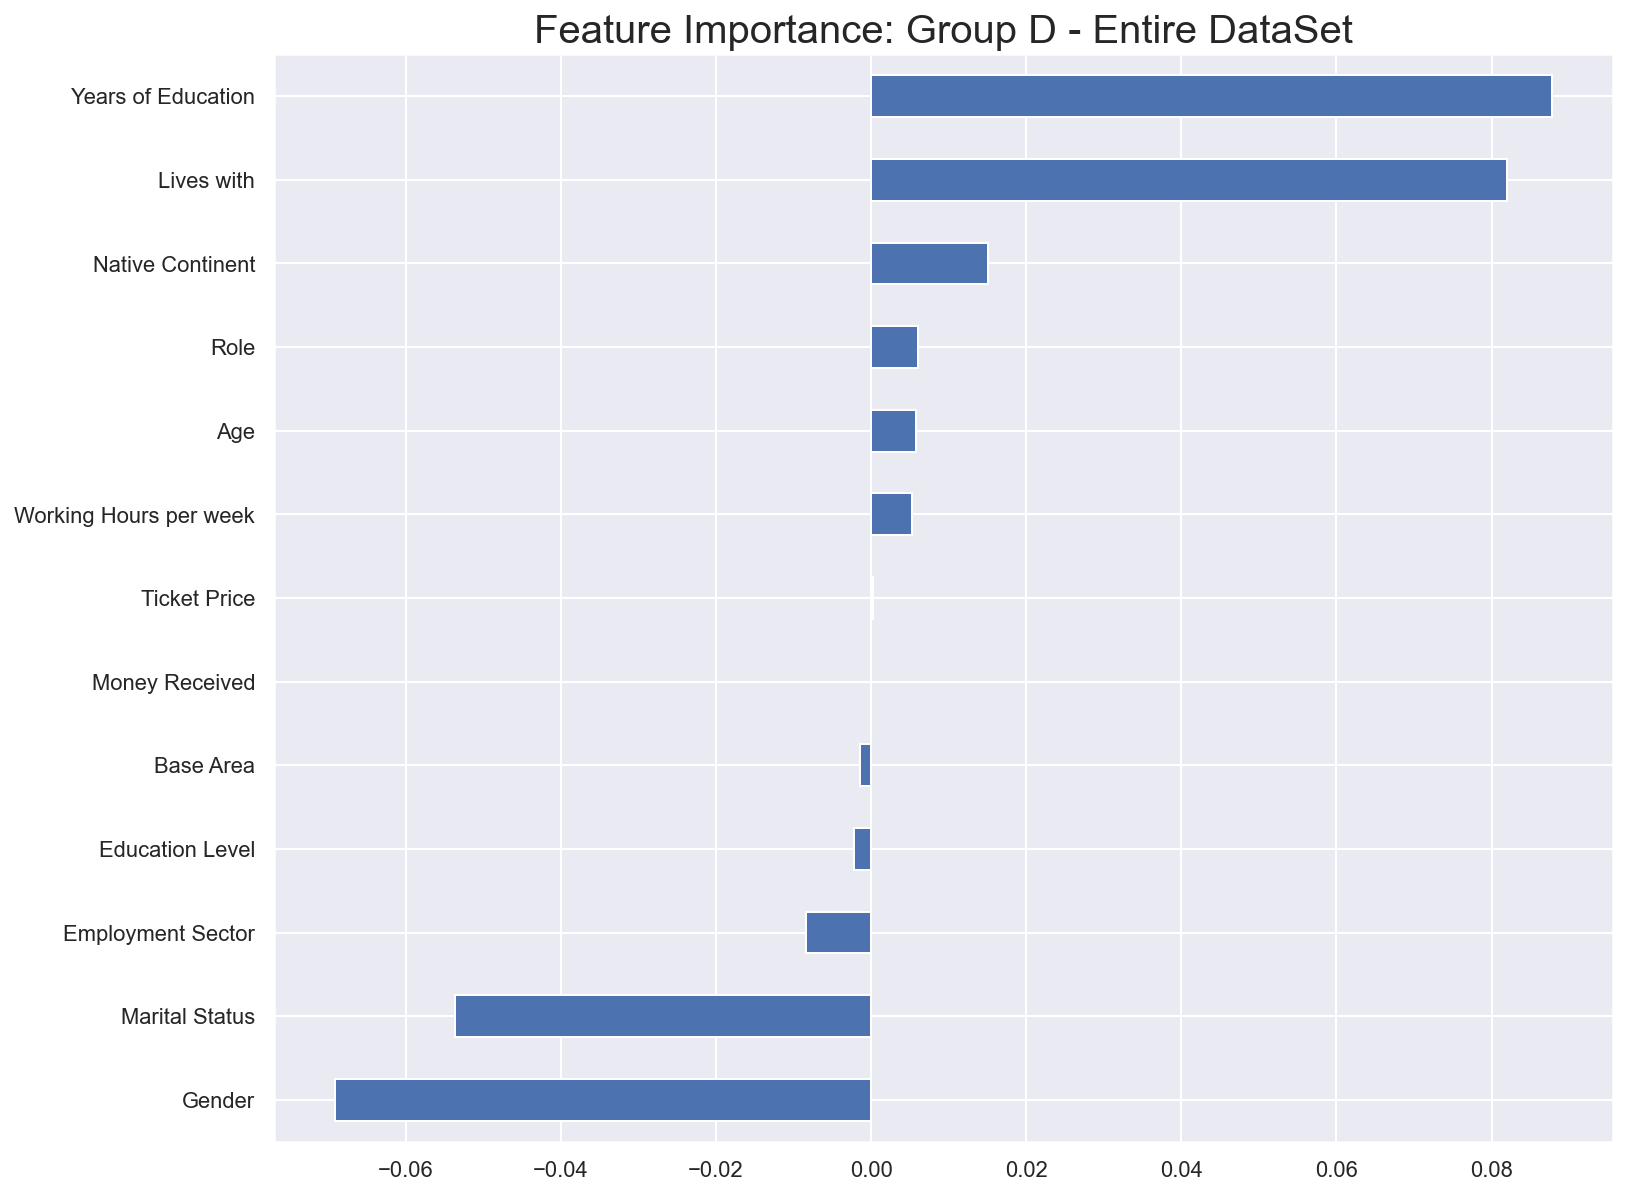

In [104]:
#Make a copy from the training group B dataframe prior to apply ordinal encoder for categorical columns
train_enc_d =train_upd_d.iloc[:,1:].copy()
for i in cat_col: encode(train_enc_d[i])
#Call RFE & Plot Feature Importance
plot_importance(rfe_group(train_enc_d),'Group D - Entire DataSet')

# 5 - Classifier Baseline Benchmark

In [64]:
def classifier_selection(X_train, X_val, y_train, y_val, classifier):
    classifier_score_list=[]
    index_name=['KNN','LR','NB','GBC']
    df = pd.DataFrame(index=index_name, columns=['Results'])
    for classify in classifier:
        classifier = classify
        classifier.fit(X_train, y_train)
        classifier_score = classifier.score(X_val,y_val)
        classifier_score_list.append(classifier_score)
    df['Results']=classifier_score_list
    return df

In [65]:
#Create X & y train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_enc_d.iloc[:,:-1], 
                                                  train_enc_d.iloc[:,-1], 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  stratify=train_enc_d.iloc[:,-1])

In [66]:
classifier_selection(X_train, X_val, y_train, y_val,[KNeighborsClassifier(),LogisticRegression(),GaussianNB(),GradientBoostingClassifier()])

,Results
KNN,0.833286
LR,0.846373
NB,0.760740
GBC,0.858037


In [67]:
def scaler_selection(X_train, X_val, y_train, y_val, model):
    column_name = ['KNN','LR','NB','BGD']
    df = pd.DataFrame(index=['Normalizer_test','Robust_test','Minmax_test','Minmax_test2','Standard_test'],columns=column_name)
    for i,mode in enumerate(model):
        #Normalizer
        transformer = Normalizer()
        transformer.fit(X_train)
        transformer_X_train = transformer.transform(X_train)
        transformer_X_val = transformer.transform(X_val)
        model_baseline_transformer = mode
        model_baseline_transformer.fit(transformer_X_train, y_train)
        transformerf1_val = model_baseline_transformer.score(transformer_X_val,y_val)

        #RobustScaler
        robust_scaler = RobustScaler()
        robust_scaler.fit(X_train)
        robust_X_train = robust_scaler.transform(X_train)
        robust_X_val = robust_scaler.transform(X_val)
        model_baseline_robust = mode
        model_baseline_robust.fit(robust_X_train, y_train)
        robustf1_val = model_baseline_robust.score(robust_X_train,y_train)

        #MinMax(-1, 1)
        minmax = MinMaxScaler(feature_range=(-1, 1))
        minmax.fit(X_train)
        min_max_X_train = minmax.transform(X_train)
        min_max_X_val = minmax.transform(X_val)
        min_max_model = mode
        min_max_model.fit(min_max_X_train, y_train)
        minmaxf1_val = min_max_model.score(min_max_X_val,y_val)

        #MinMax
        minmax2 = MinMaxScaler()
        minmax2.fit(X_train)
        min_max_X_train2 = minmax2.transform(X_train)
        min_max_X_val2 = minmax2.transform(X_val)
        min_max_model2 = mode
        min_max_model2.fit(min_max_X_train2, y_train)
        minmaxf1_val2 = min_max_model2.score(min_max_X_val2,y_val)

        #StandardScaler
        standardscaler = StandardScaler()
        standardscaler.fit(X_train)
        standardscaler_X_train = standardscaler.transform(X_train)
        standardscaler_X_val = standardscaler.transform(X_val)
        standardscaler_model = mode
        standardscaler_model.fit(standardscaler_X_train, y_train)
        standard_f1_val = standardscaler_model.score(standardscaler_X_val,y_val)
          
        df[column_name[i]][0] = transformerf1_val
        df[column_name[i]][1] = robustf1_val
        df[column_name[i]][2] = minmaxf1_val     
        df[column_name[i]][3] = minmaxf1_val2
        df[column_name[i]][4] = standard_f1_val
    return df

In [68]:
scaler_selection(X_train, X_val, y_train, y_val, [KNeighborsClassifier(),LogisticRegression(),GaussianNB(),GradientBoostingClassifier()])

,KNN,LR,NB,BGD
Normalizer_test,0.837269,0.819915,0.739972,0.860313
Robust_test,0.886052,0.849491,0.759869,0.865922
Minmax_test,0.839829,0.850071,0.76074,0.858037
Minmax_test2,0.839829,0.850356,0.76074,0.858037
Standard_test,0.832717,0.849787,0.76074,0.858037


# 6 - Predictive Modelling

## 6.1 Logistic Regression

### 6.1.4 Entire DataSet

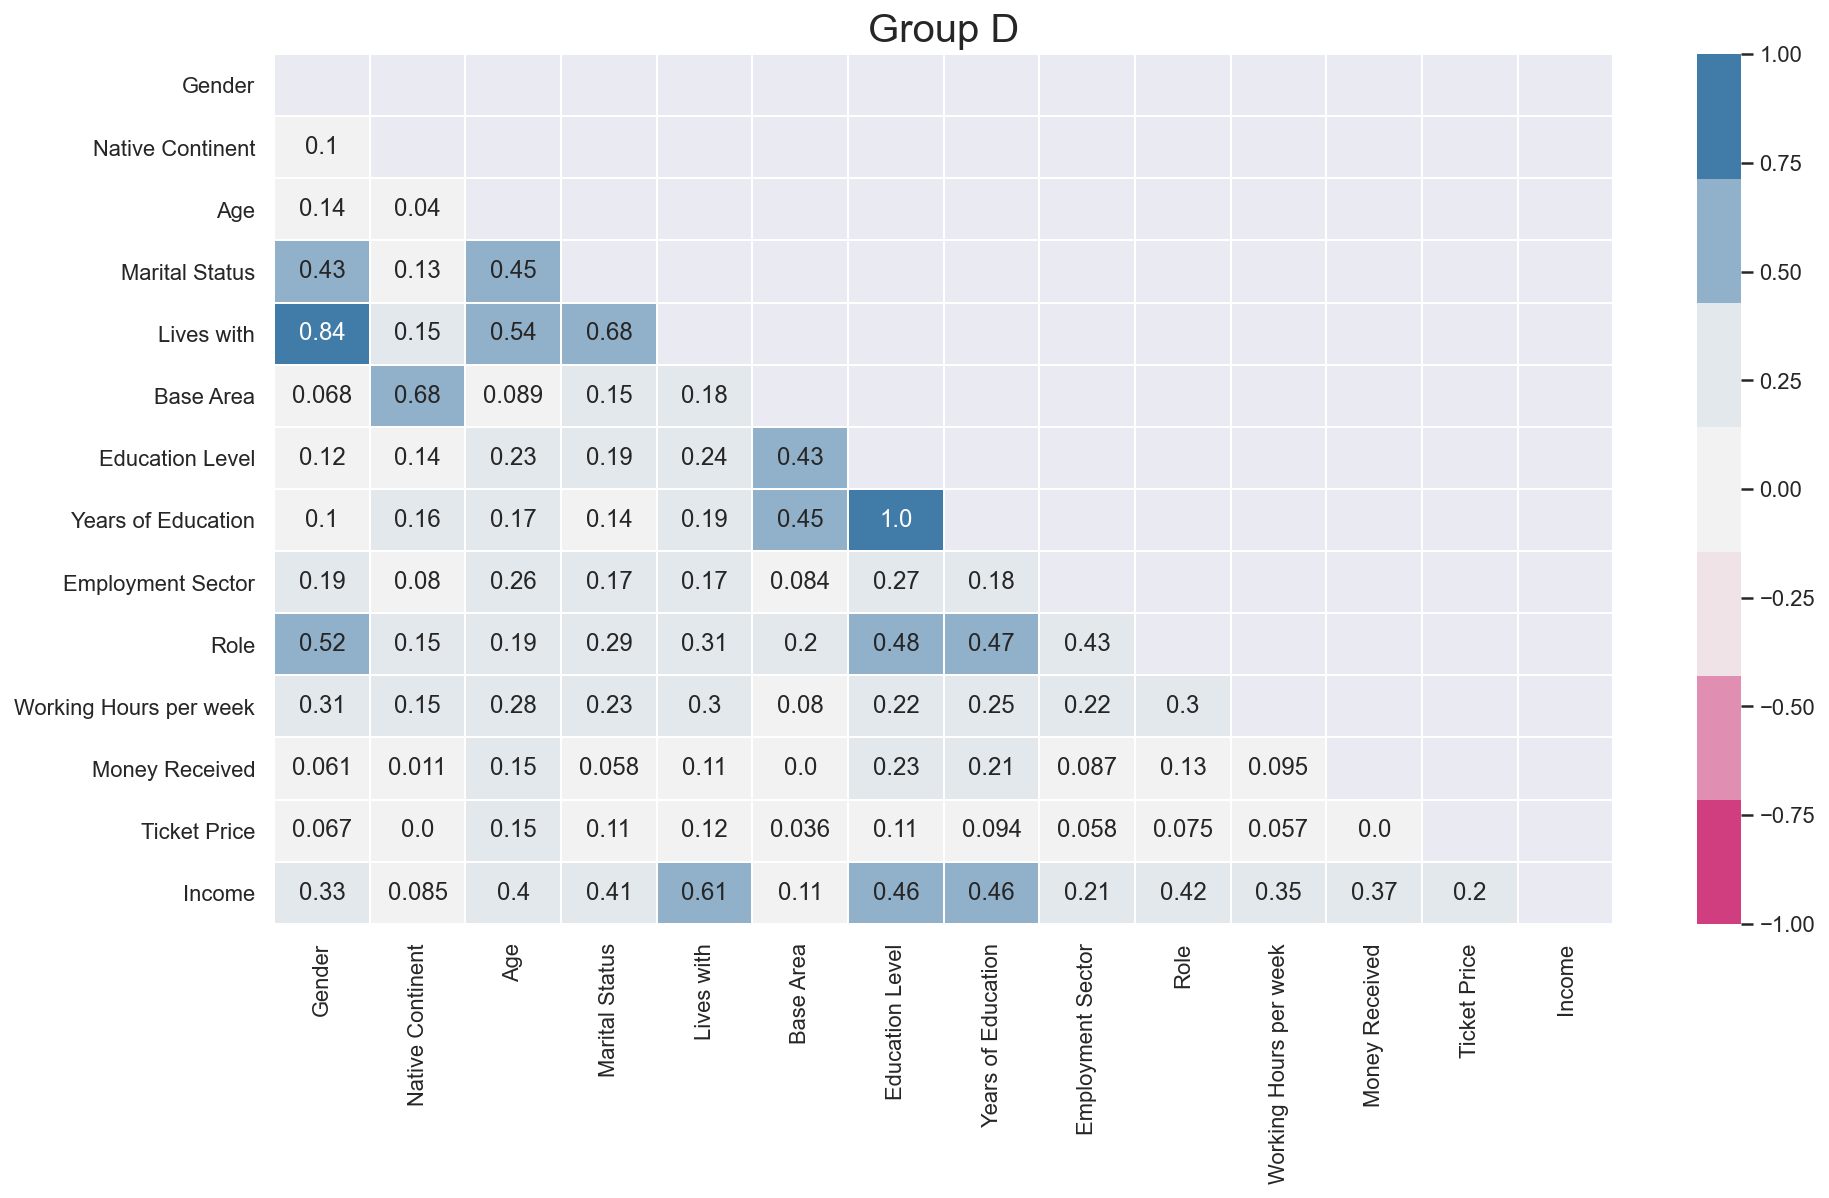

In [82]:
print_corr_matrix(get_phi_k_corr(train_upd_d,''),'Group D')

In [120]:
#train_data_d=train_out_d.iloc[:,[2,3,4,6,9,10]]#Getting the features from MIC
train_data_d=train_upd_d.iloc[:,1:].copy()
train_data_d=train_data_d.iloc[:,[2,3,4,7,9,10,11]]#Getting the features from MIC
train_target_d=train_upd_d.iloc[:,-1].copy()

In [122]:
train_transf_d=make_column_transformer((OneHotEncoder(handle_unknown = 'ignore'),['Marital Status','Lives with','Education Level','Role']),
                                  remainder='passthrough')
#train_transf_d=make_column_transformer((OneHotEncoder(handle_unknown = 'ignore'),['Marital Status','Lives with','Role']),
#                                  (OrdinalEncoder(),['Education Level']),
#                                  remainder='passthrough')

In [123]:
X_train, X_val, y_train, y_val = train_test_split(train_data_d, train_target_d, test_size=0.3, random_state=42, shuffle=True,
                                                  stratify=train_target_d)

In [124]:
train_pipe_d=make_pipeline(train_transf_d, LogisticRegression())

In [125]:
cross_val_score(train_pipe_d, X_train, y_train, cv=20, scoring='accuracy').mean()

nan

In [430]:
train_pipe_d.fit(X_train, y_train)
y_pred=train_pipe_d.predict(X_val)
y_pred

array([0., 0., 1., ..., 0., 0., 0.])

In [432]:
cm = confusion_matrix(y_val, y_pred)
cm

array([[4083,  252],
       [ 493,  445]])

The confusion matrix in sklearn is presented in the following format: <br>
[ [ TN  FP  ] <br>
    [ FN  TP ] ]

In [433]:
accuracy = accuracy_score(y_val, y_pred)
accuracy

0.8587142044377015

In [435]:
precision = precision_score(y_val, y_pred)
precision

0.6384505021520803

In [436]:
recall_score(y_val, y_pred)

0.4744136460554371

In [438]:
f1 = f1_score(y_val, y_pred ,average='micro')
f1

0.8587142044377015

In [439]:
print('Results on the validation set:')
print(classification_report(y_true = y_val, y_pred = y_pred))

Results on the validation set:
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.92      4335
         1.0       0.64      0.47      0.54       938

    accuracy                           0.86      5273
   macro avg       0.77      0.71      0.73      5273
weighted avg       0.85      0.86      0.85      5273



### Model Performance measures

In [148]:
# Not sure R2 and Adjusted R2 are the best algorithms to check logistic regression. 

<a class="anchor" id="rsquare">
    
###  $R^{2}$ Score

</a>

__When to use?__ <br>
When we want to measure the amount of variance in the target variable that can be explained by our model. <br>
It gives the degree of variability in the target variable that is explained by the model or the independent variables. <br>
If this value is 0.7, then it means that the independent variables explain 70% of the variation in the target variable. <br>

__Definition:__ <br>
R^2 (coefficient of determination) regression score function.

__Interpretation:__ <br>
Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 

__Parameters:__ <br>
_y_true_: Ground truth (correct) target values; <br>
_y_pred_: Estimated target values; <br>


In [440]:
r2_score(y_val, y_pred)
#when we want to measure variance in target value.
#when you apply R2 score to different number of variables the R2 score changes,
#not good to compare. We can use Adjusted R score.

0.033899951552174734

In [441]:
r2 = r2_score(y_val, y_pred)
n = len(y_val)
p = len(X_train.columns)

def adj_r2 (r2,n,p):
    return 1-(1-r2)*(n-1)/(n-p-1)

adj_r2(r2,n,p)

0.032615488049964836

### 6.1.2 Dataset Essencials

In [442]:
#Essencials dataset
train_b = train_upd_b.iloc[:,:-1]
target_b = train_upd_b.iloc[:,-1]

In [ ]:
# dividing Essencial dataset into train and validation. 
X_train, X_val, y_train, y_val = train_test_split(train_b,target_b, test_size=0.2, random_state=5, stratify=target_b) 

In [ ]:
log_model = LogisticRegression()

In [ ]:
log_model.fit(X_train,y_train)

In [ ]:
y_pred = log_model.predict(X_val)
#y_pred

In [ ]:
pred_prob = log_model.predict_proba(X_val)
#pred_prob

In [ ]:
log_model.coef_

In [ ]:
cm = confusion_matrix(y_val, y_pred)
cm

In [ ]:
accuracy = accuracy_score(y_val, y_pred)
accuracy

In [ ]:
precision = precision_score(y_val, y_pred)
precision

In [ ]:
recall_score(y_val, y_pred)

In [ ]:
f1 = f1_score(y_val, y_pred)
f1

In [ ]:
print('Results on the validation set:')
print(classification_report(y_true = y_val, y_pred = y_pred)
)

### Performance measures

### 6.1.2 Dataset Ticket Buyers

In [ ]:
#Ticket buyers
train_c = train_upd_c.iloc[:,:-1]
target_c = train_upd_c.iloc[:,-1]

In [ ]:
# dividing Essencial dataset into train and validation. 
X_train, X_val, y_train, y_val = train_test_split(train_c,target_c, test_size=0.2, random_state=0, stratify=target_c) 

In [ ]:
log_model = LogisticRegression()

In [ ]:
log_model.fit(X_train,y_train)

In [201]:
log_regression = log_model

In [ ]:
y_pred = log_model.predict(X_val)
#y_pred

In [ ]:
pred_prob = log_model.predict_proba(X_val)
#pred_prob

In [ ]:
log_model.coef_

In [ ]:
cm = confusion_matrix(y_val, y_pred)
cm

In [ ]:
accuracy = accuracy_score(y_val, y_pred)
accuracy

In [ ]:
precision = precision_score(y_val, y_pred)
precision

In [ ]:
recall_score(y_val, y_pred)

In [ ]:
f1 = f1_score(y_val, y_pred)
f1

In [ ]:
print('Results on the validation set:')
print(
    # write your code in here
    classification_report(y_true = y_val, y_pred = y_pred)
)

### Performance measures

# 7) Prediction preparation

In [443]:
test_upd = test.copy()

In [444]:
test_upd.insert(2,'Gender',test_upd['Name'].str.slice(0,4).str.replace('.','').str.replace(' ',''))

In [445]:
test_upd['Gender']=test_upd['Gender'].apply(lambda i: 0 if i=='Mr' else 1)

In [446]:
test_upd.drop('Name',axis=1,inplace=True)

In [447]:
test_upd['Gender'].unique()

array([0, 1])

In [448]:
test_upd.insert(4,'Age',pd.Series([]))
for i,j in enumerate(list(test_upd['Birthday'].values)):
    try:
        test_upd['Age'][i]=np.round((datetime.now()+timedelta(days=10228)-datetime.strptime(j.replace(' ',''),'%B%d,%Y'))/timedelta(days=365.2425))
    except ValueError:
        test_upd['Age'][i]=np.round((datetime.now()+timedelta(days=10228)-datetime.strptime(j.replace(' ','').replace('9','8'),'%B%d,%Y'))/timedelta(days=365.2425))
test_upd['Age']=test_upd['Age'].astype('uint8')

In [449]:
test_upd.drop('Birthday',axis=1,inplace=True)

In [450]:
test_upd['Income'] = 0

In [451]:
# since we are using IterativeImputer() to fill the '?' string values we need to change them to NaN's so the algorigthm works.
for i in [6,9,10]:
    aIndex=np.array(test_upd[test_upd.iloc[:,i].astype(str).str.startswith('?')].iloc[:,i].index)
    for j in aIndex:
        test_upd.iloc[j,i]=np.nan
test_upd.isna().sum()

CITIZEN_ID                  0
Gender                      0
Native Continent            0
Age                         0
Marital Status              0
Lives with                  0
Base Area                 187
Education Level             0
Years of Education          0
Employment Sector         570
Role                      570
Working Hours per week      0
Money Received              0
Ticket Price                0
Income                      0
dtype: int64

In [452]:
#Creating a data frame with the categorical variables.
cat_col = test_upd.select_dtypes(include=['object']).columns.values

In [453]:
#Encode before filling the missing values
test_bkp=test_upd.copy()
for i in cat_col:
    encode(test_upd[i])

In [454]:
#Filling NaN according to Mice algorithm
test_upd=pd.DataFrame(np.round(mice.fit_transform(test_upd)),columns=test_upd.columns)
for col in cat_col:
    reshape = np.array(test_bkp[col].dropna()).reshape(-1,1)
    ordinal = encoder.fit_transform(reshape)
    test_upd[col] = encoder.inverse_transform(np.round(mice.fit_transform(test_upd[col].values.reshape(-1,1))))

In [455]:
test_upd.isna().sum()

CITIZEN_ID                0
Gender                    0
Native Continent          0
Age                       0
Marital Status            0
Lives with                0
Base Area                 0
Education Level           0
Years of Education        0
Employment Sector         0
Role                      0
Working Hours per week    0
Money Received            0
Ticket Price              0
Income                    0
dtype: int64

In [456]:
test_upd.set_index('CITIZEN_ID',inplace=True)

In [457]:
test_upd['Income'] = train_pipe_d.predict(test_upd.iloc[:,[2,3,4,6,7,9,10]])
pd.options.display.float_format = '{:,.0f}'.format
test_upd['Income'] = test_upd['Income'].astype(float)

In [458]:
test_result=test_upd.copy()
test_result.reset_index(inplace=True)

In [459]:
test_result['CITIZEN_ID']=test['CITIZEN_ID'].astype(str)
test_result.set_index('CITIZEN_ID',inplace=True)
test_result['Income']=test_result.iloc[:,-1].astype(int)
test_result['Income']=test_result['Income'].astype('string')

In [462]:
test_result.iloc[:,-1].to_csv('log2_test.csv')

# 8) Evaluation / Assessment

# 9) Optimization

# 10) Conclussion